In [1]:
import os
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import re
from IPython.display import HTML

mpl.rcParams['figure.dpi'] = 300

try:
    experiment_folder = os.environ['AZEBAN_EXPERIMENT_DIR']
except:
    experiment_folder = '/home/tobias/Programmieren/azeban/build'

In [2]:
def read_spectrum(path, samples=None, times=None):
    files = os.listdir(path)
    reg = re.compile(r'^energy_\d+_time_\d+.txt$')
    spectrum_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in spectrum_files]))))
    if times is None:
        times = list(set(list(sorted([int(f[:-4].split('_')[3]) for f in spectrum_files]))))
    spectra = []
    for t in times:
        spectrum = []
        for s in samples:
            with open(os.path.join(path, f'energy_{s}_time_{t}.txt'), 'r') as f:
                spectrum.append([float(v) for v in f.read().split()])
        spectra.append(np.array(spectrum))
    return spectra

def compensate_spectrum(spectra, gamma):
    compensated_spectra = []
    for spectrum in spectra:
        K = np.array([[2*np.pi*i for i in range(spectrum.shape[1])]])
        compensated_spectra.append(K**gamma * spectrum)
    return compensated_spectra

def spectrum_mean(spectra):
    means = [np.mean(spectrum, 0) for spectrum in spectra]
    return means

def spectrum_variance(spectra):
    variances = [np.var(spectrum, 0) for spectrum in spectra]
    return variances

def spectrum_quantiles(spectra, q):
    quantiles = [np.quantile(spectrum, q, 0) for spectrum in spectra]
    return quantiles

In [3]:
def plot_spectrum(paths, Ns, time, gamma, save_name=None, samples=None):
    min_val = np.inf
    max_val = -np.inf
    for i,(path,N) in enumerate(zip(paths, Ns)):
        spectra = read_spectrum(path, samples, times=[time])
        spectra = compensate_spectrum(spectra, gamma)
        mean = spectrum_mean(spectra)[0]
        min_val = min(min_val, np.min(mean[1:]))
        max_val = max(max_val, np.max(mean[1:]))
        K = [2*np.pi*k for k in range(len(mean))]
        plt.loglog(K, mean, color=f'C{i}', label=f'N={N}')
    plt.loglog(K, [max_val]*len(K), '--', color='grey', label='$K^{-\\gamma}$')
    plt.xlabel('$K$')
    plt.ylabel(r'$K^{\gamma}E(K)$')
    plt.legend()
    plt.title(f'Compensated Energy Spectrum for $\\gamma={gamma:.3}$')
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    
def animate_spectrum(paths, Ns, gamma, times=None, samples=None):
    spectra = [read_spectrum(path, samples, times) for path in paths]
    spectra = [compensate_spectrum(spectrum, gamma) for spectrum in spectra]
    means = [spectrum_mean(spectrum) for spectrum in spectra]
    means = [[m/m[1] for m in mean] for mean in means]
    max_mean = max([max([max([max(t[1:]) for t in m]) for m in means]) for mean in means])
    min_mean = min([min([min([min(t[1:]) for t in m]) for m in means]) for mean in means])
    K = [[2*np.pi*k for k in range(len(mean[0]))] for mean in means]
    fig, ax = plt.subplots()
    lines = []
    for N in Ns:
        lines.append(plt.loglog([], label=f'N={N}')[0])
    plt.loglog(K[-1], [1]*len(K[-1]), '--', color='grey', label='$K^{-\\gamma}$')
    ax.set_xlim(K[0][1], K[-1][-1])
    ax.set_ylim(min_mean, max_mean)
    plt.legend()
    def animate(frame):
        for i,line in enumerate(lines):
            line.set_data((K[i], means[i][frame]))
        return lines
    anim = FuncAnimation(fig, animate, frames=len(means[0]), interval=20)
    HTML(anim.to_html5_video())

In [4]:
def energy(spectra):
    energies = [np.sum(spectrum, 1) for spectrum in spectra]
    return energies

def energy_mean(energies):
    means = [e.mean() for e in energies]
    return means

def energy_dissipation(energies, dt):
    diss = [(energies[i+1]-energies[i])/dt for i in range(len(energies)-1)]
    return diss
    
def relative_energy_dissipation(energies, dt):
    diss = energy_dissipation(energies, dt)
    rel_diss = [de/energies[0] for de in diss]
    return rel_diss

In [5]:
def _best_fit(x, y, t0=None, t1=None):
    best_err = np.inf
    best_interval = None
    best_p = None
    min_interval_size = len(x) // 4
    for t_begin in (range(1, len(x)-min_interval_size) if t0 is None else [t0]):
        for t_end in (range(t_begin+min_interval_size, len(x)) if t1 is None else [t1-1]):
            p,res,rank,sv,rcond = np.polyfit(x[t_begin:t_end], y[t_begin:t_end], 1, full=True)
            err = sum(res) / (len(res) * (x[t_end]-x[t_begin])**3)
            if err < best_err:
                best_err = err
                best_interval = [t_begin, t_end]
                best_p = p
    print(f'best fit found in interval {best_interval} with error {best_err}')
    return best_p

def _fit_energy(energies, dt):
    t = np.array([t*dt for t in range(len(energies))])
    p = _best_fit(t, np.log(np.array(energies)), t1=len(energies))
    return p

def plot_energy(paths, Ns, dt, save_name=None, samples=None, times=None, loglog=False, fit_interval=None):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        spectra = read_spectrum(path, samples, times)
        energies = energy(spectra)
        E = [e.mean() for e in energies]
        t = np.linspace(0, len(E)*dt, len(E))
        if loglog:
            plt.semilogy(t, E, color=f'C{i}', label=f'N={N}')
            if fit_interval is not None:
                t0 = int(fit_interval[0] / dt)
                t1 = int(fit_interval[1] / dt)
                ps = _fit_energy(energies, dt)
                p0_mean = ps[0].mean()
                p0_stdev = ps[0].std() / np.sqrt(energies[0].shape[0])
                p1_mean = ps[1].mean()
                p1_stdev = ps[1].std() / np.sqrt(energies[0].shape[0])
                plt.semilogy(t, np.exp(p0_mean*t+p1_mean), '--', color=f'C{i}', label=f'$e^{{({p0_mean:.2f} \\pm {p0_stdev:.3f})t}}$', alpha=0.5)
        else:
            plt.plot(t, E, color=f'C{i}', label=f'N={N}')
    plt.xlabel('t')
    plt.ylabel('E(t)')
    plt.title('Total Energy over Time')
    plt.legend()
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()
    
def plot_relative_energy_dissipation(paths, Ns, dt, save_name=None, samples=None, times=None, loglog=False, fit_interval=None):
    for i,(path,N) in enumerate(zip(paths, Ns)):
        spectra = read_spectrum(path, samples, times)
        energies = energy(spectra)
        rel_diss = [-e.mean() for e in relative_energy_dissipation(energies, dt)]
        t = np.linspace(0, len(rel_diss)*dt, len(rel_diss))
        if loglog:
            plt.semilogy(t, rel_diss, color=f'C{i}', label=f'N={N}')
            if fit_interval is not None:
                t0 = int(fit_interval[0] / dt)
                t1 = int(fit_interval[1] / dt)
                ps = _fit_energy(rel_diss, dt)
                p0_mean = ps[0].mean()
                p0_stdev = ps[0].std() / np.sqrt(energies[0].shape[0])
                p1_mean = ps[1].mean()
                p1_stdev = ps[1].std() / np.sqrt(energies[0].shape[0])
                plt.semilogy(t, np.exp(p0_mean*t+p1_mean), '--', color=f'C{i}', label=f'$e^{{({p0_mean:.2f} \\pm {p0_stdev:.3f})t}}$', alpha=0.5)
        else:
            plt.plot(t, rel_diss, color=f'C{i}', label=f'N={N}')
    plt.xlabel('t')
    plt.ylabel(r'$-\Delta E(t) / E_0$')
    plt.title('Relative Energy Dissipation over Time')
    plt.legend()
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

# Energy Spectra of Brownian Bridges

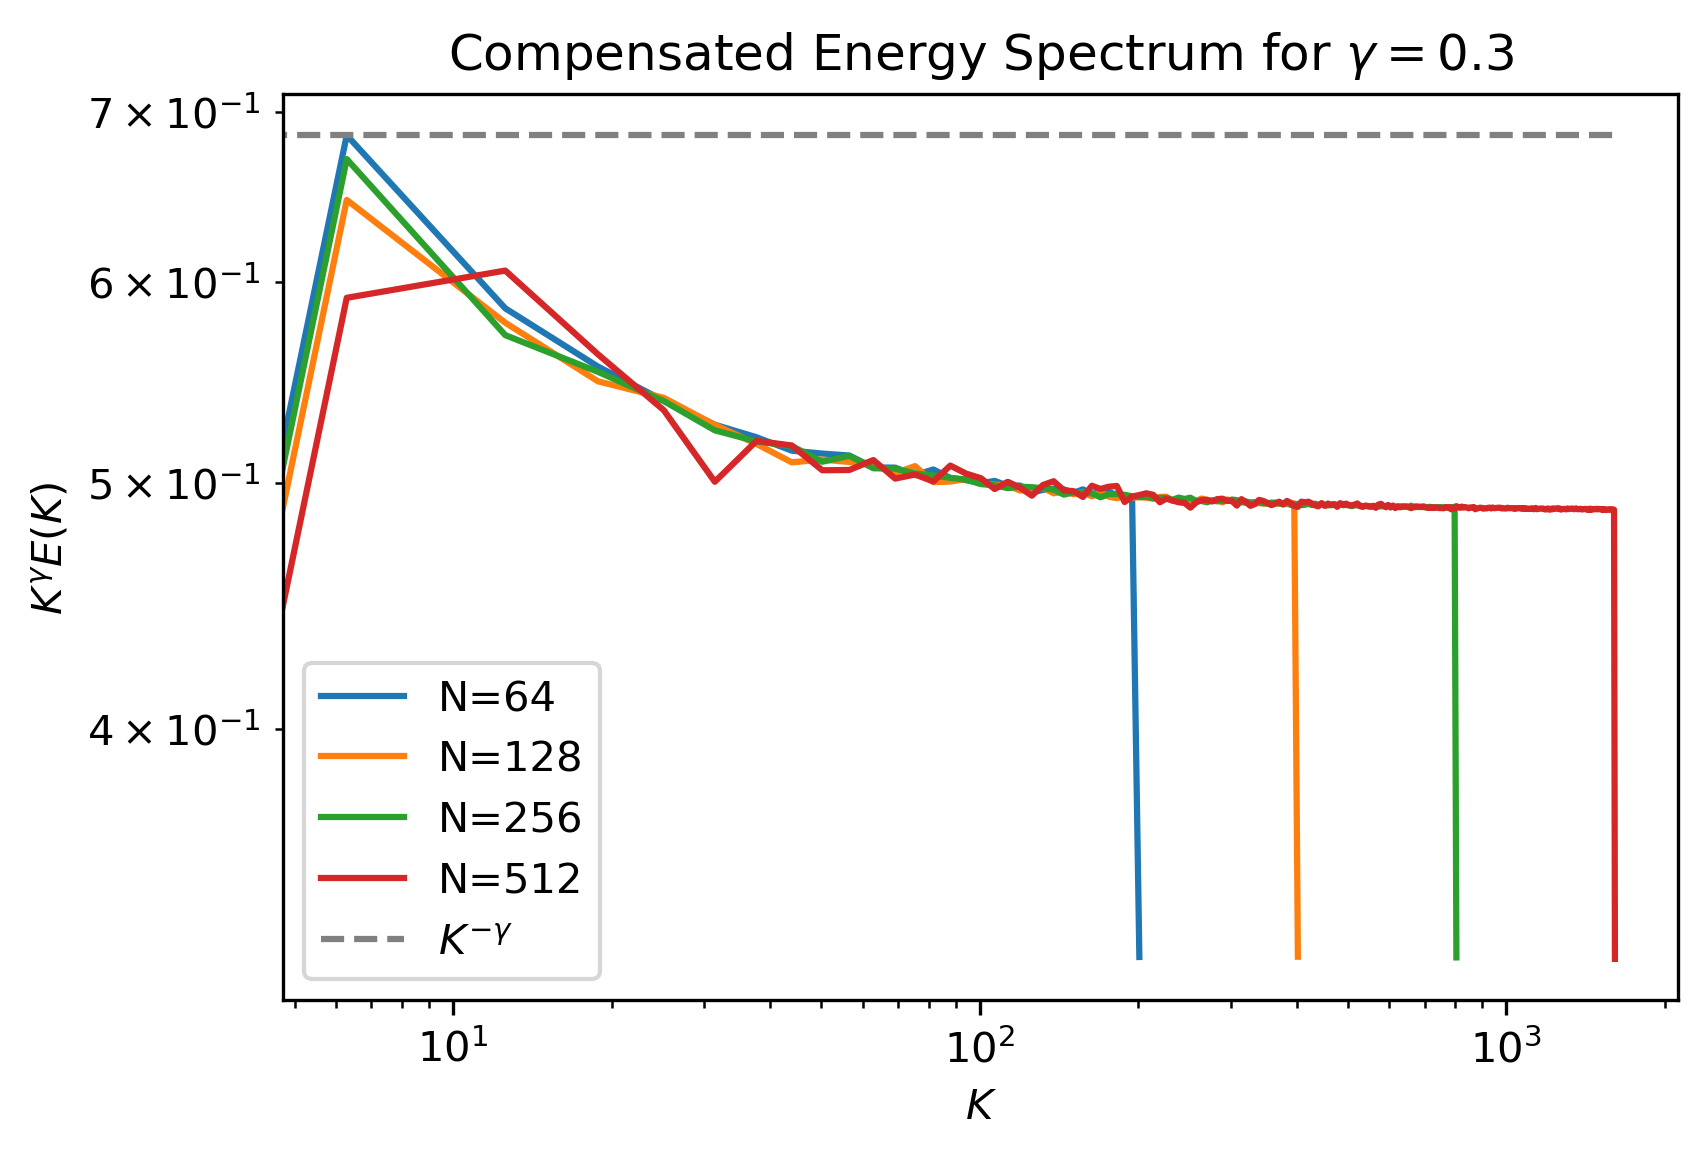

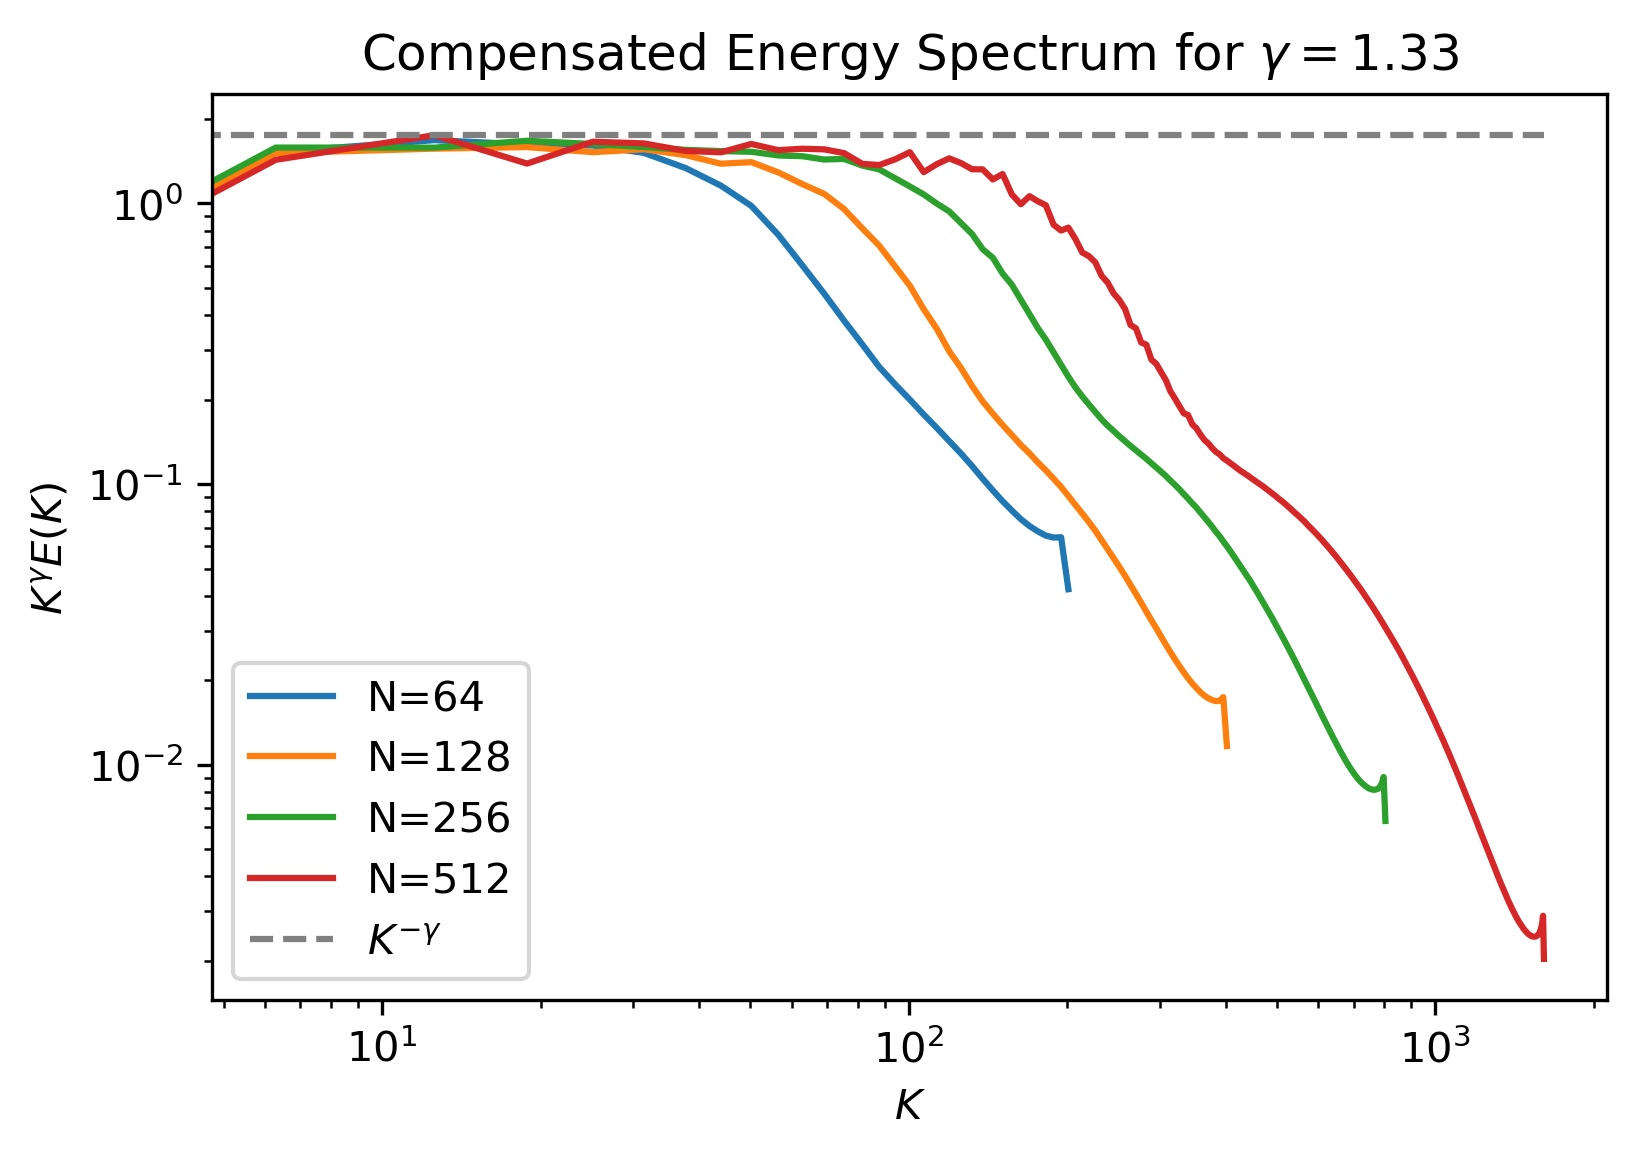

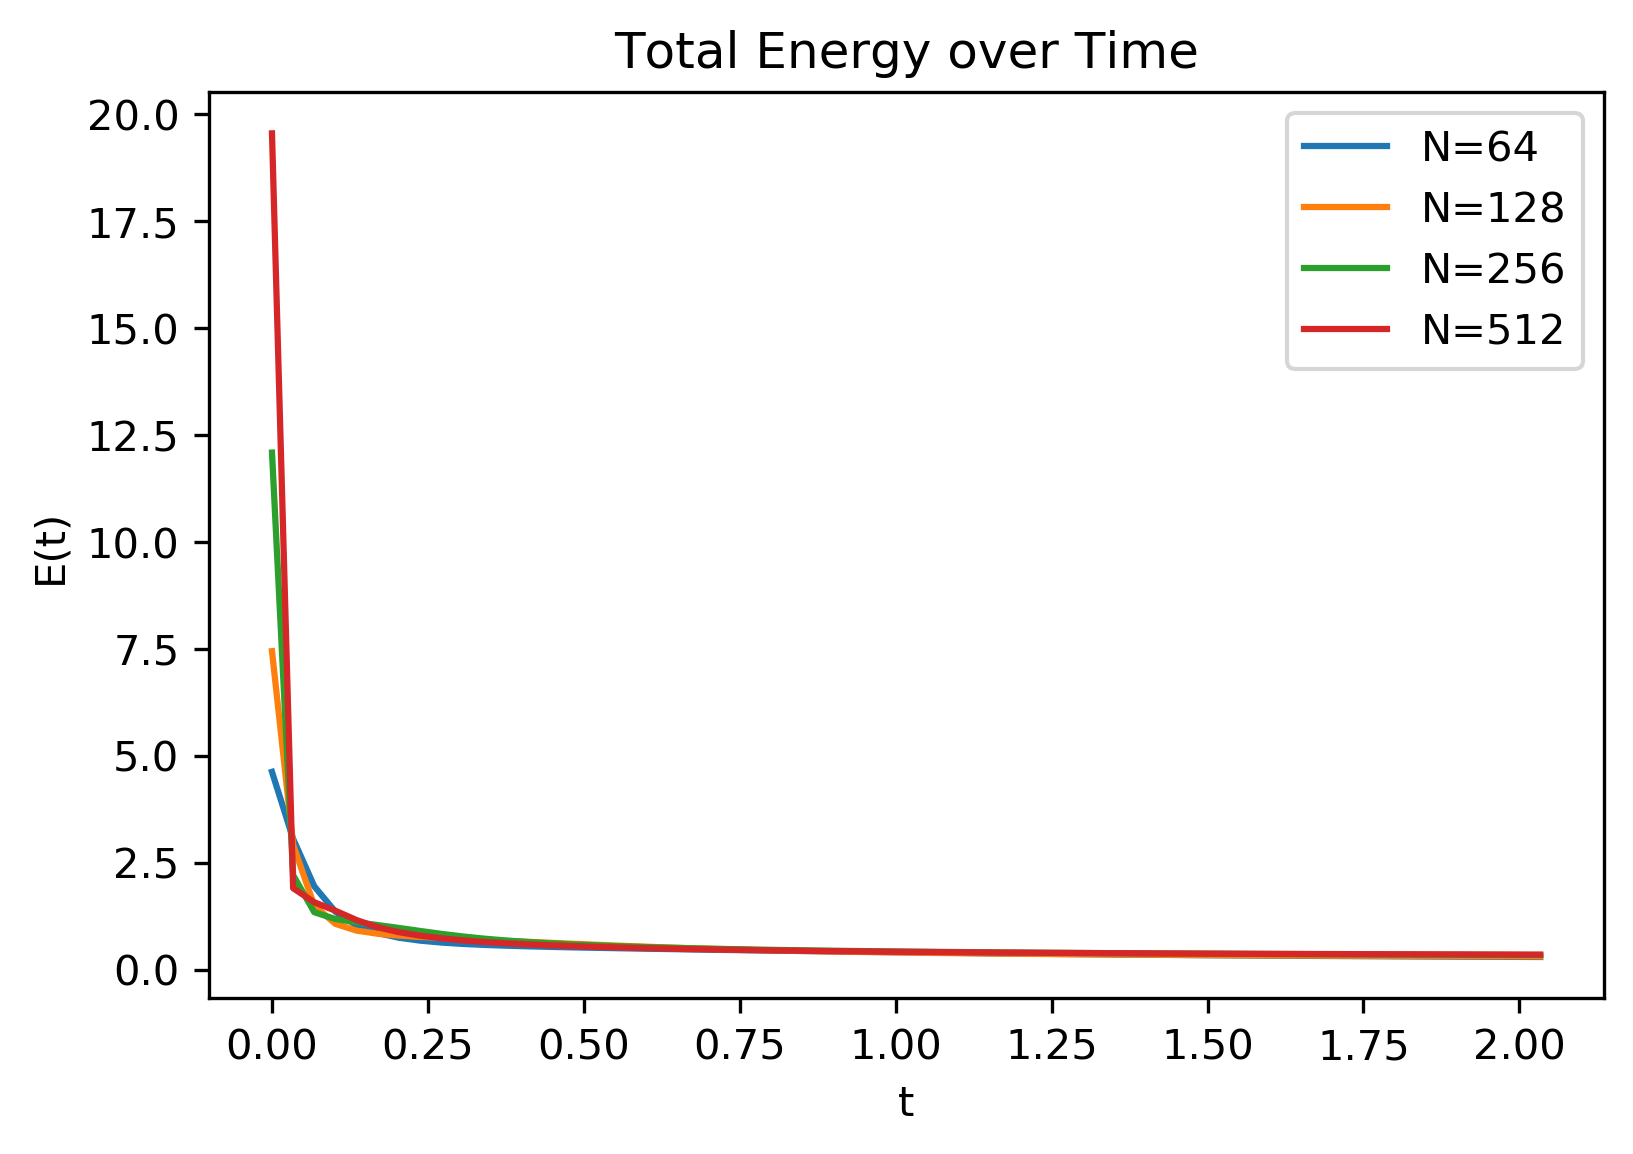

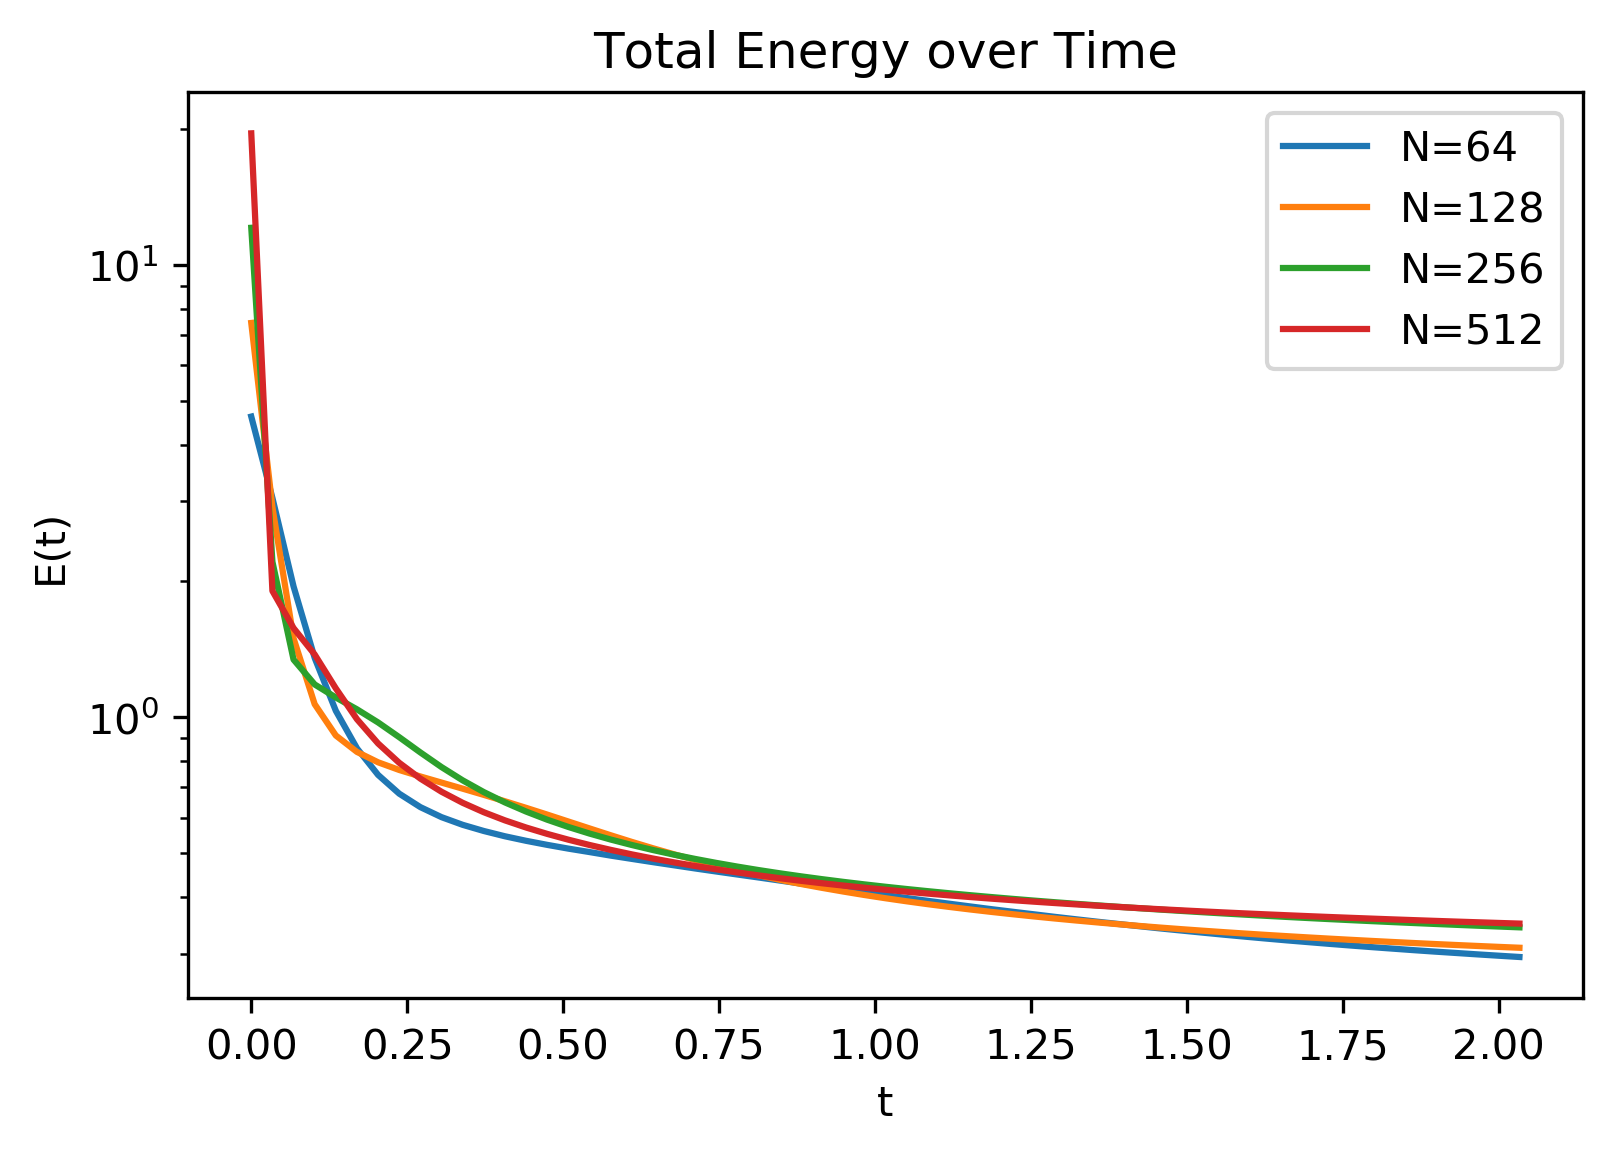

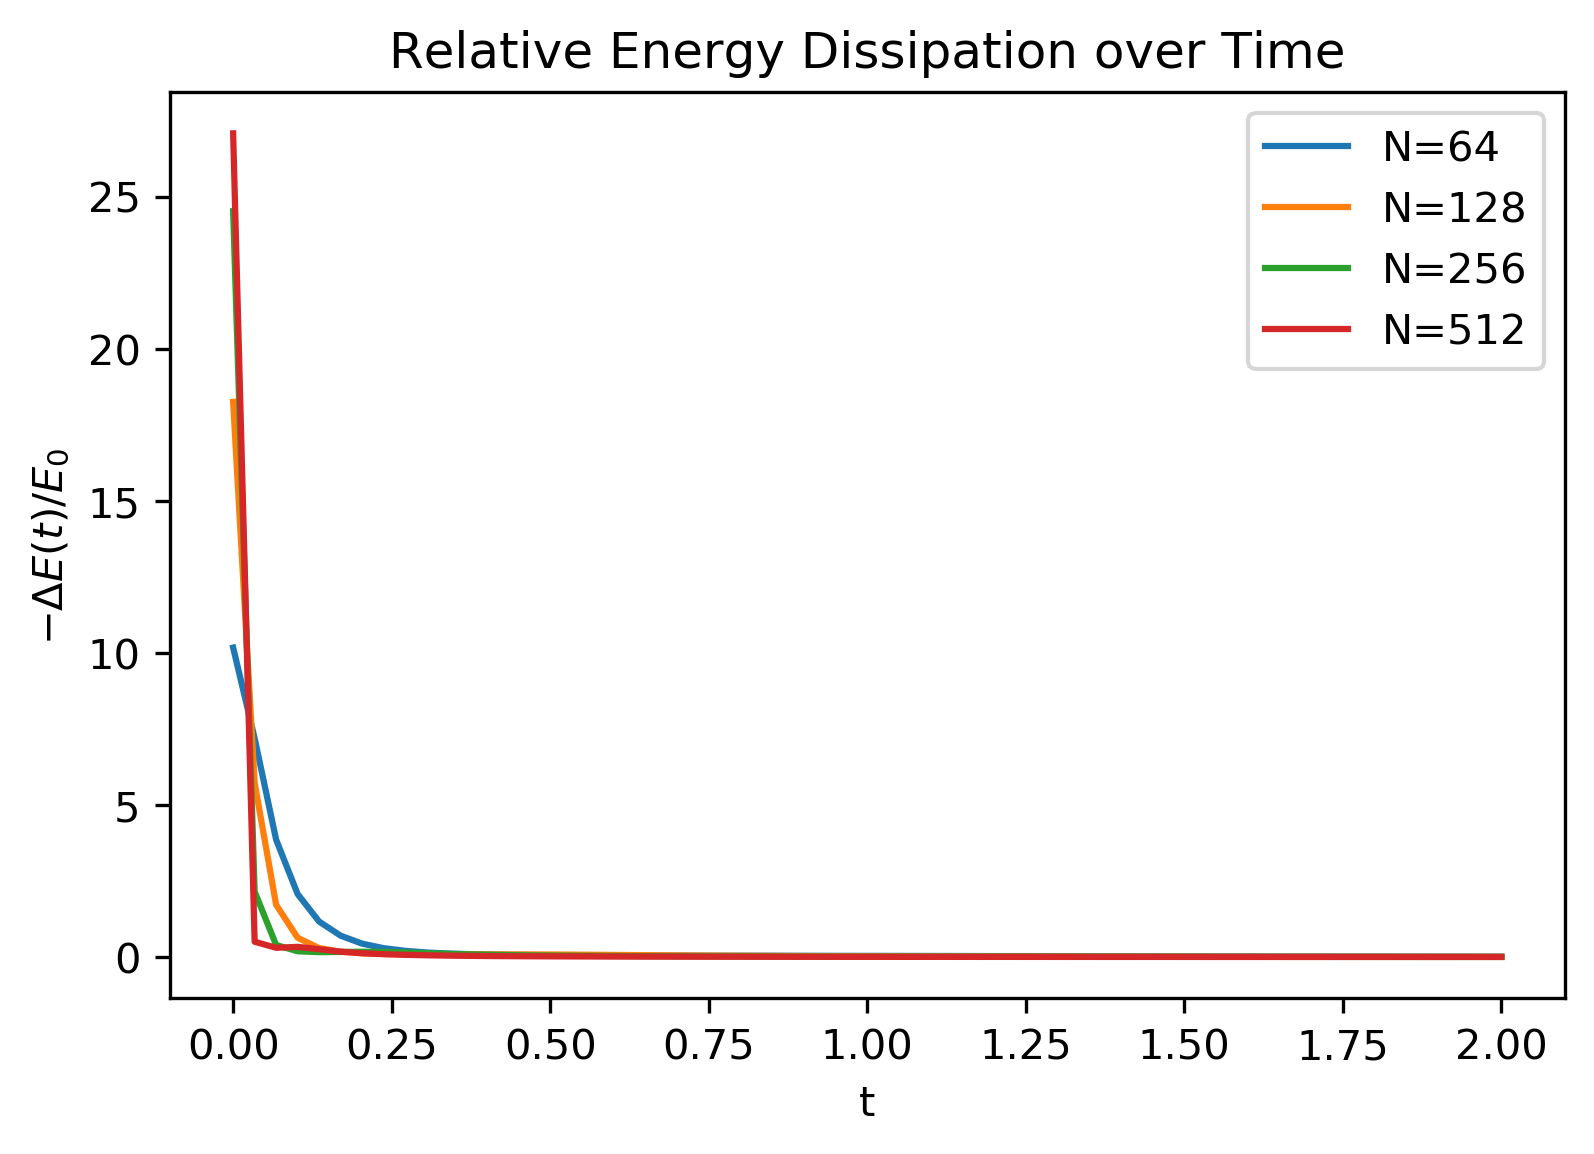

best fit found in interval [32, 59] with error 0.008116465602500579
best fit found in interval [44, 59] with error 0.008086105379929522
best fit found in interval [44, 59] with error 0.0030256570379087085
best fit found in interval [44, 59] with error 0.009663105714327918


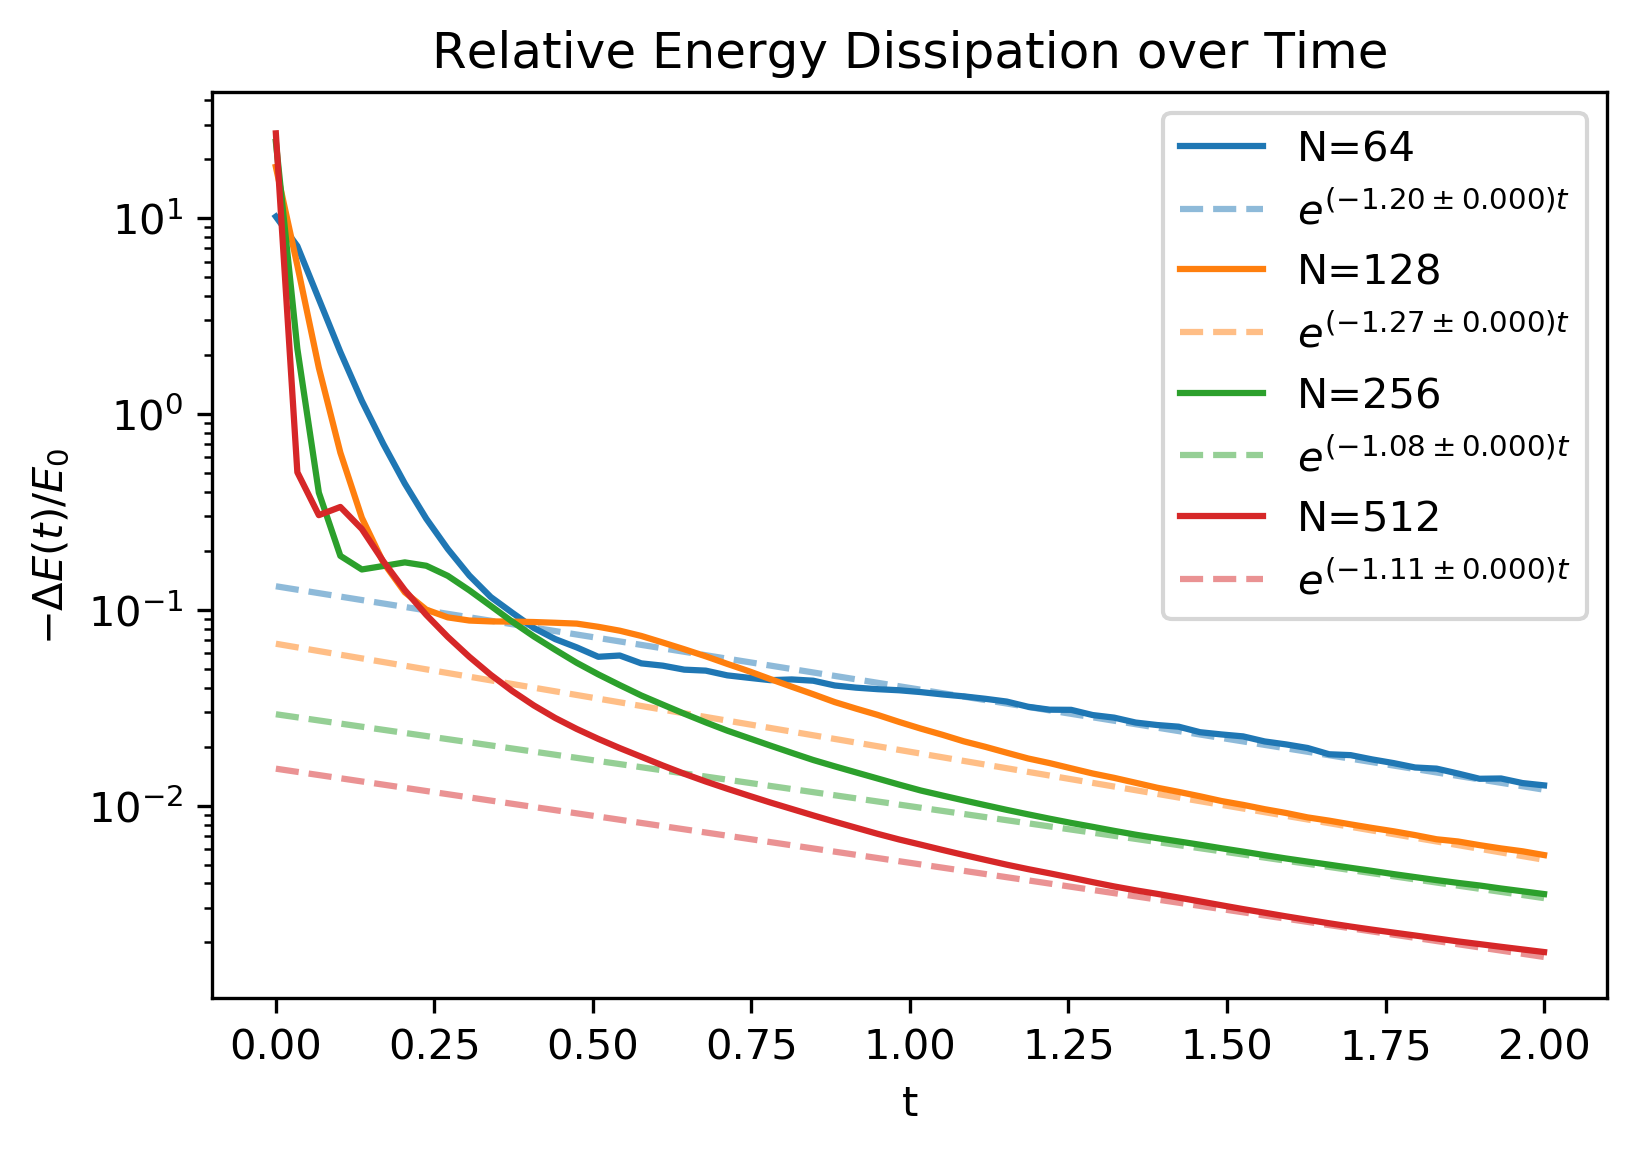

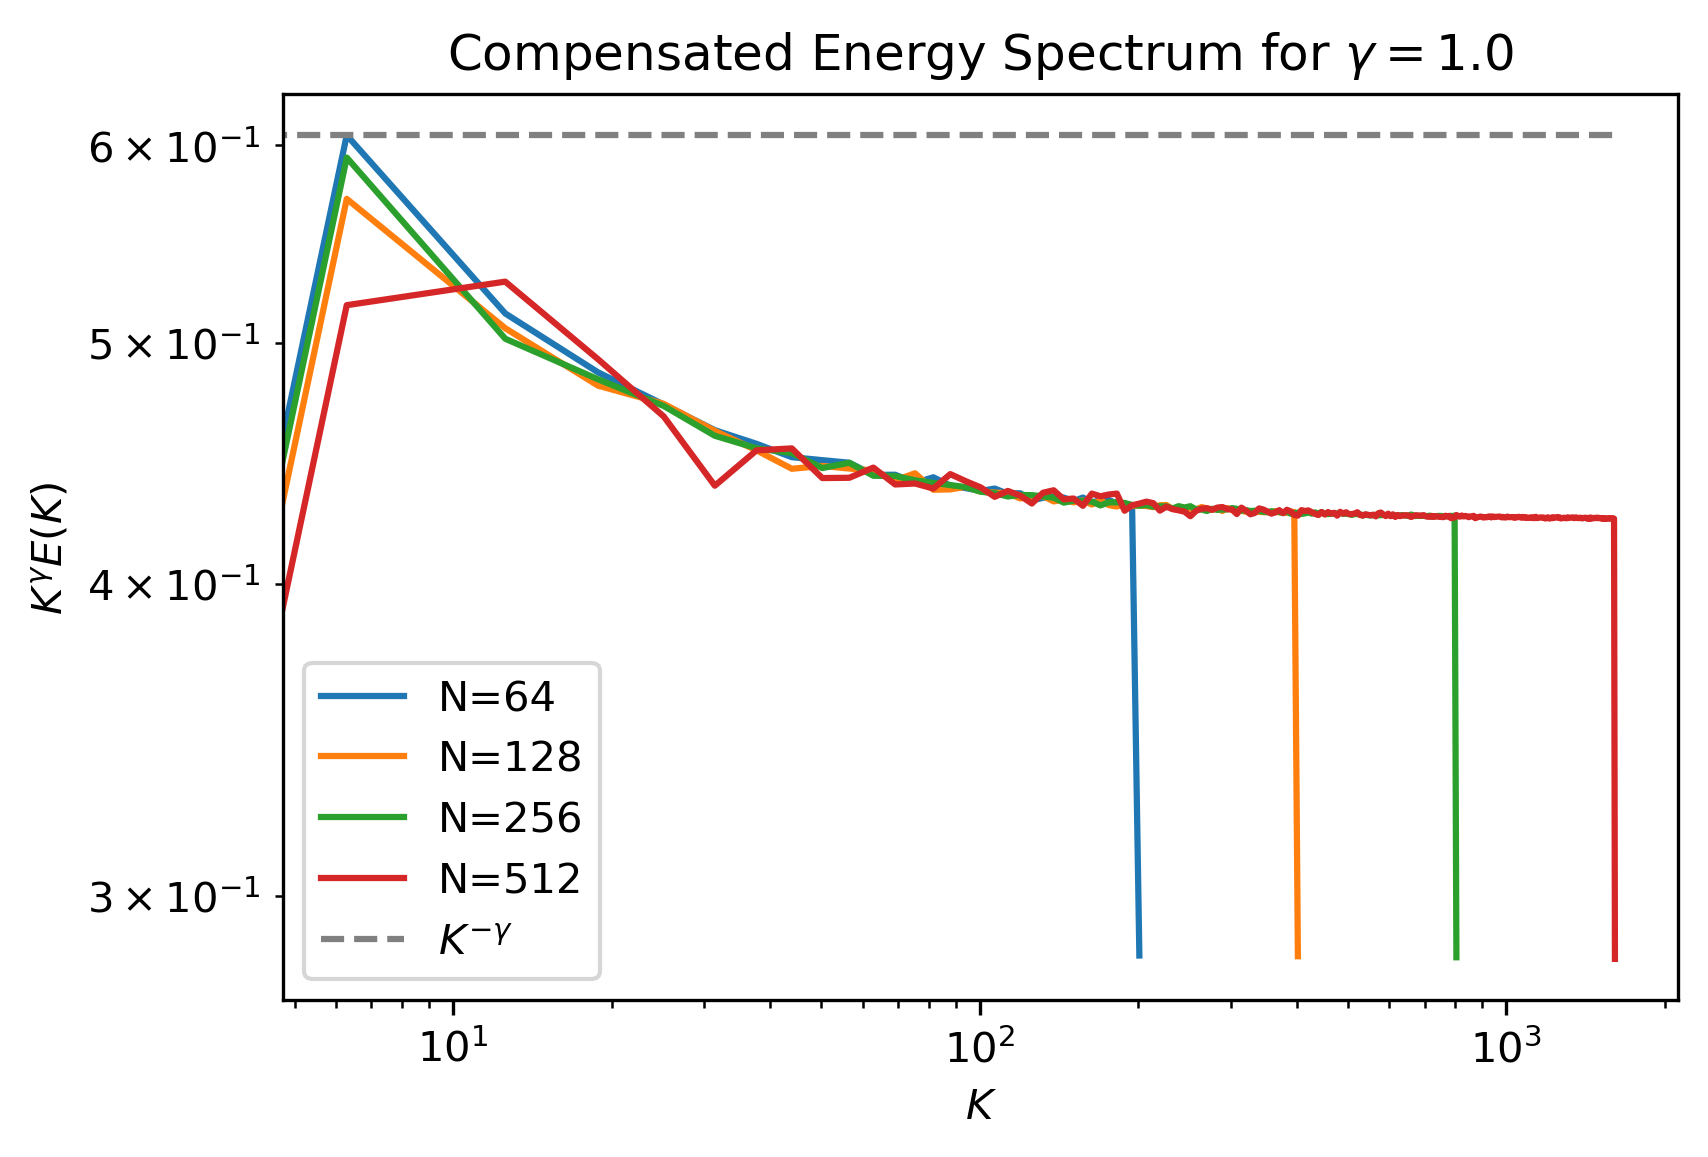

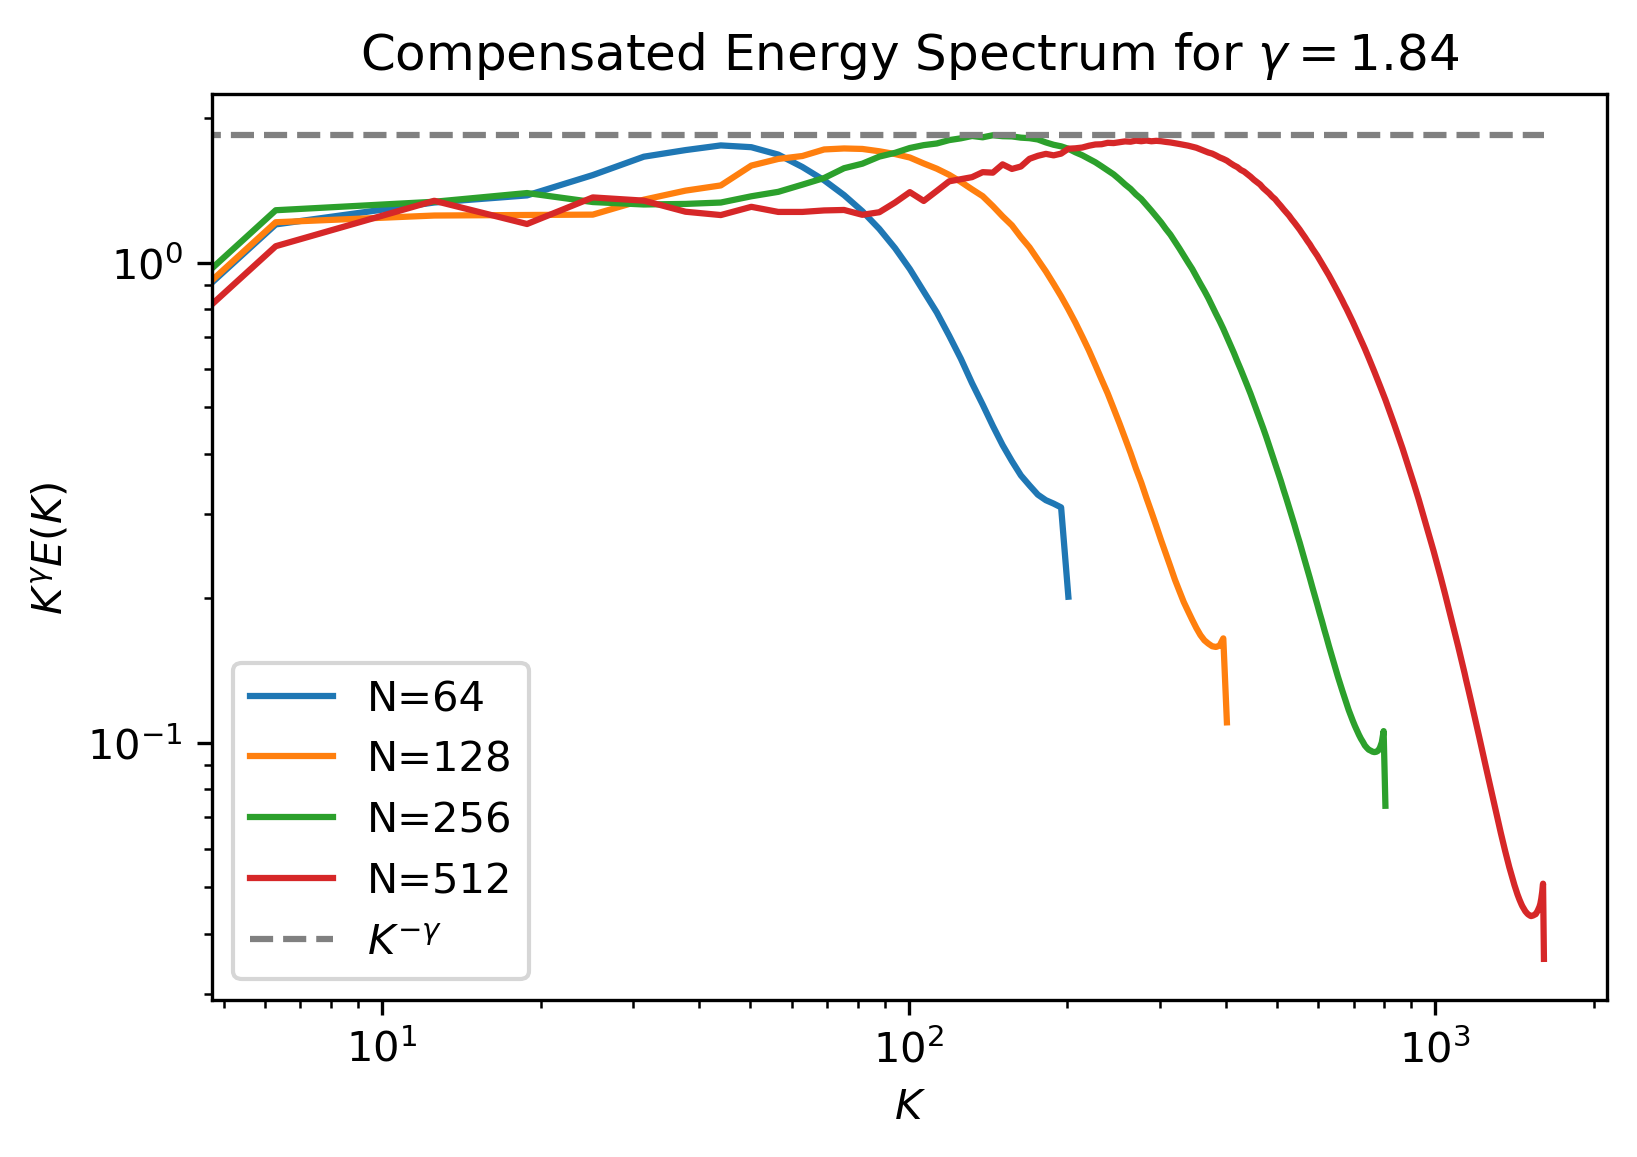

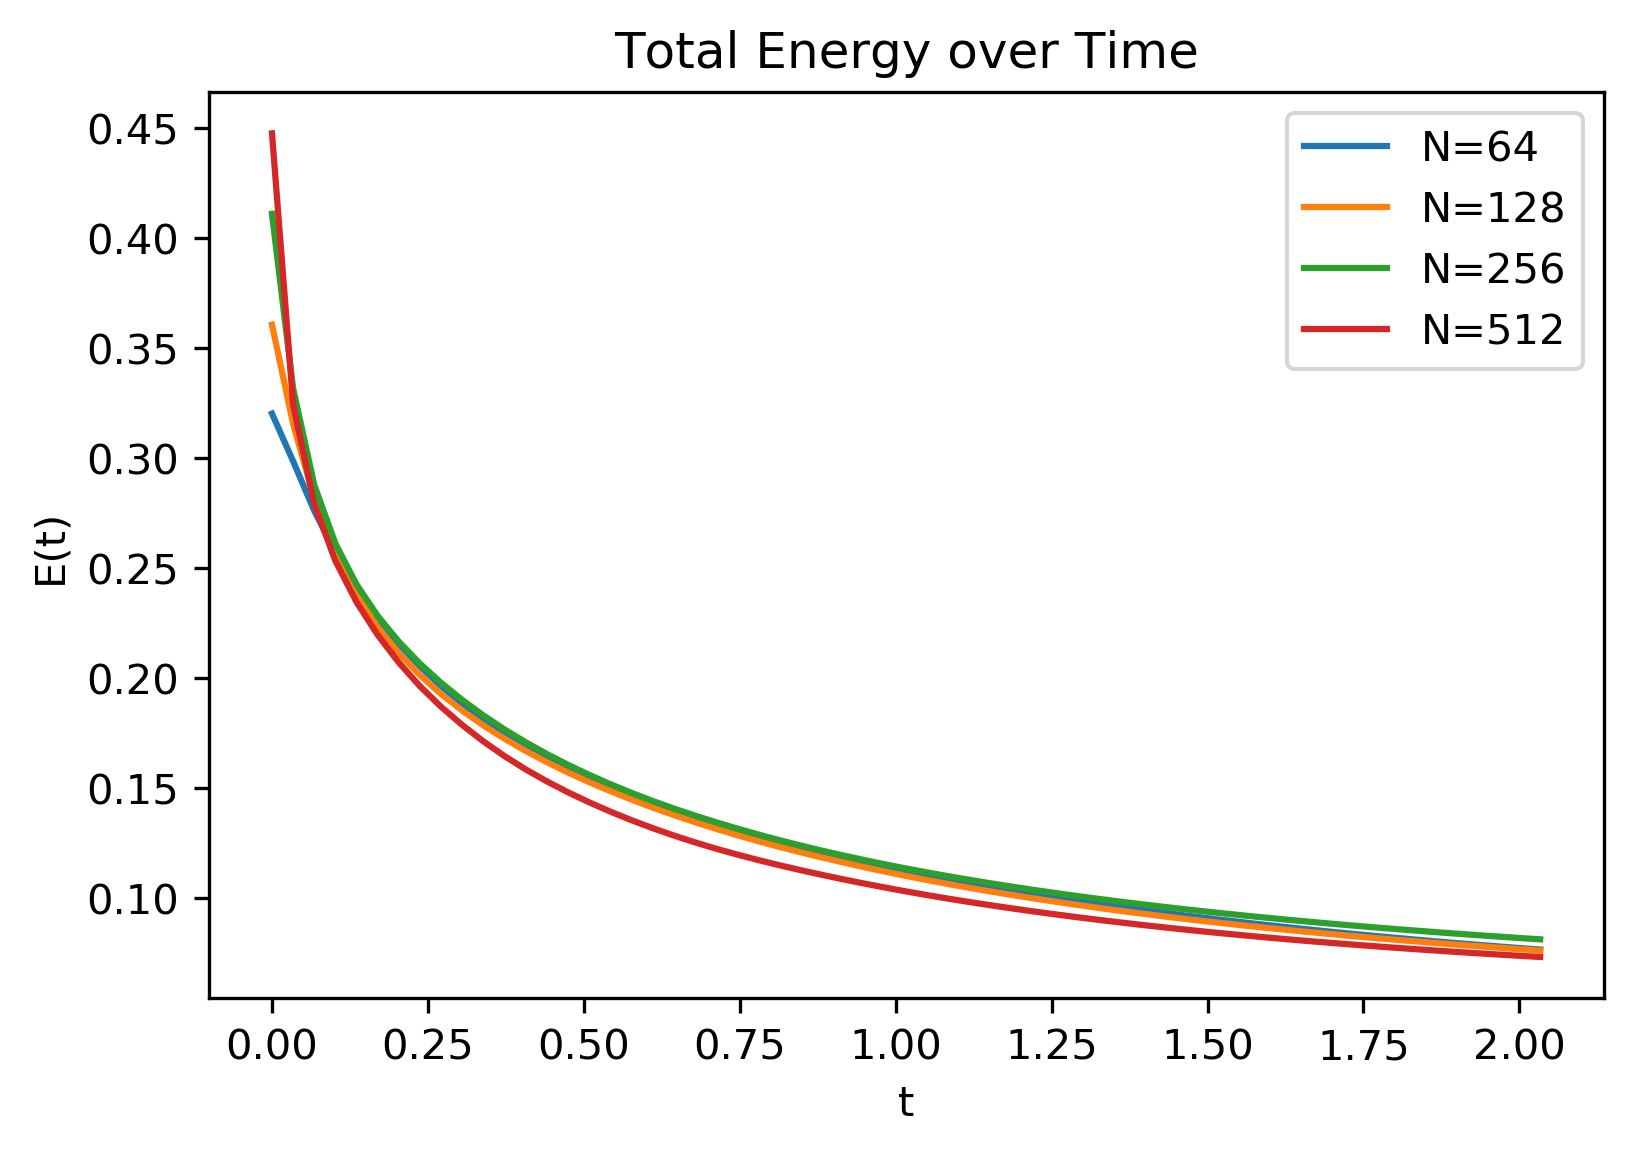

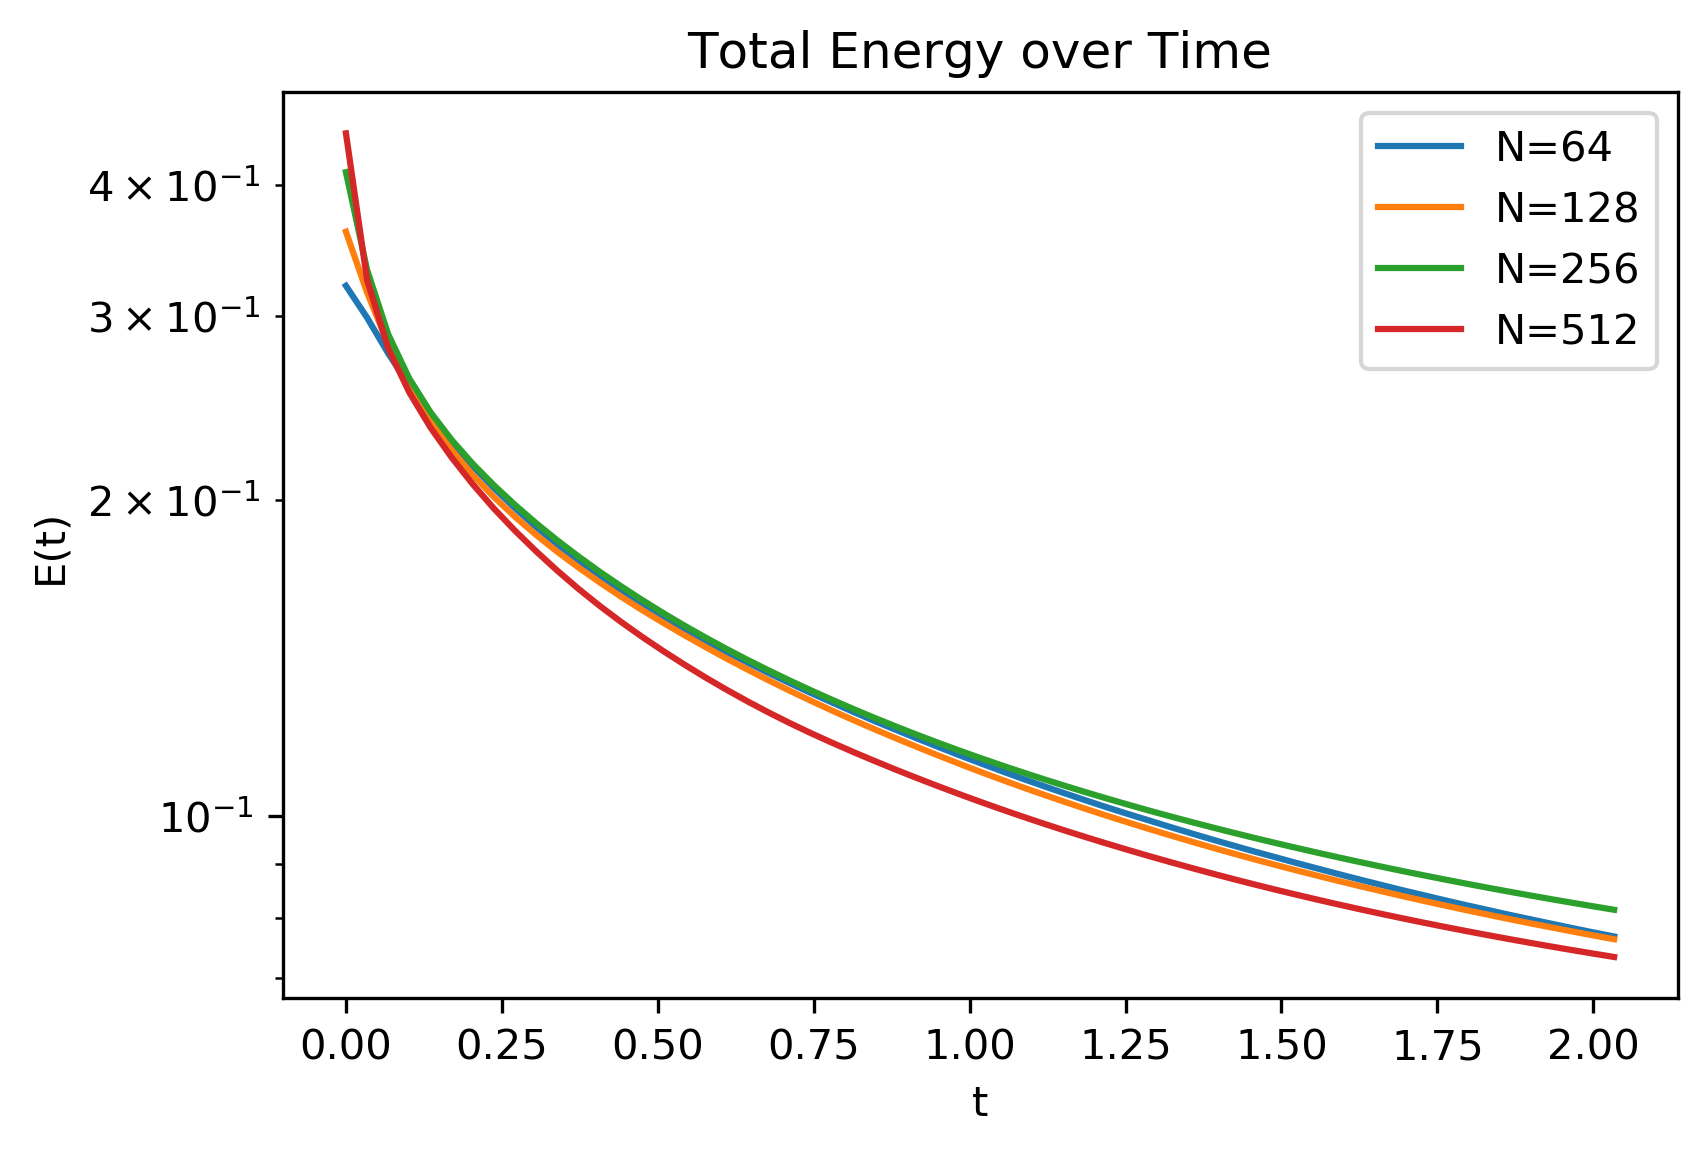

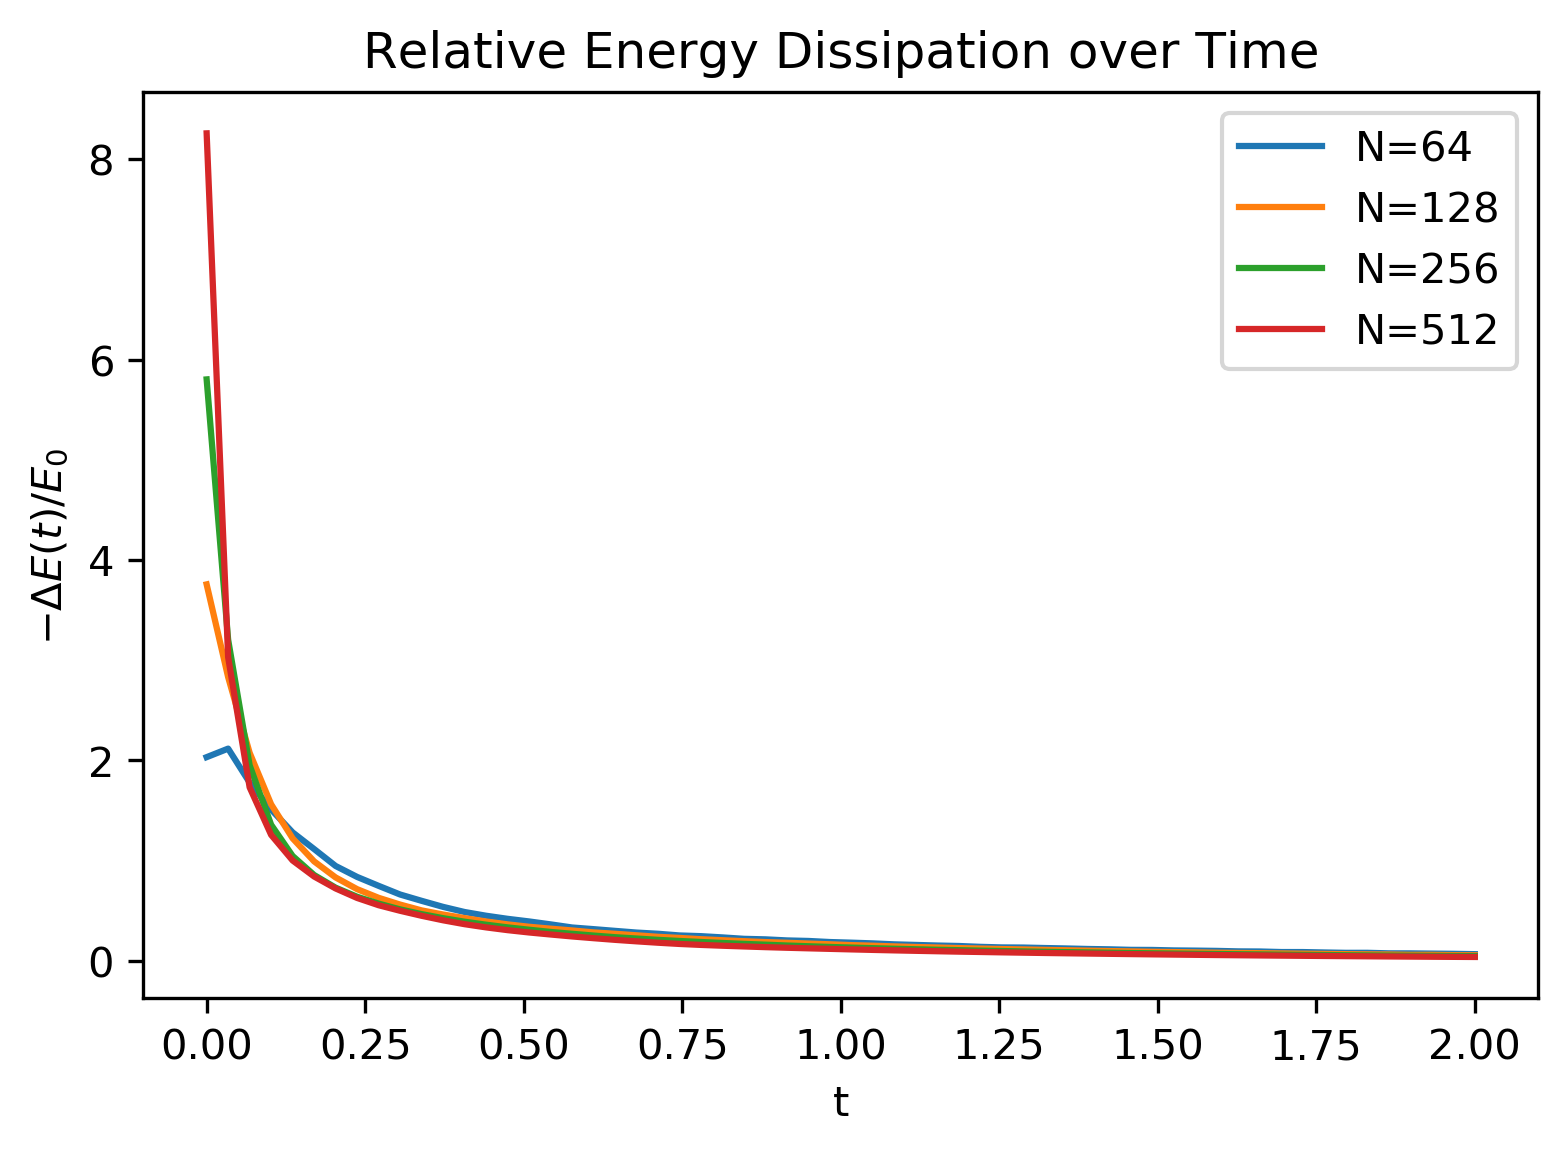

best fit found in interval [36, 59] with error 0.0062759354850976294
best fit found in interval [35, 59] with error 0.004942848048332999
best fit found in interval [44, 59] with error 0.001365774394138306
best fit found in interval [44, 59] with error 0.0009252144047827926


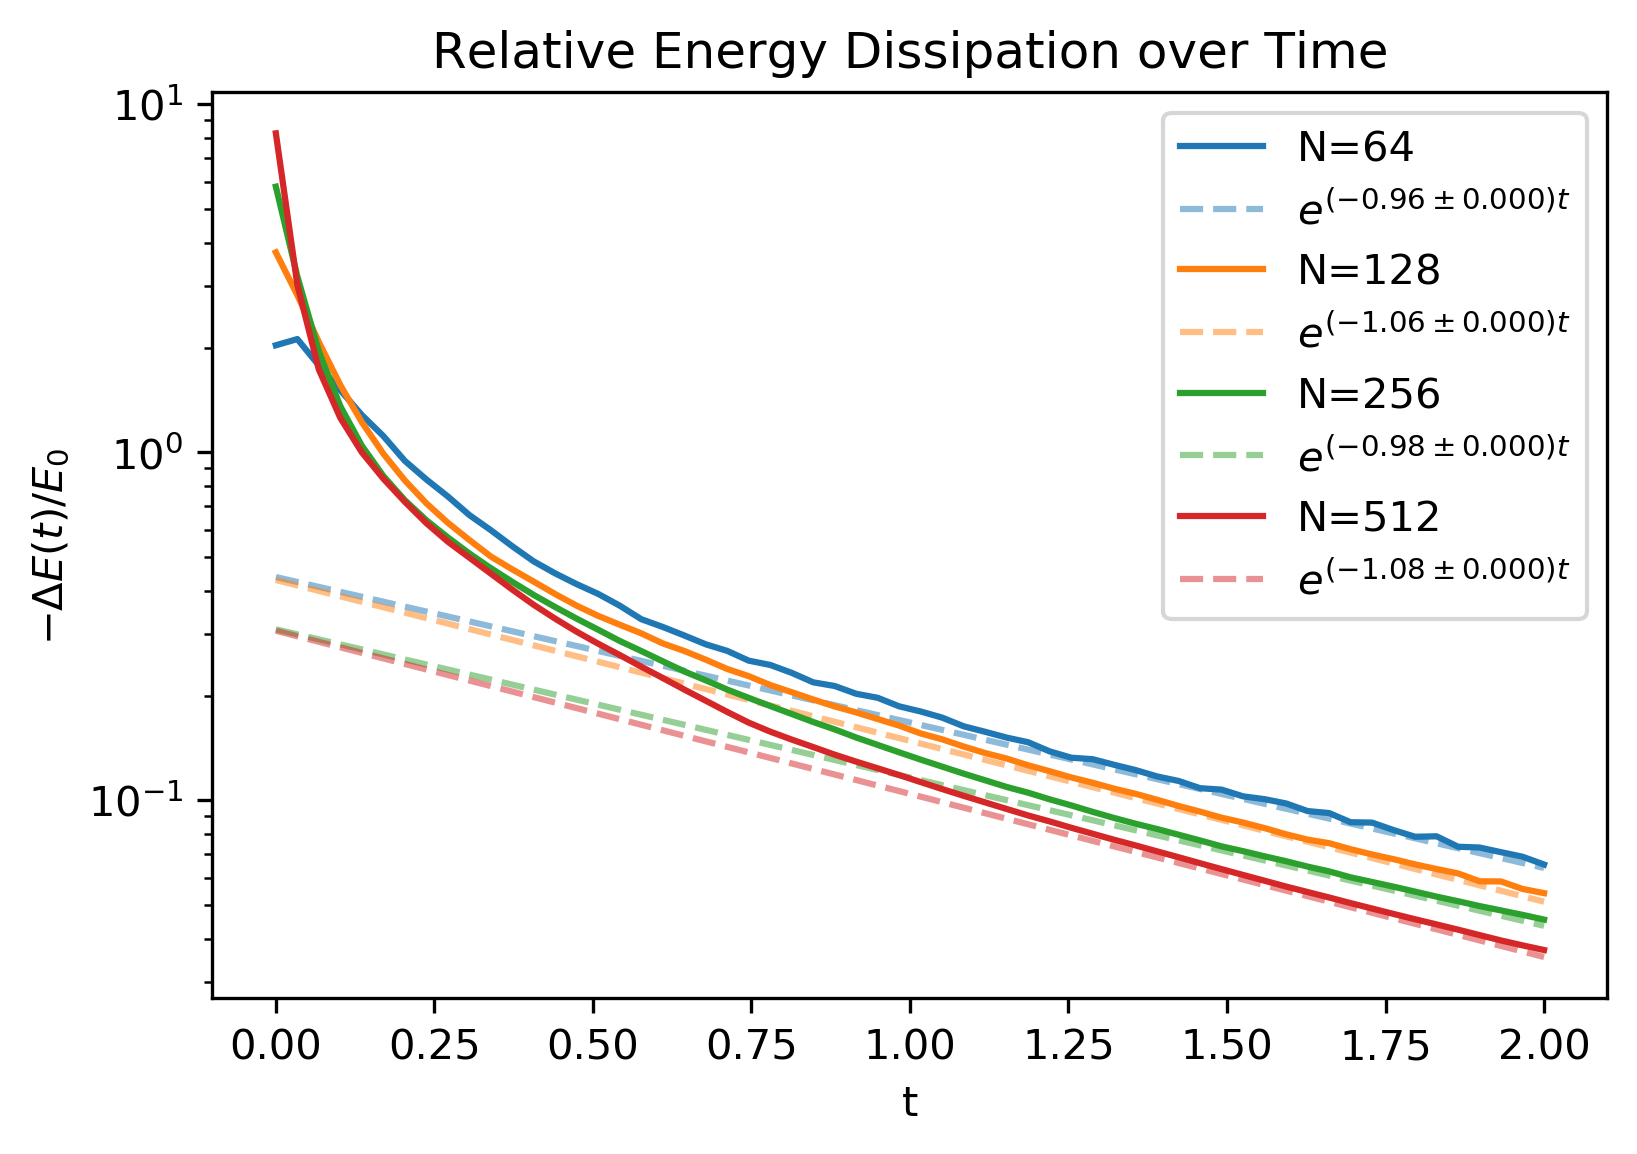

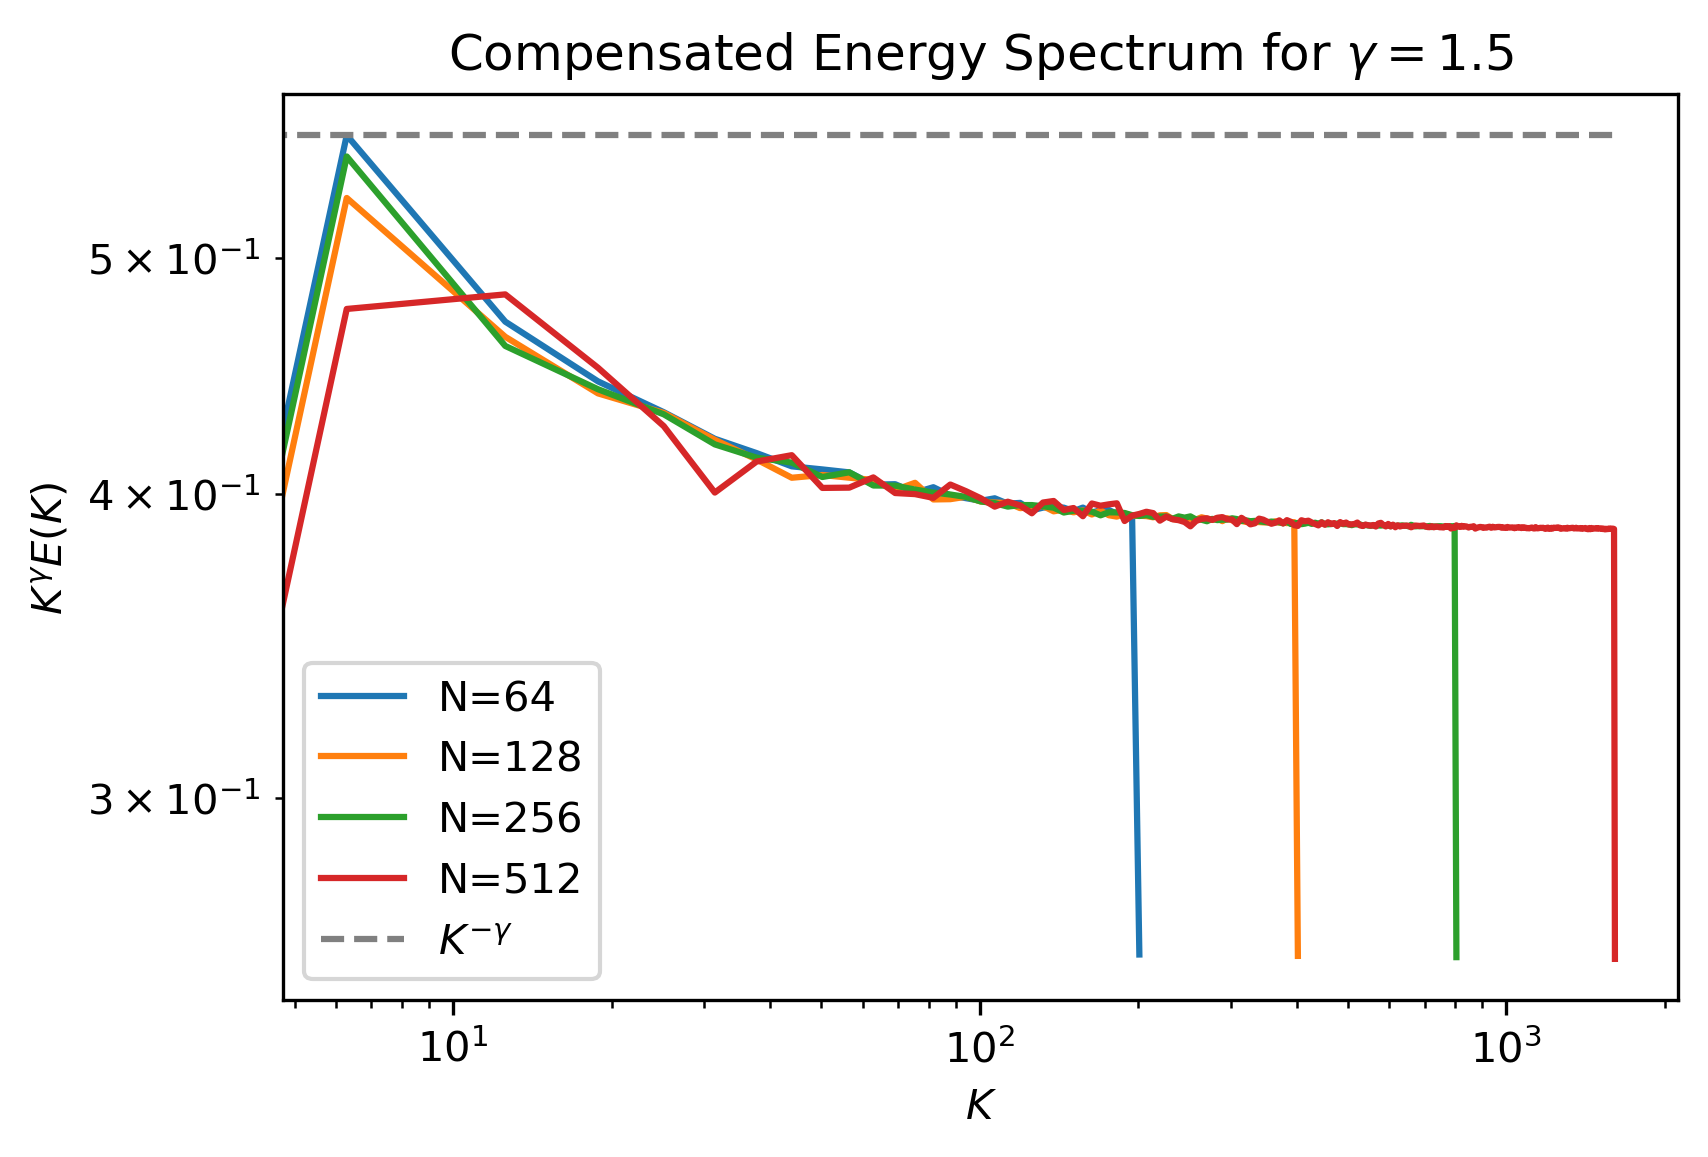

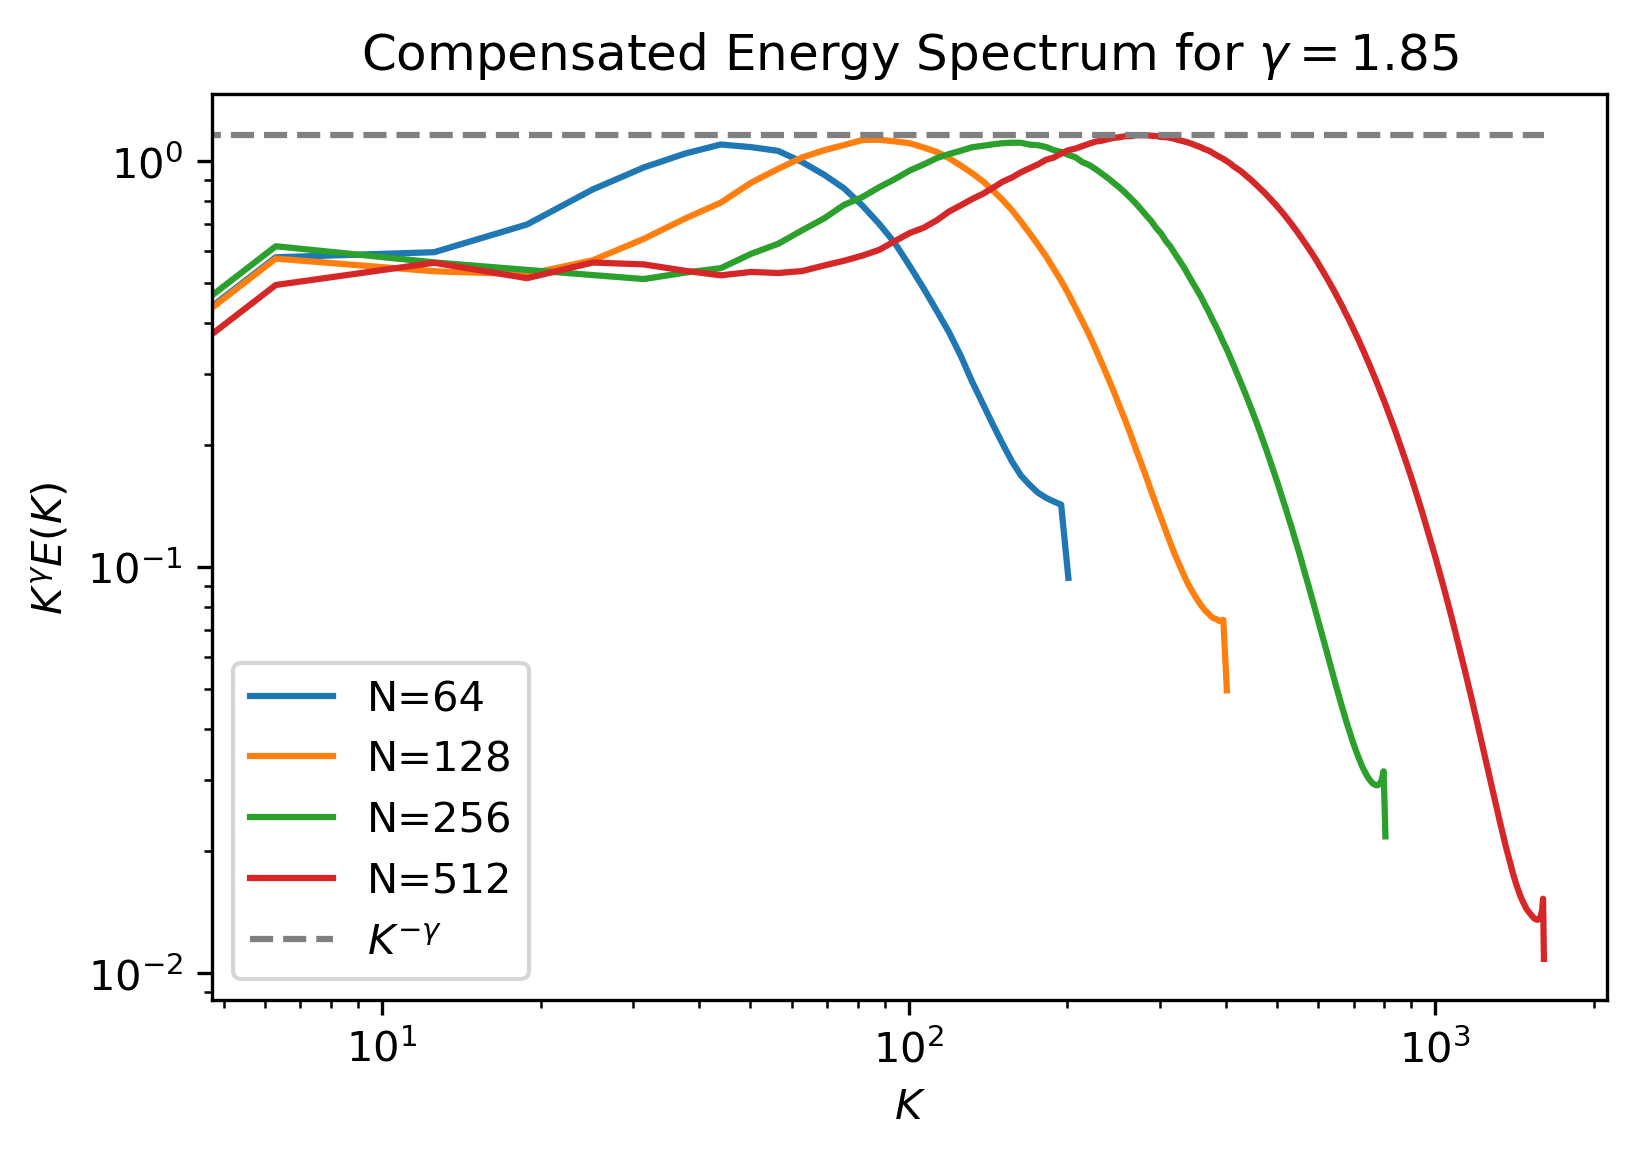

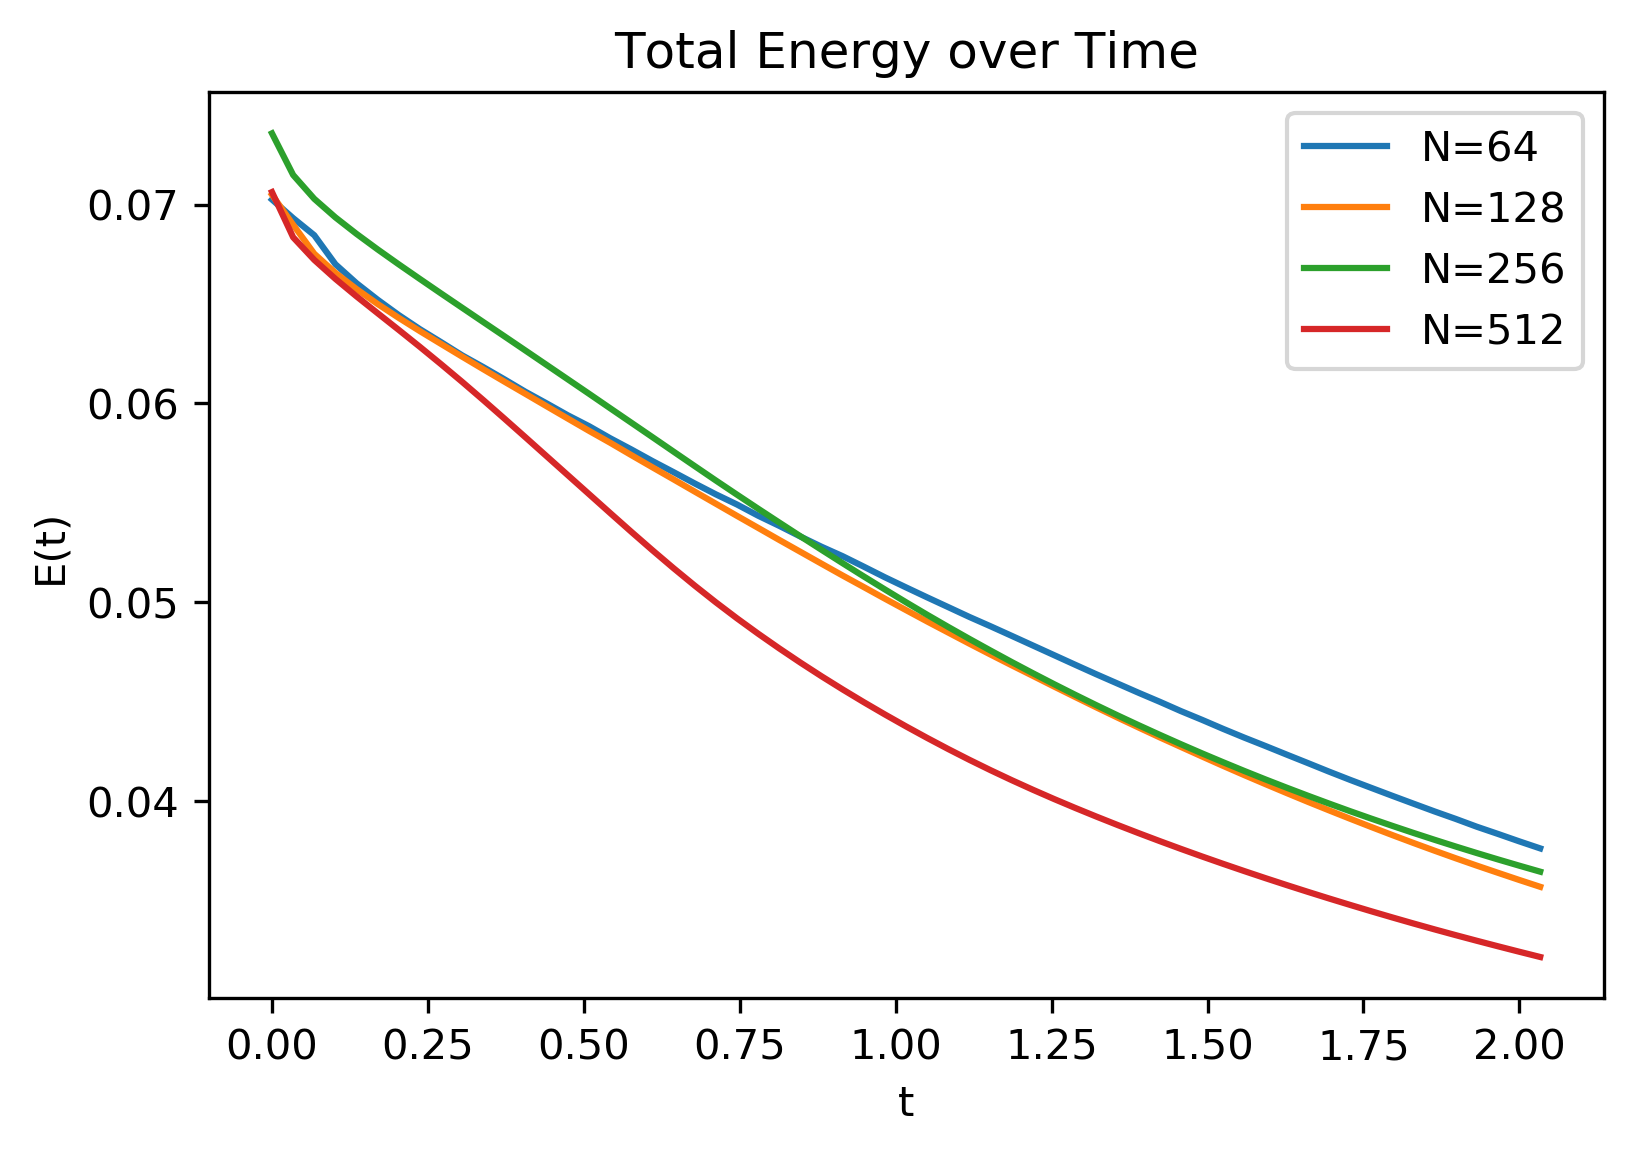

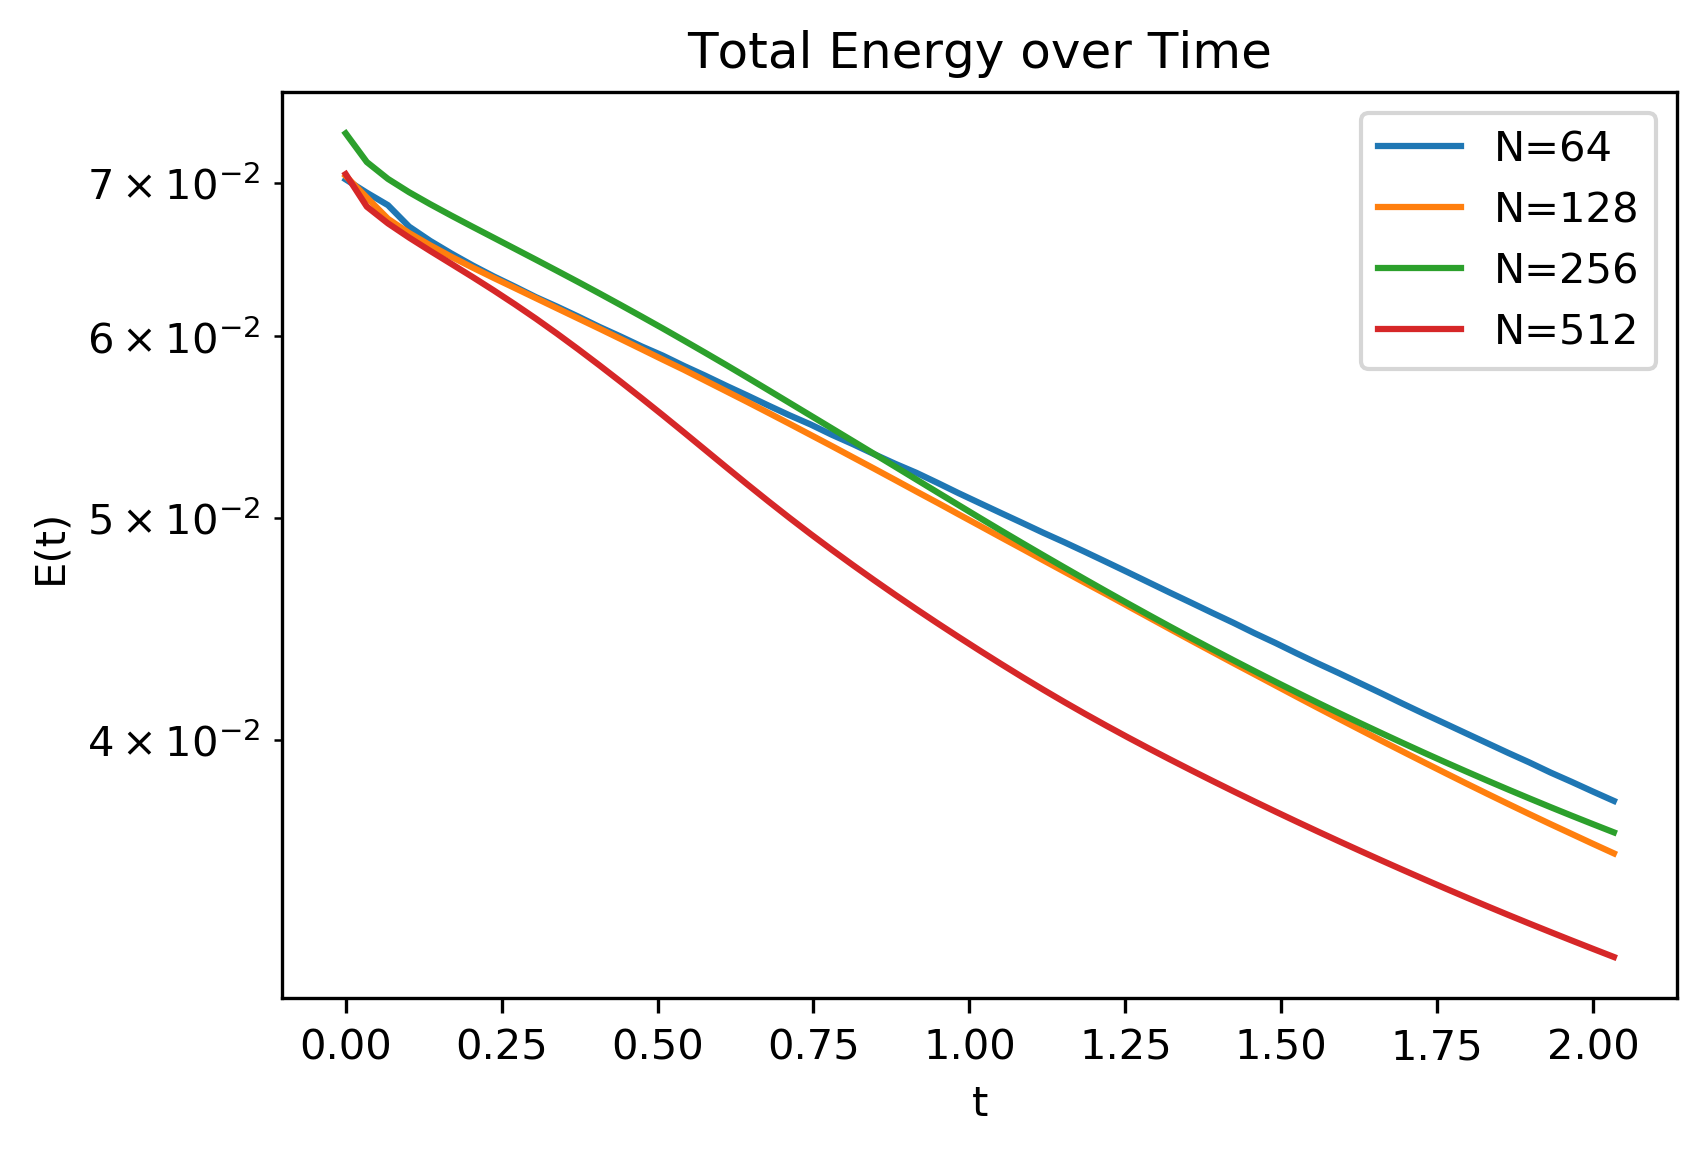

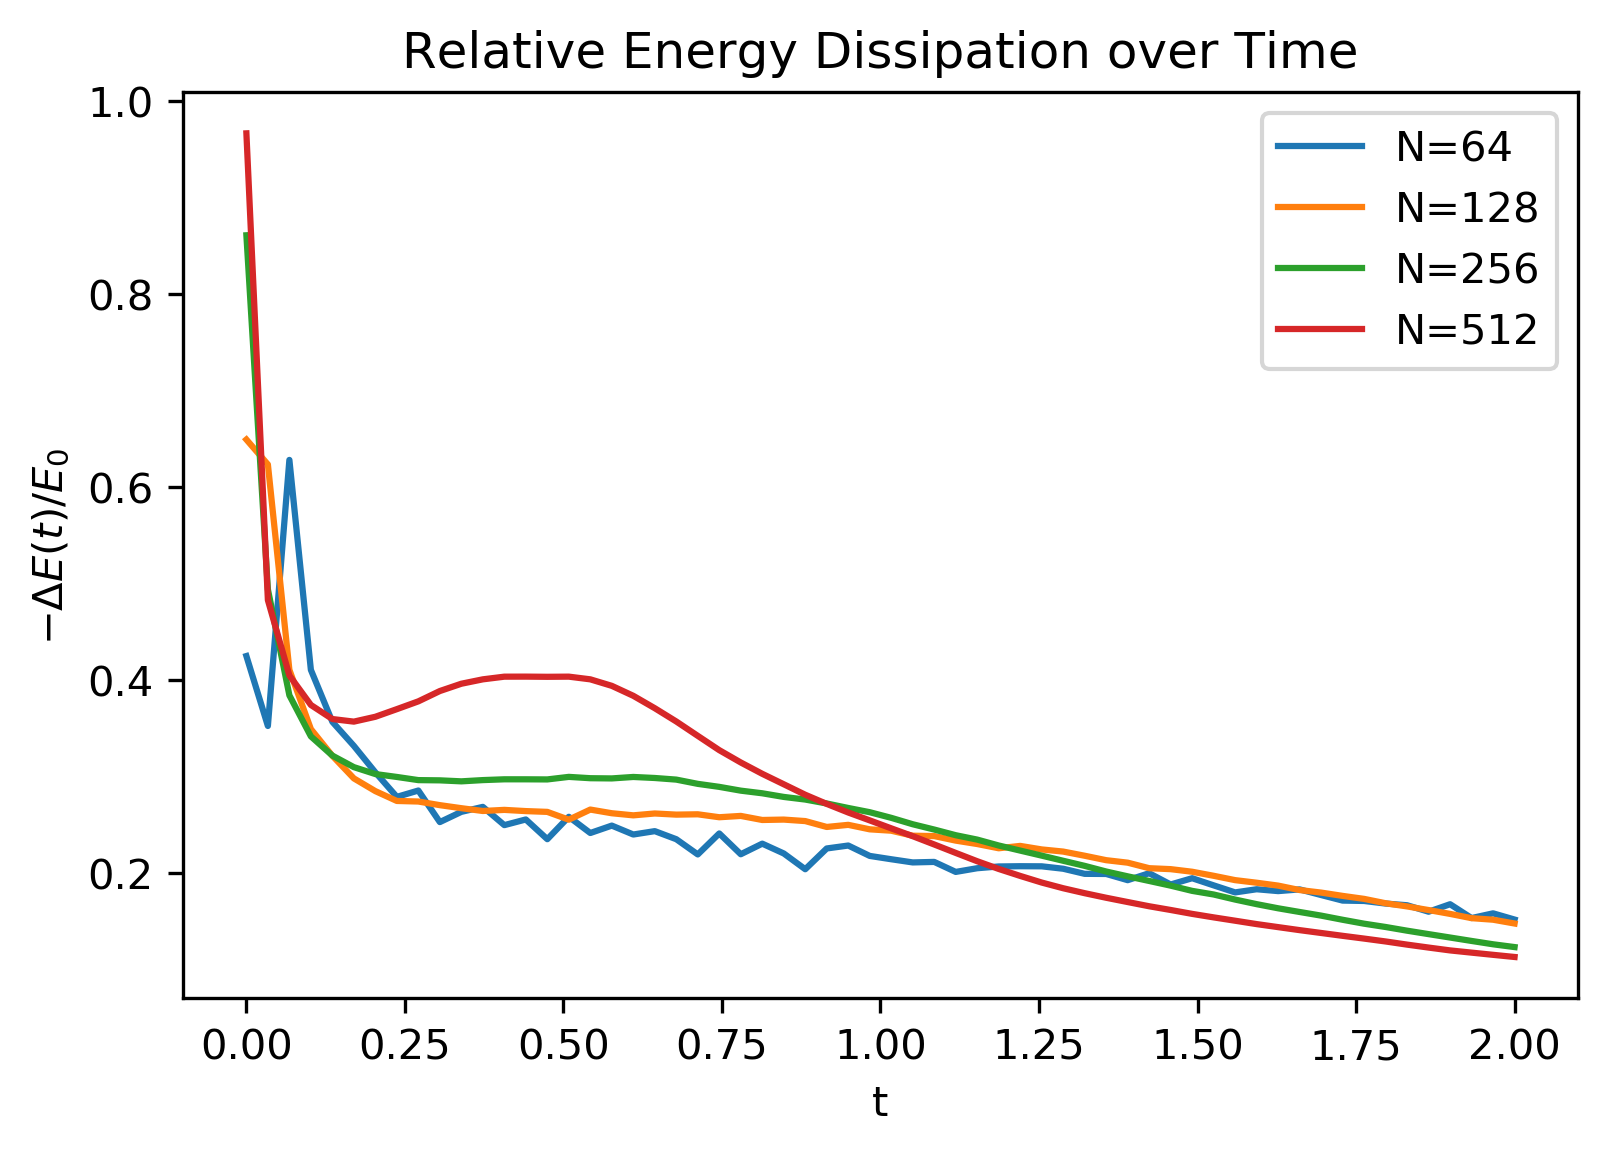

best fit found in interval [7, 59] with error 0.010475334958548037
best fit found in interval [43, 59] with error 0.0033059698848183225
best fit found in interval [37, 59] with error 0.0001178566306265863
best fit found in interval [42, 59] with error 0.000392955319570692


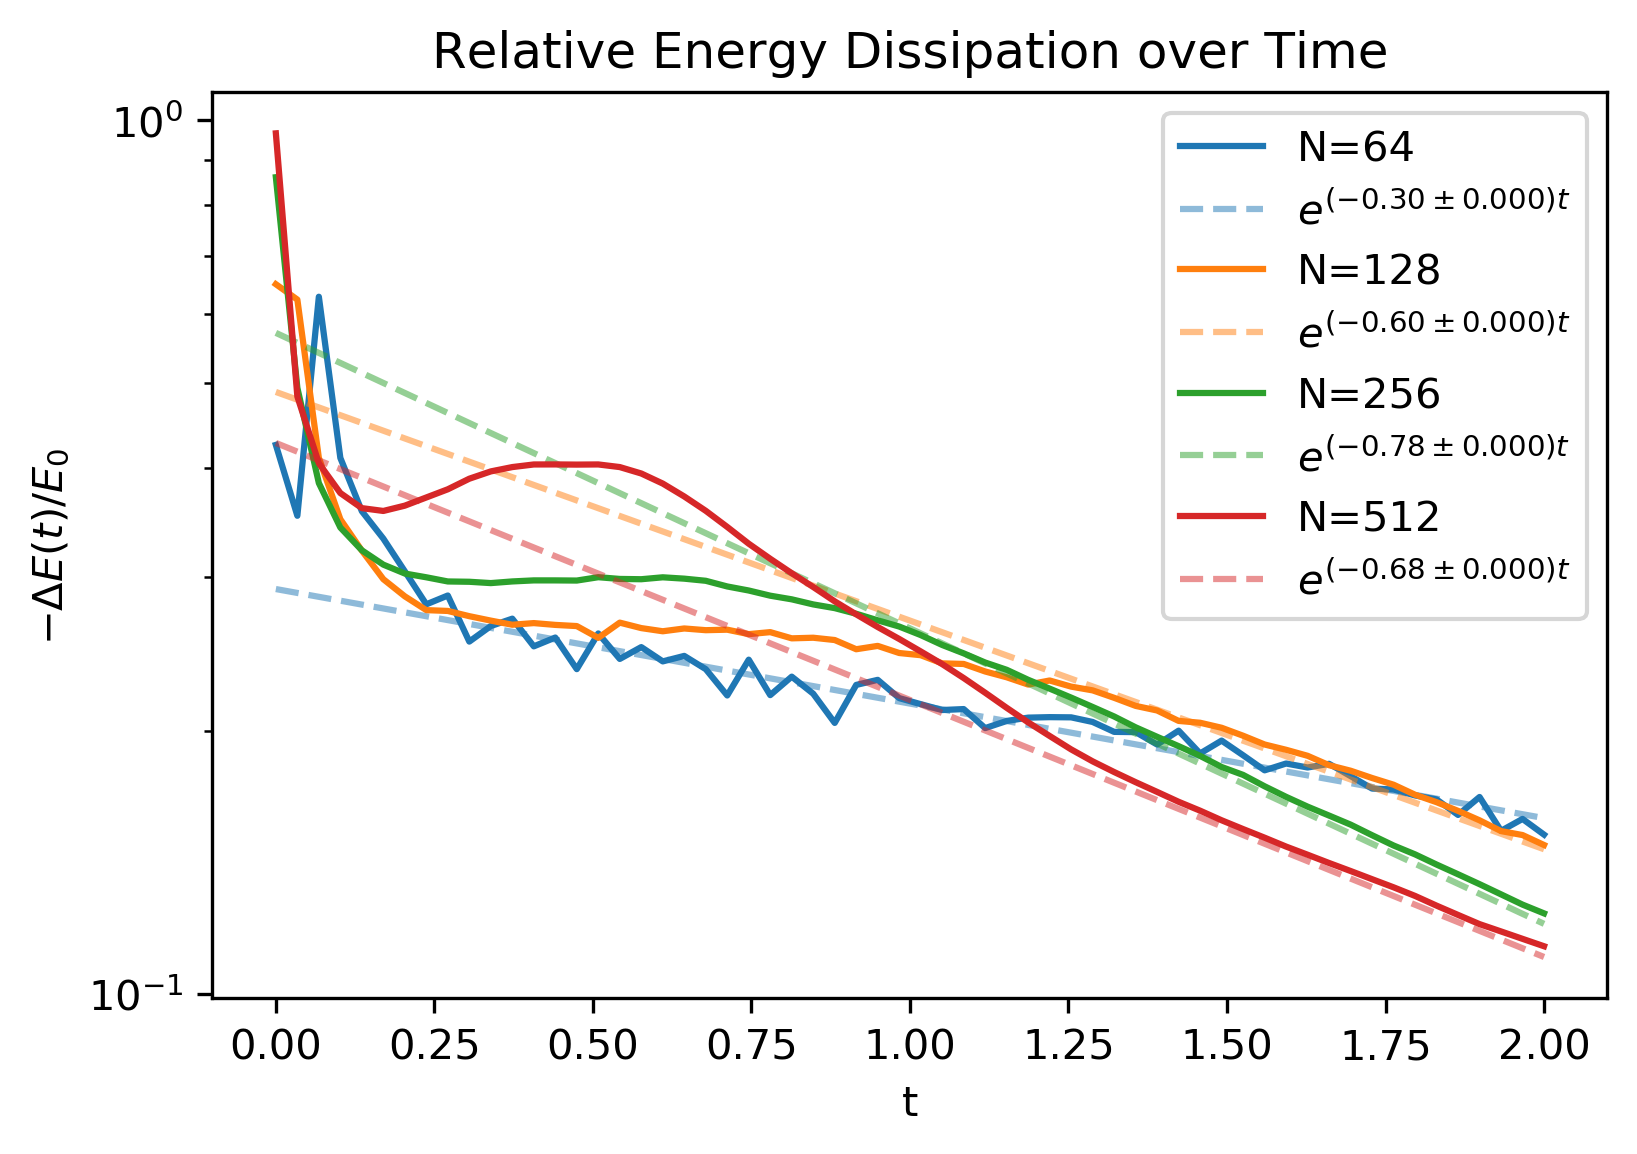

In [6]:
for H,g0,g1,fi in [(15,0.3,4/3,[1,2]), (50,1.,1.84,[1,2]), (75,1.5,1.85,[1,2])]:
    plot_spectrum([f'{experiment_folder}/bm_H{H}_N64',
                   f'{experiment_folder}/bm_H{H}_N128',
                   f'{experiment_folder}/bm_H{H}_N256',
                   f'{experiment_folder}/bm_H{H}_N512'],
                  [64, 128, 256, 512], 0, g0,
                  save_name=f'{experiment_folder}/bm_H{H}_energy_spectrum_t0.png')
    plot_spectrum([f'{experiment_folder}/bm_H{H}_N64',
                   f'{experiment_folder}/bm_H{H}_N128',
                   f'{experiment_folder}/bm_H{H}_N256',
                   f'{experiment_folder}/bm_H{H}_N512'],
                  [64, 128, 256, 512], 60, g1,
                  save_name=f'{experiment_folder}/bm_H{H}_energy_spectrum_t2.png')
    plot_energy([f'{experiment_folder}/bm_H{H}_N64',
                 f'{experiment_folder}/bm_H{H}_N128',
                 f'{experiment_folder}/bm_H{H}_N256',
                 f'{experiment_folder}/bm_H{H}_N512'],
                [64, 128, 256, 512], 2/60,
                save_name=f'{experiment_folder}/bm_H{H}_total_energy.png')
    plot_energy([f'{experiment_folder}/bm_H{H}_N64',
                 f'{experiment_folder}/bm_H{H}_N128',
                 f'{experiment_folder}/bm_H{H}_N256',
                 f'{experiment_folder}/bm_H{H}_N512'],
                [64, 128, 256, 512], 2/60, loglog=True,
                save_name=f'{experiment_folder}/bm_H{H}_total_energy_log.png')
    plot_relative_energy_dissipation([f'{experiment_folder}/bm_H{H}_N64',
                                      f'{experiment_folder}/bm_H{H}_N128',
                                      f'{experiment_folder}/bm_H{H}_N256',
                                      f'{experiment_folder}/bm_H{H}_N512'],
                                     [64, 128, 256, 512], 2/60,
                                     save_name=f'{experiment_folder}/bm_H{H}_relative_energy_dissipation.png')
    plot_relative_energy_dissipation([f'{experiment_folder}/bm_H{H}_N64',
                                      f'{experiment_folder}/bm_H{H}_N128',
                                      f'{experiment_folder}/bm_H{H}_N256',
                                      f'{experiment_folder}/bm_H{H}_N512'],
                                     [64, 128, 256, 512], 2/60, loglog=True, fit_interval=fi,
                                     save_name=f'{experiment_folder}/bm_H{H}_relative_energy_dissipation_log.png')

# Energy Spectra of Taylor Green

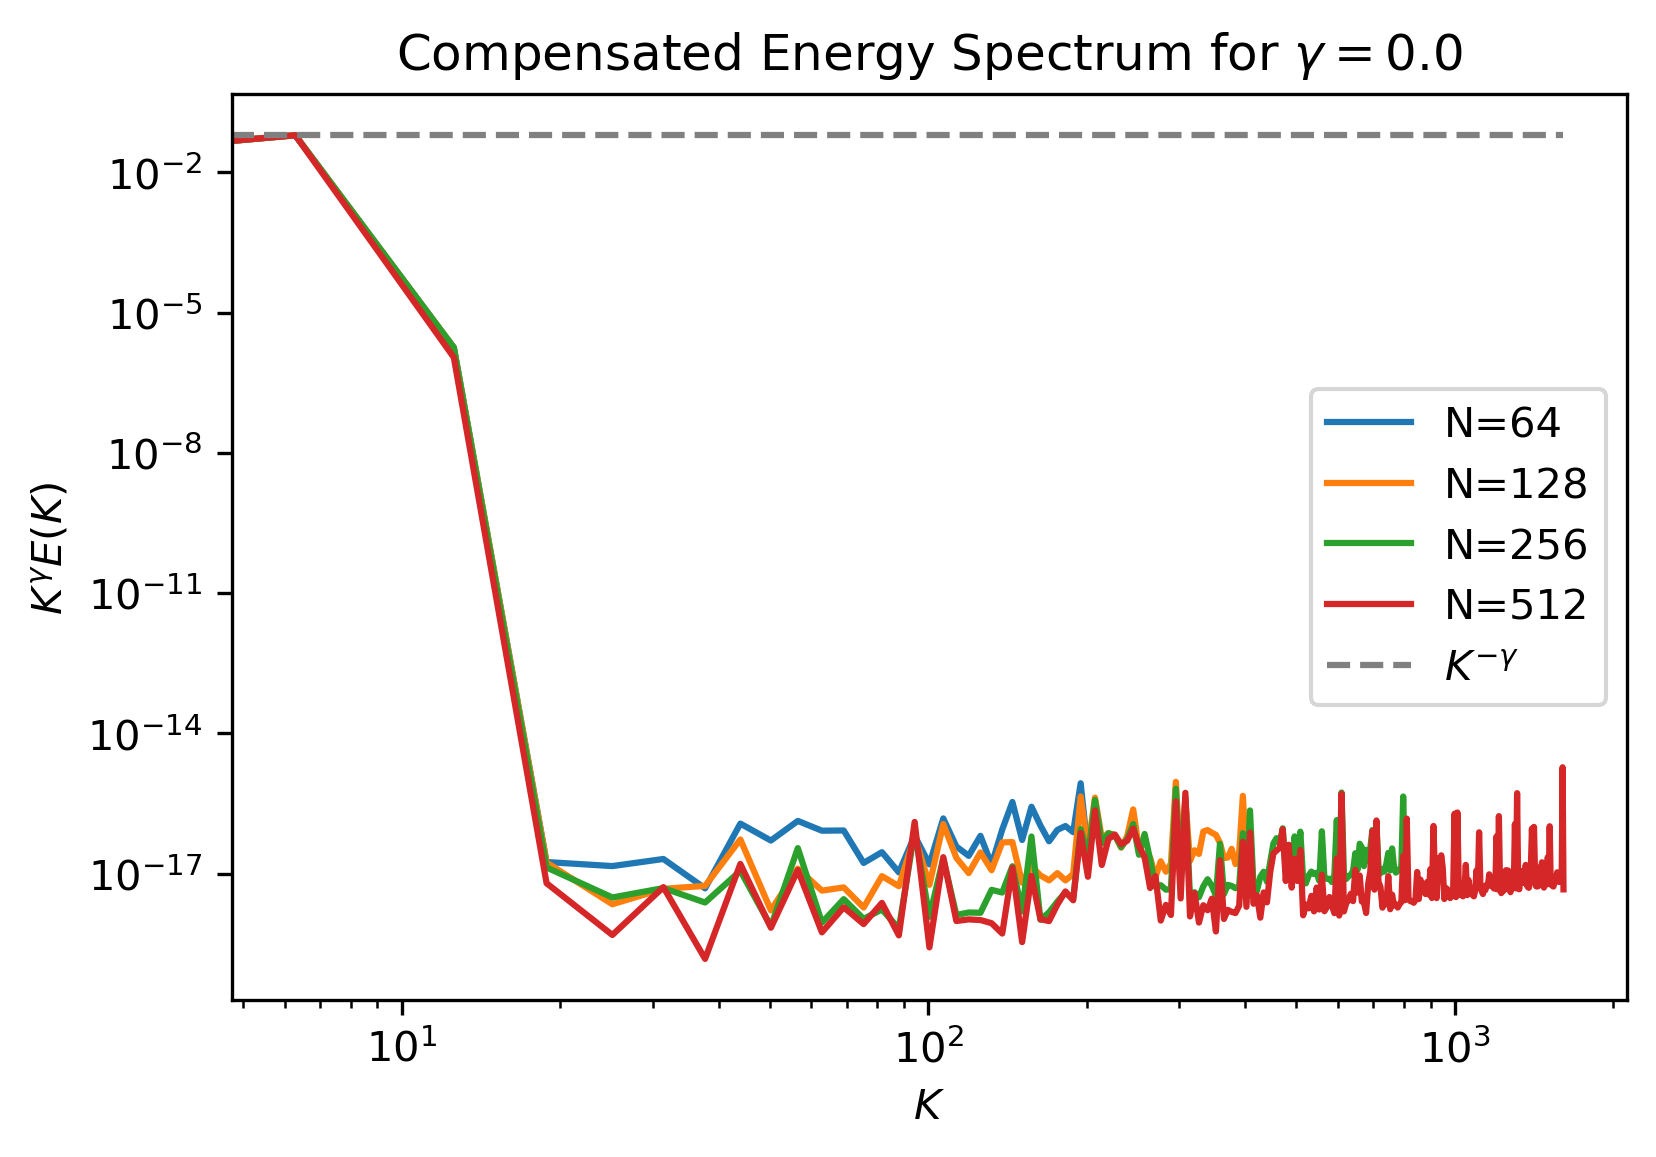

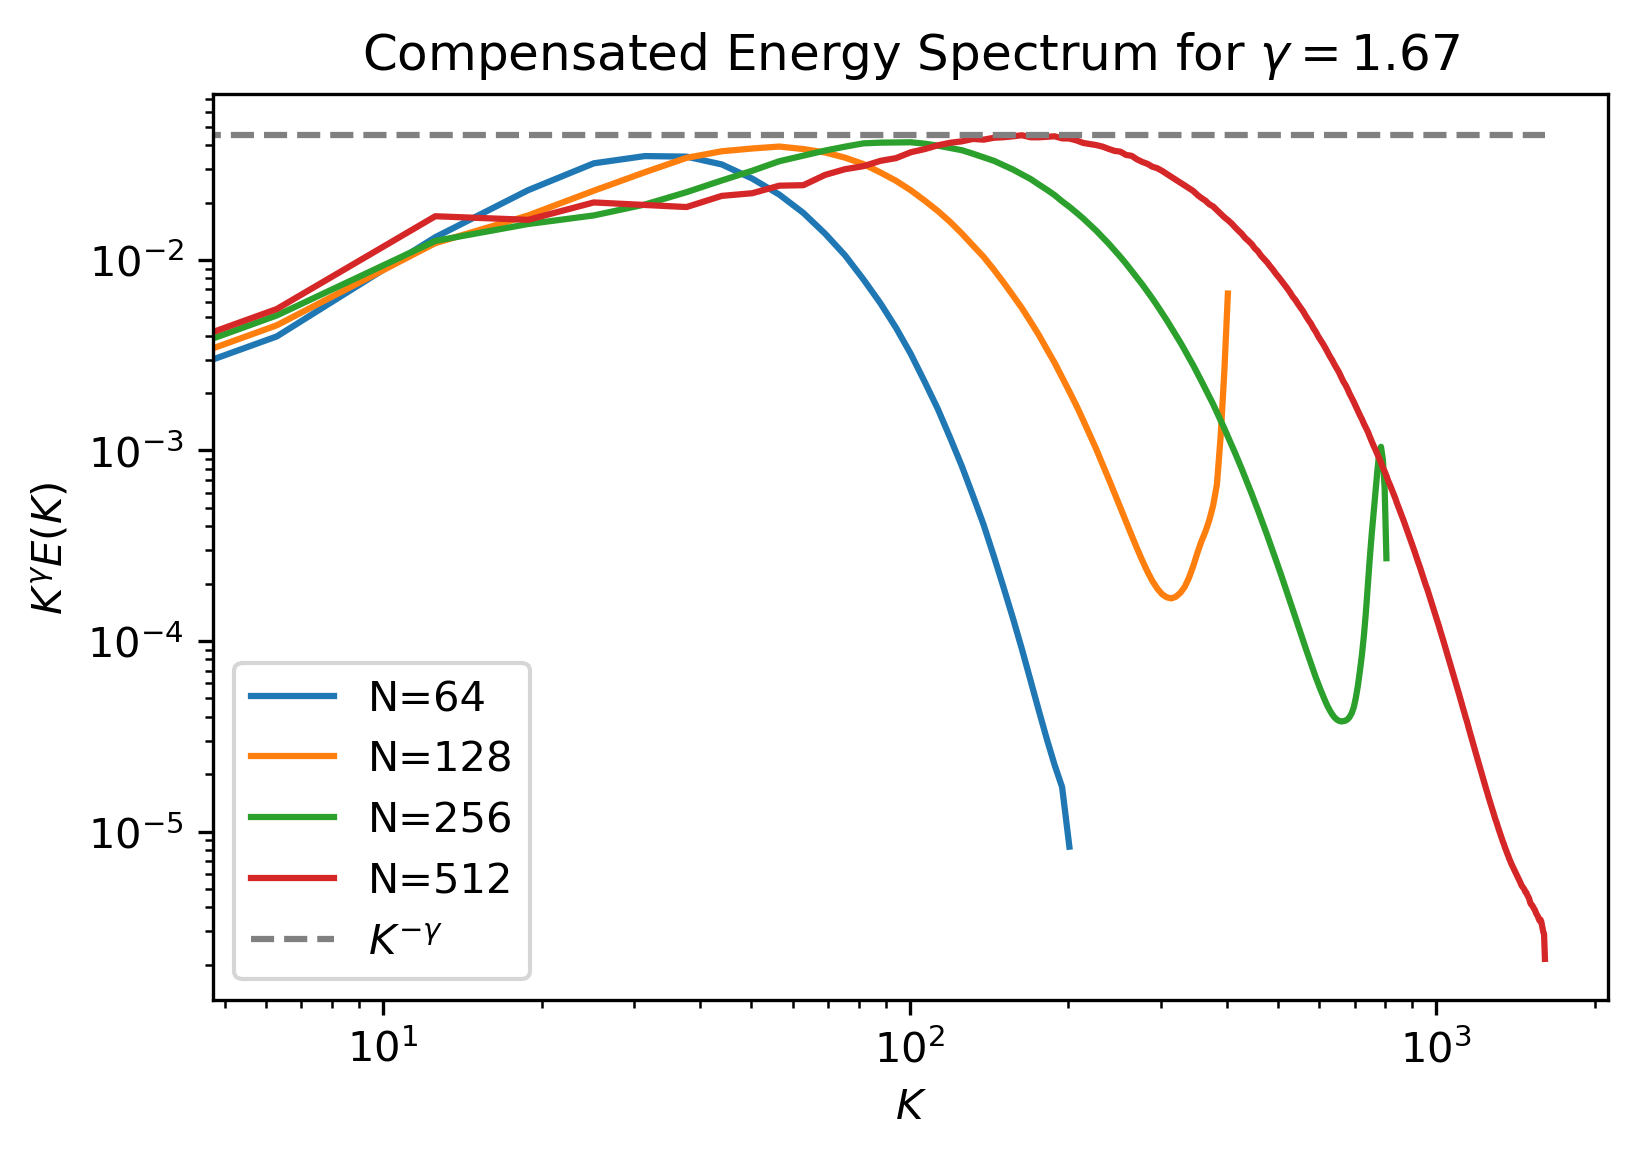

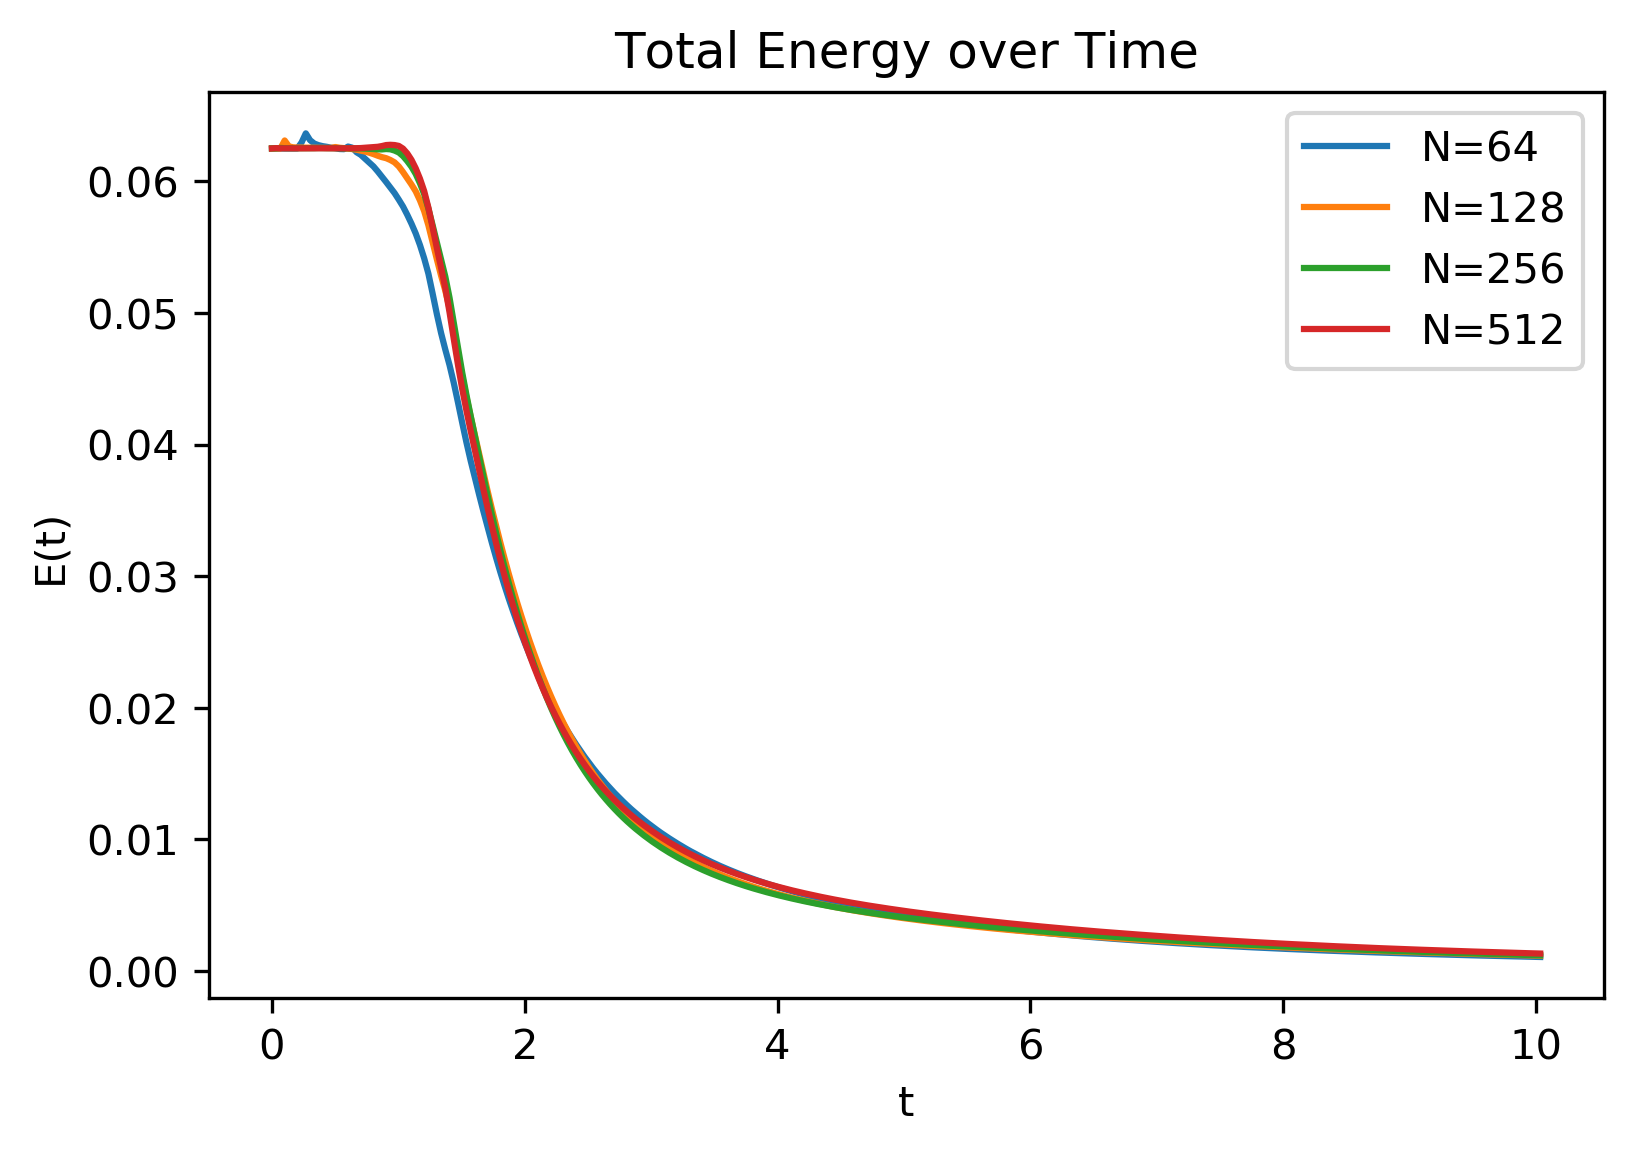

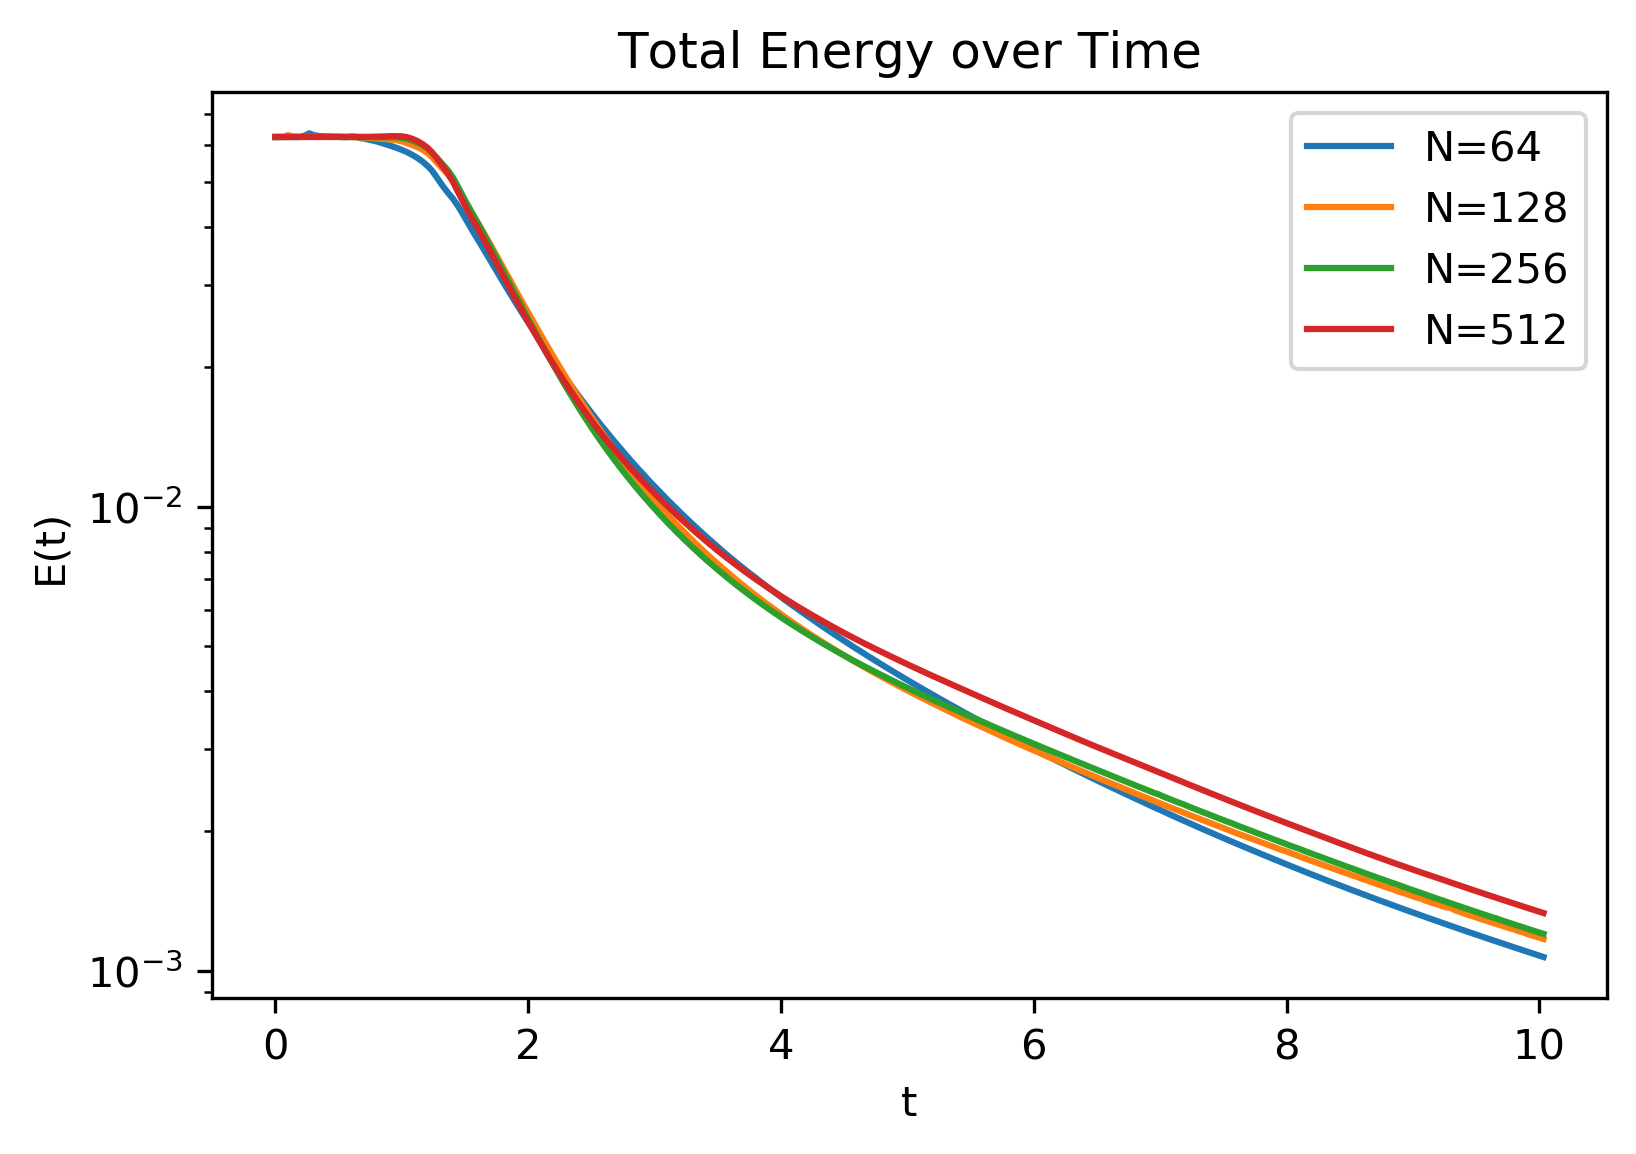

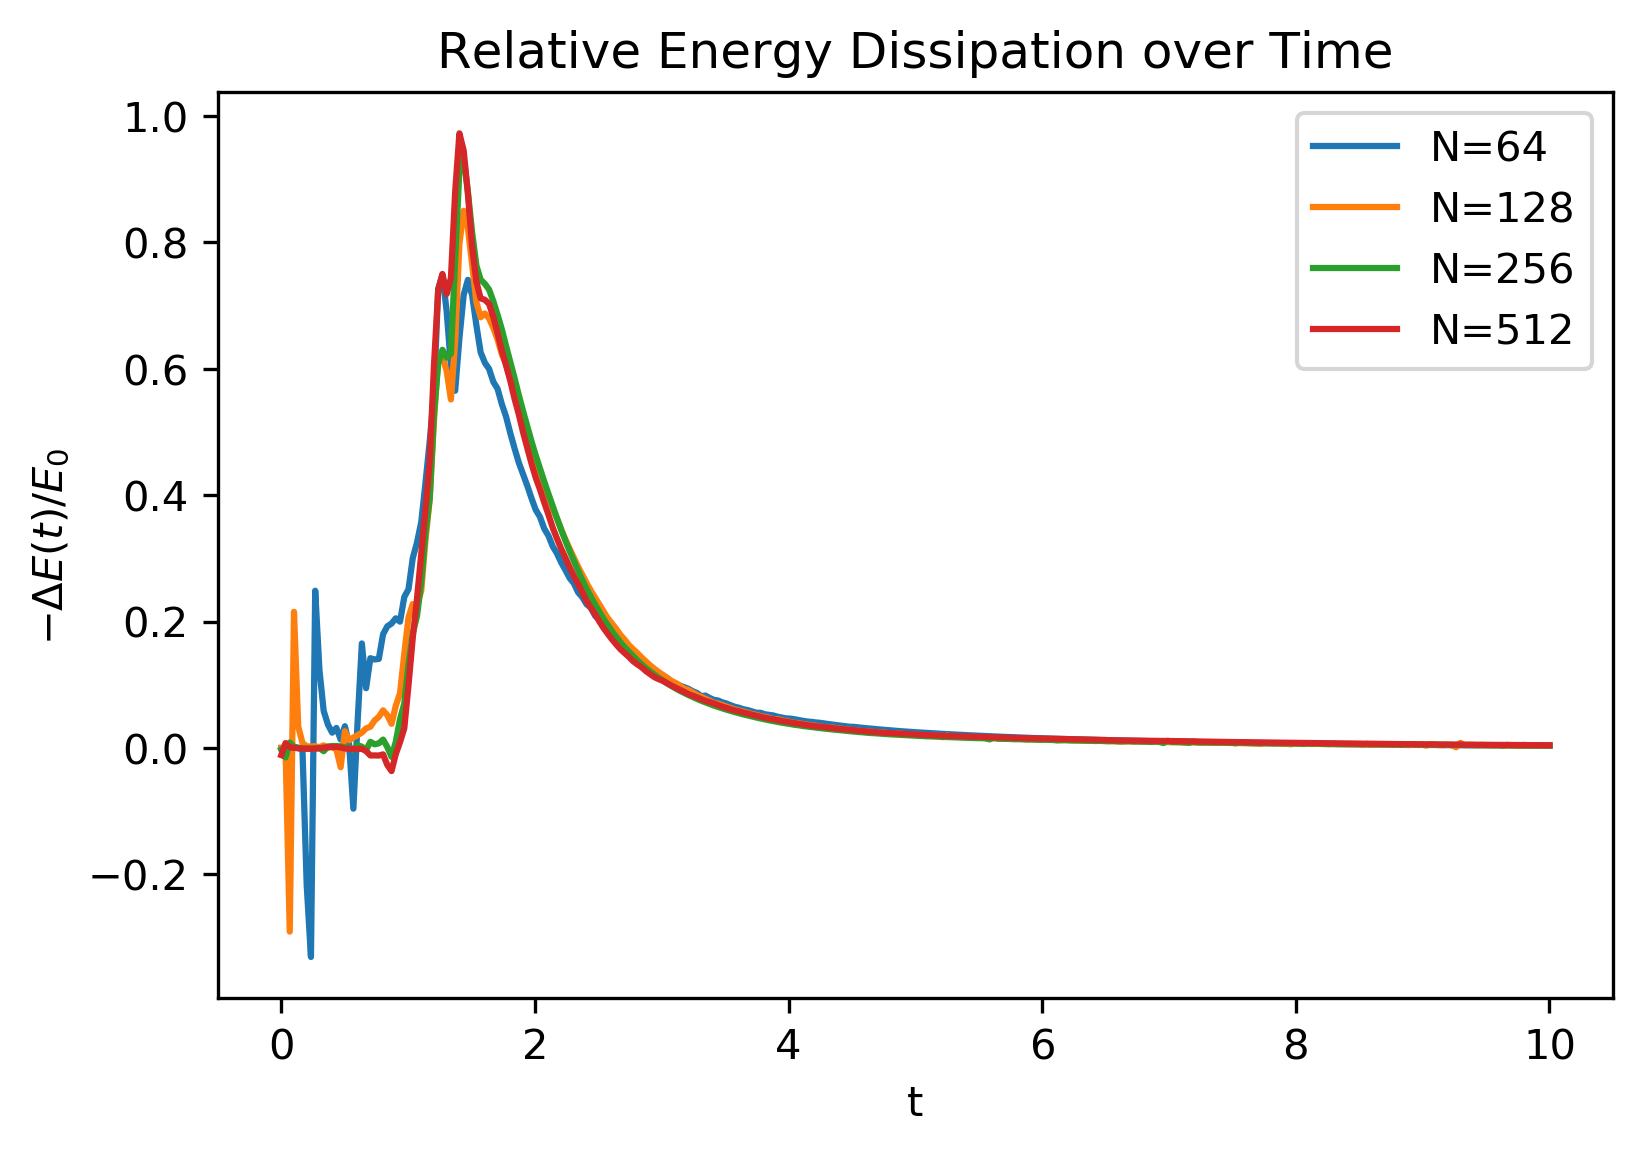

/tmp/ipykernel_45398/916339379.py:19: RuntimeWarning: invalid value encountered in log
  p = _best_fit(t, np.log(np.array(energies)), t1=len(energies))


best fit found in interval [224, 299] with error 0.00046682308412383154
best fit found in interval [126, 299] with error 0.01993741503568823
best fit found in interval [151, 299] with error 0.0024470862436803244
best fit found in interval [155, 299] with error 0.000158737766405449


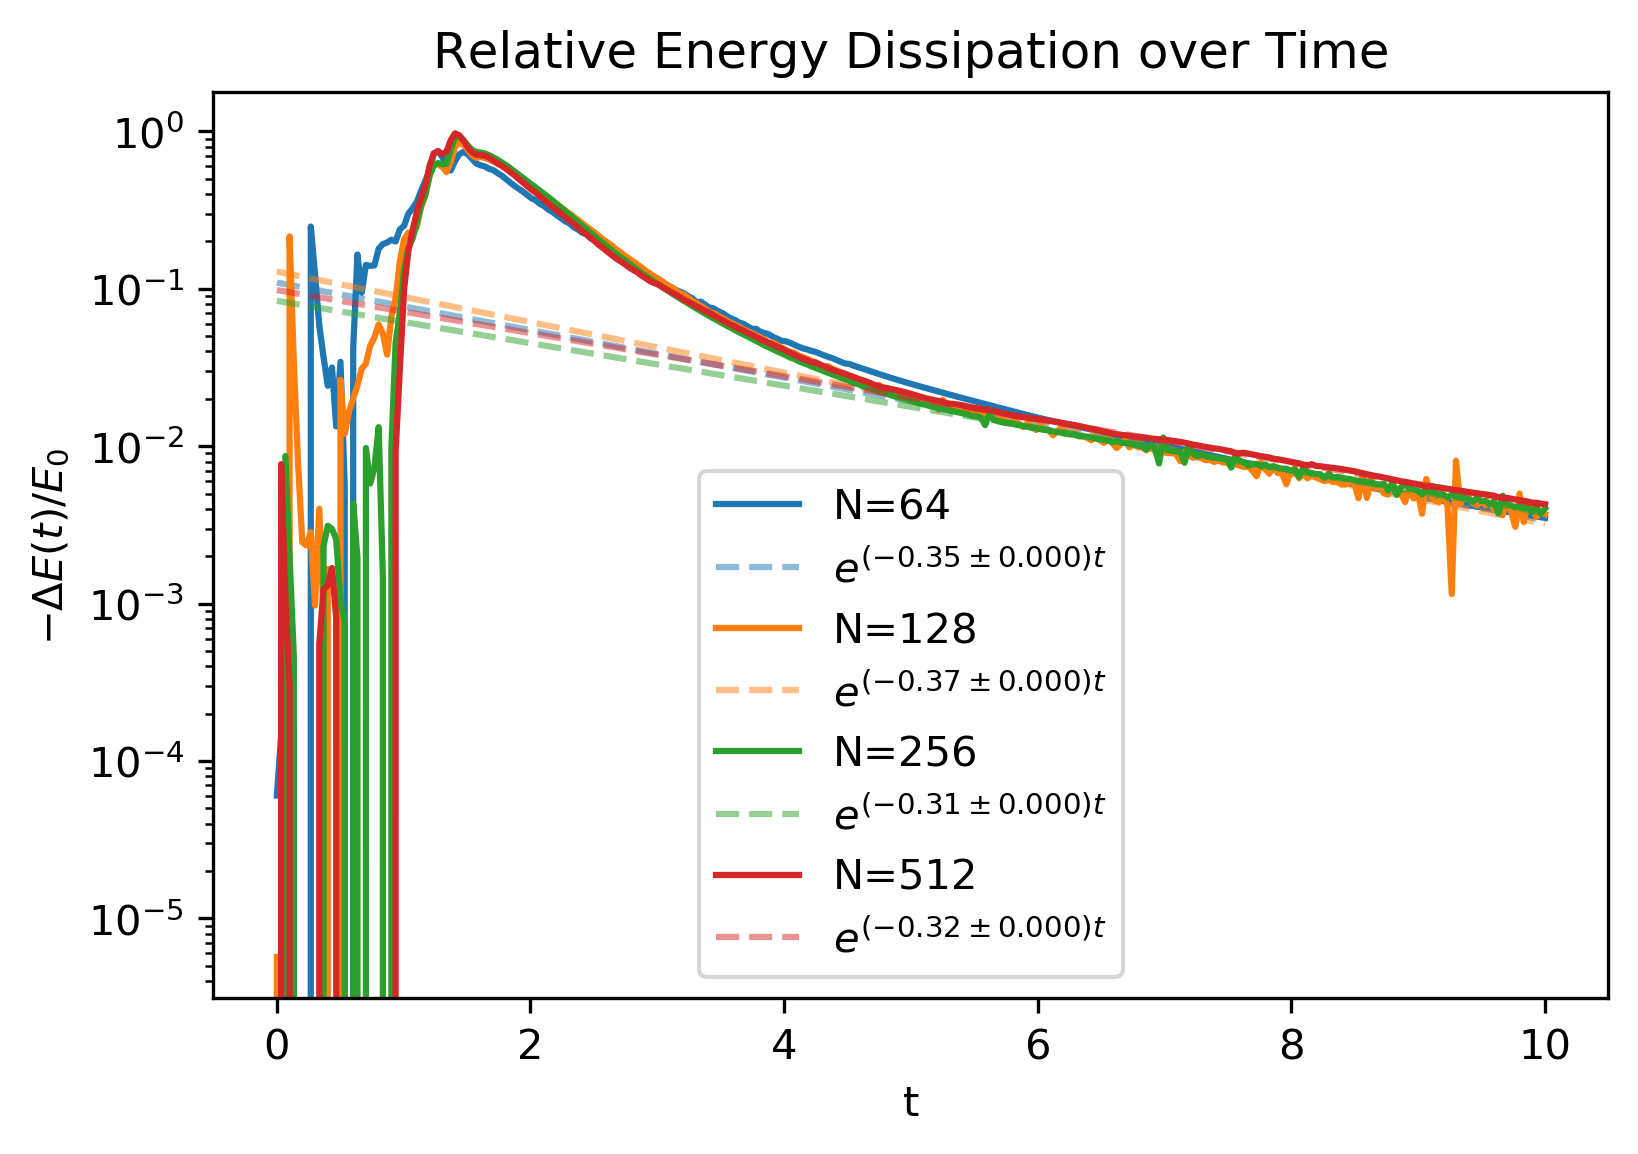

In [7]:
plot_spectrum([f'{experiment_folder}/tg_N64',
               f'{experiment_folder}/tg_N128',
               f'{experiment_folder}/tg_N256',
               f'{experiment_folder}/tg_N512'],
              [64, 128, 256, 512], 0, 0.,
              save_name=f'{experiment_folder}/tg_energy_spectrum_t0.png')
plot_spectrum([f'{experiment_folder}/tg_N64',
               f'{experiment_folder}/tg_N128',
               f'{experiment_folder}/tg_N256',
               f'{experiment_folder}/tg_N512'],
              [64, 128, 256, 512], 300, 5/3,
              save_name=f'{experiment_folder}/tg_energy_spectrum_t5.png')
plot_energy([f'{experiment_folder}/tg_N64',
             f'{experiment_folder}/tg_N128',
             f'{experiment_folder}/tg_N256',
             f'{experiment_folder}/tg_N512'],
            [64, 128, 256, 512], 10/300,
            save_name=f'{experiment_folder}/tg_total_energy.png')
plot_energy([f'{experiment_folder}/tg_N64',
             f'{experiment_folder}/tg_N128',
             f'{experiment_folder}/tg_N256',
             f'{experiment_folder}/tg_N512'],
            [64, 128, 256, 512], 10/300, loglog=True,
            save_name=f'{experiment_folder}/tg_total_energy_log.png')
plot_relative_energy_dissipation([f'{experiment_folder}/tg_N64',
                                  f'{experiment_folder}/tg_N128',
                                  f'{experiment_folder}/tg_N256',
                                  f'{experiment_folder}/tg_N512'],
                                 [64, 128, 256, 512], 10/300,
                                 save_name=f'{experiment_folder}/tg_relative_energy_dissipation.png')
plot_relative_energy_dissipation([f'{experiment_folder}/tg_N64',
                                  f'{experiment_folder}/tg_N128',
                                  f'{experiment_folder}/tg_N256',
                                  f'{experiment_folder}/tg_N512'],
                                 [64, 128, 256, 512], 10/300, loglog=True, fit_interval=[5,10],
                                 save_name=f'{experiment_folder}/tg_relative_energy_dissipation_log.png')

# Energy Spectra of Discontinuous Shear Tube

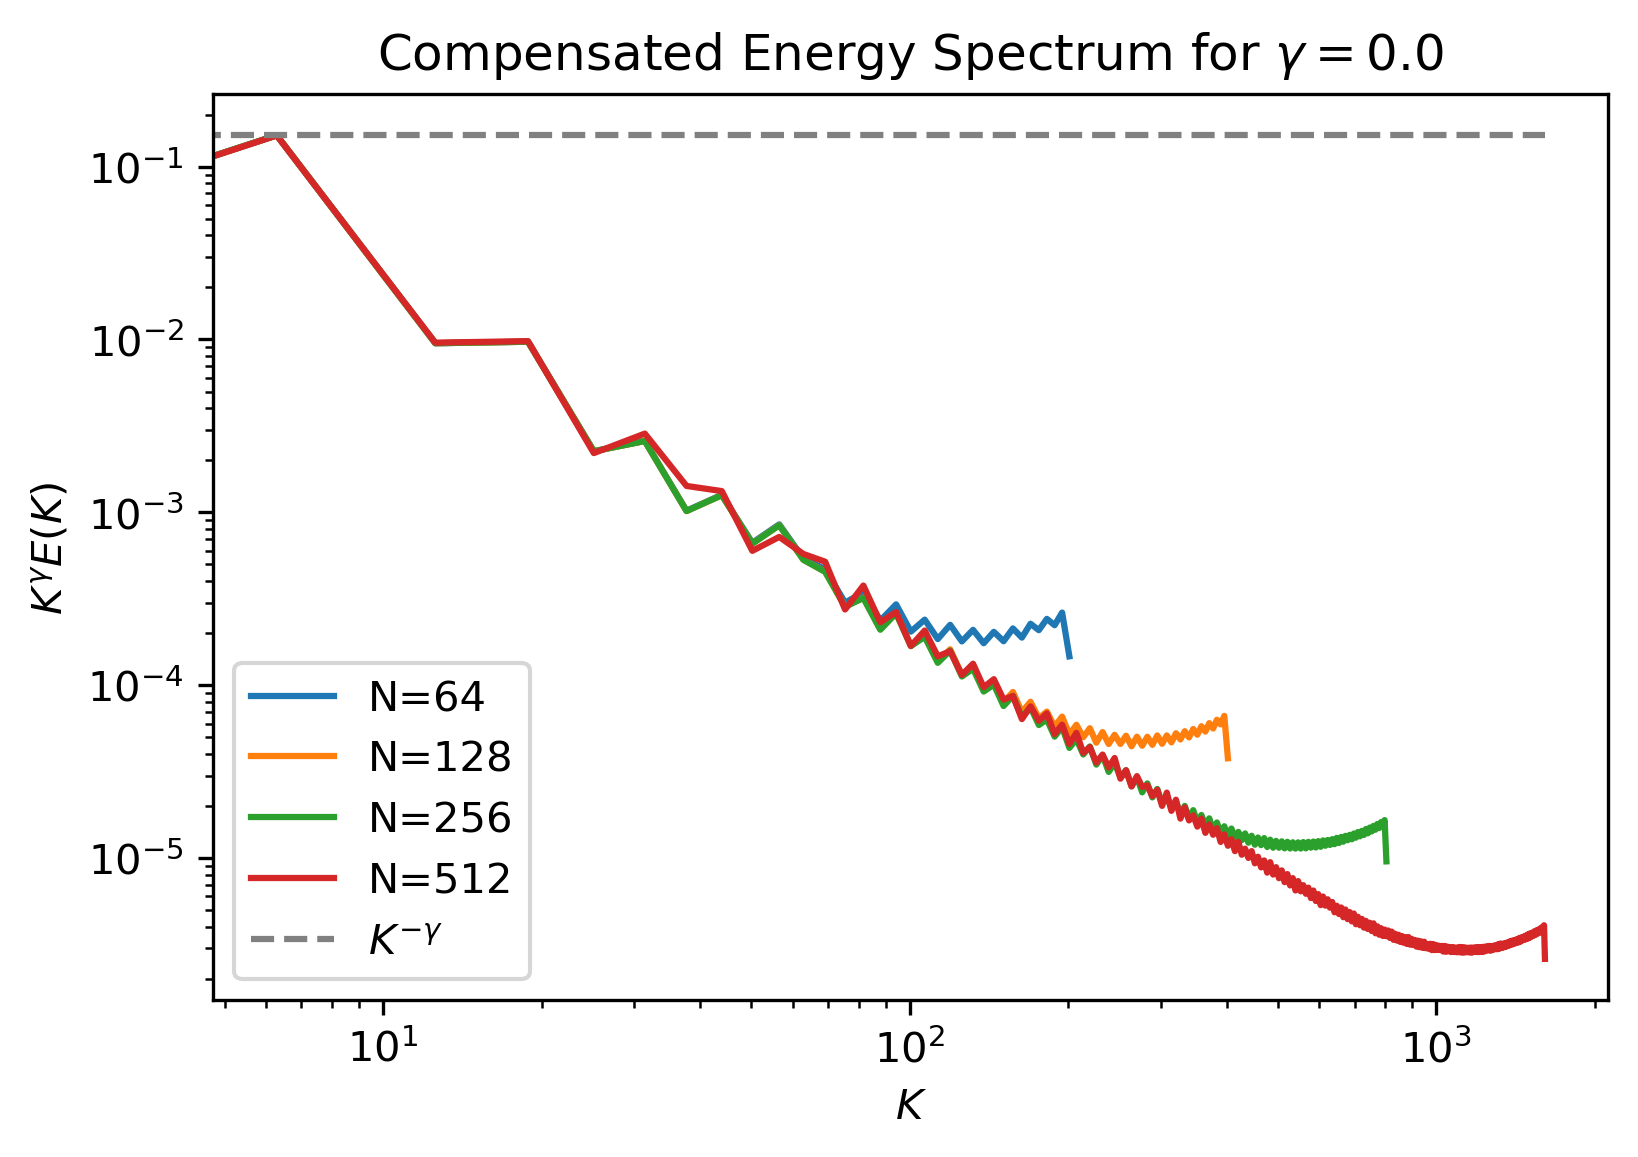

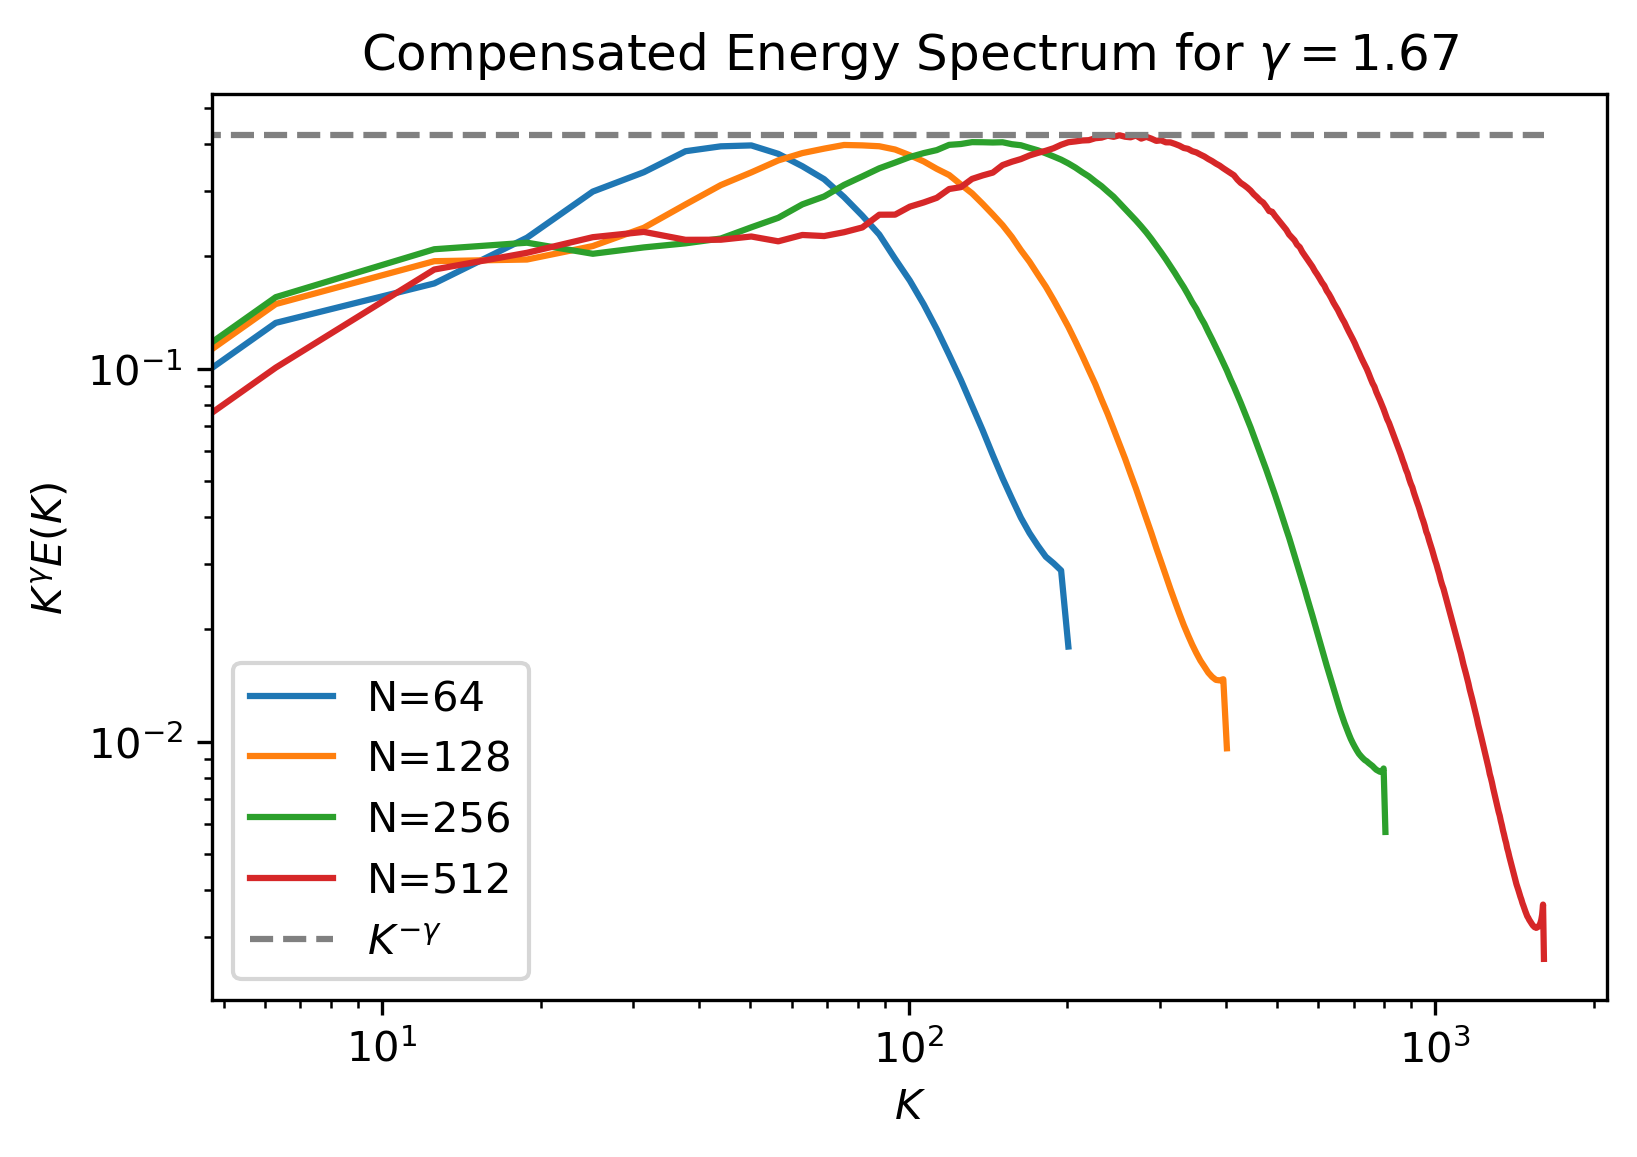

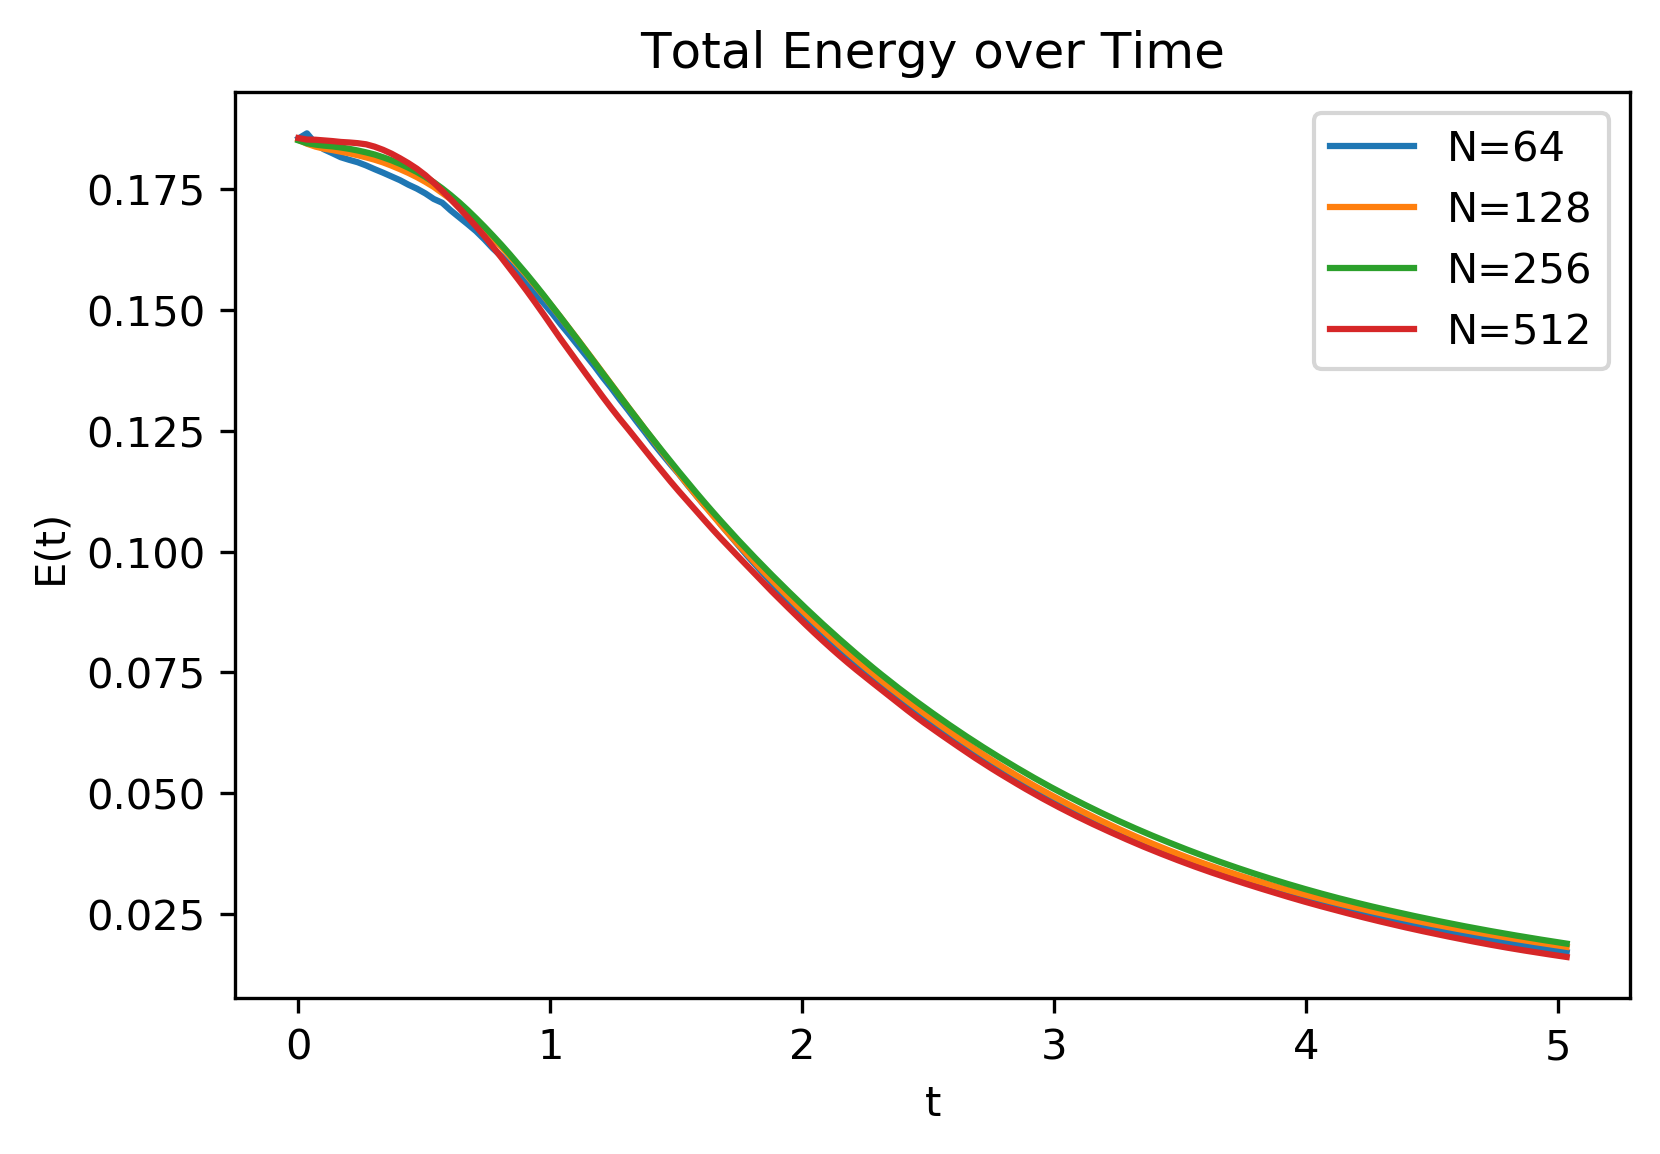

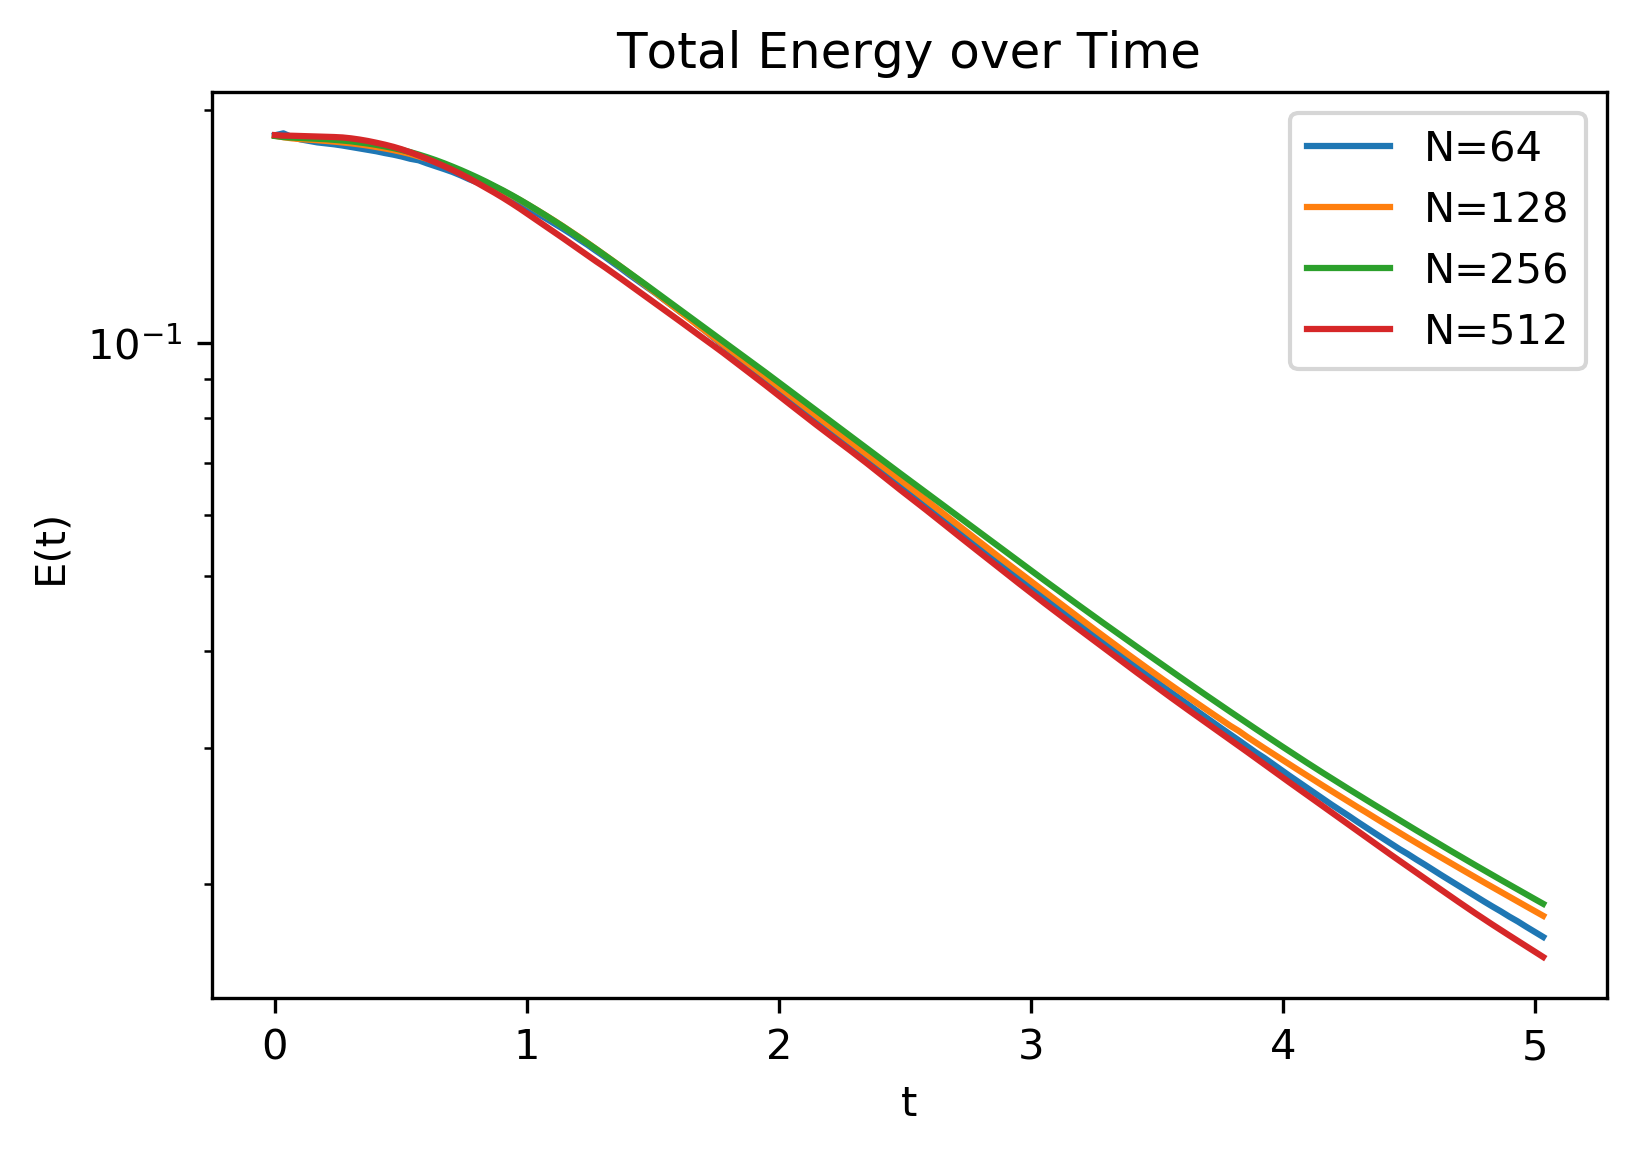

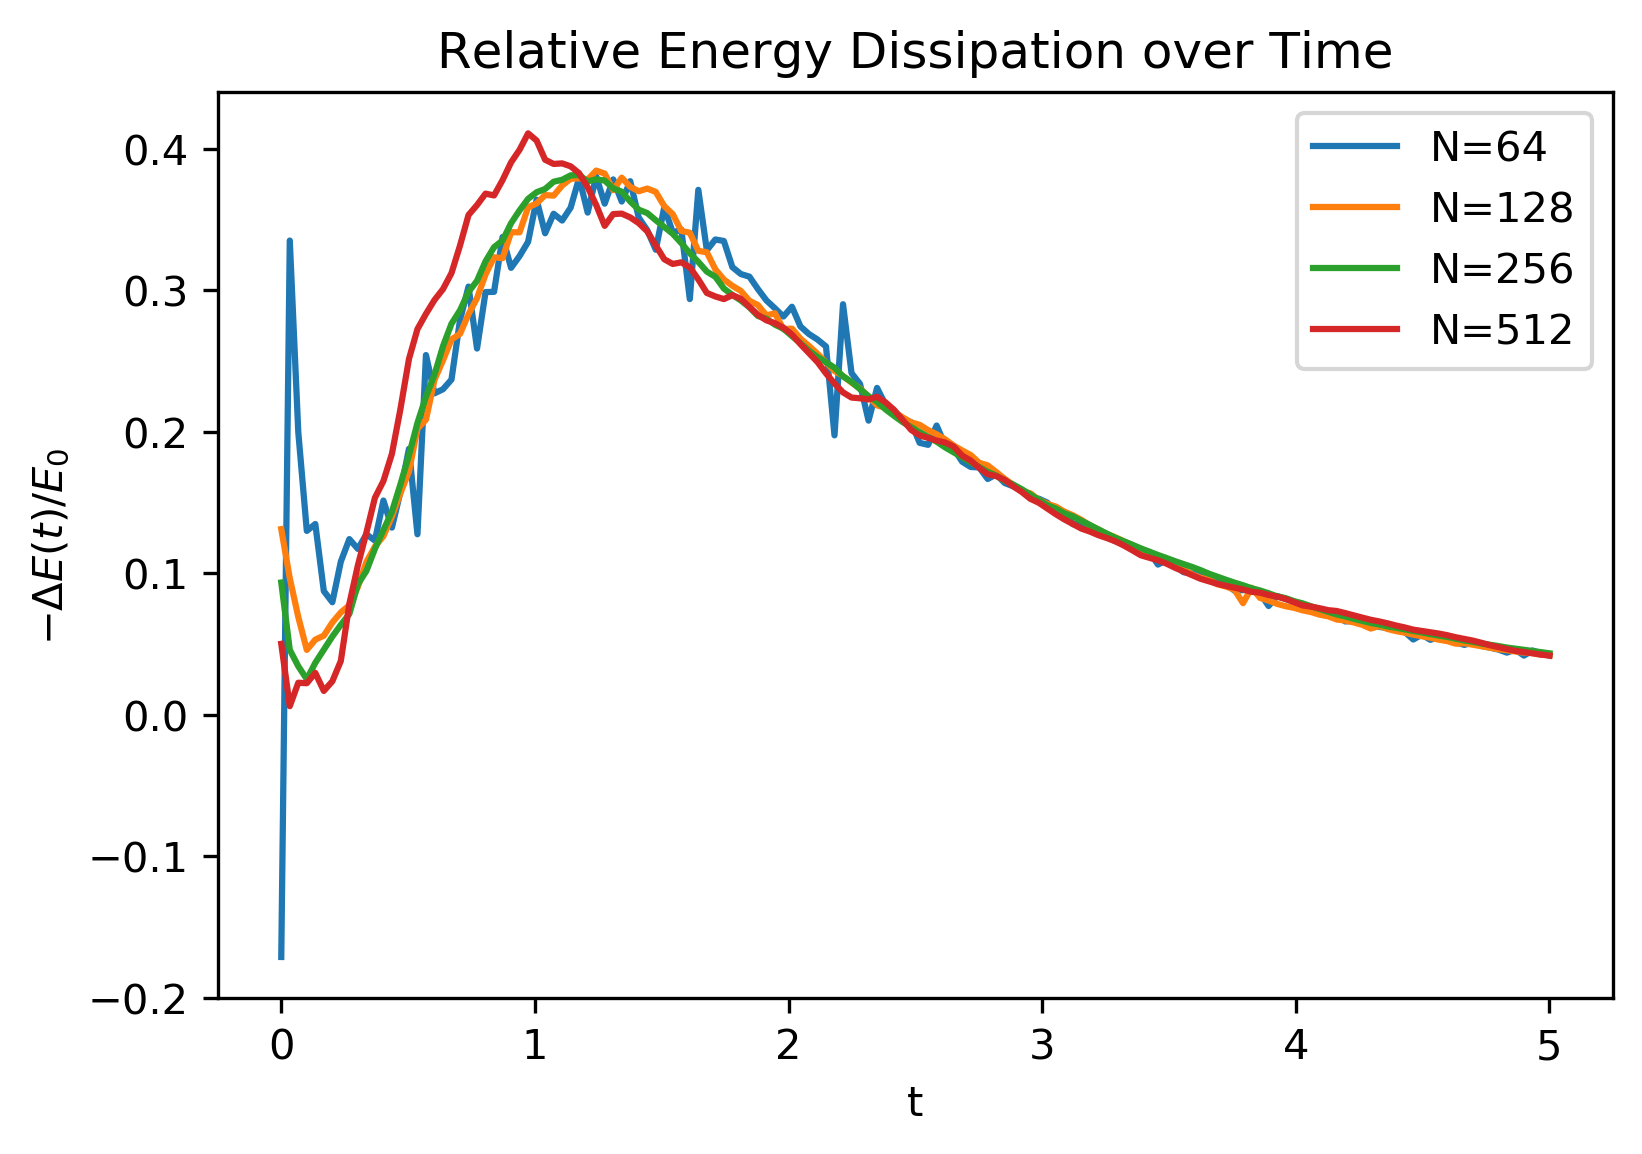

/tmp/ipykernel_45398/916339379.py:19: RuntimeWarning: invalid value encountered in log
  p = _best_fit(t, np.log(np.array(energies)), t1=len(energies))


best fit found in interval [70, 149] with error 0.002663936548165497
best fit found in interval [58, 149] with error 0.00218721376653049
best fit found in interval [77, 149] with error 0.0003954403699462134
best fit found in interval [54, 149] with error 0.0013313782830031015


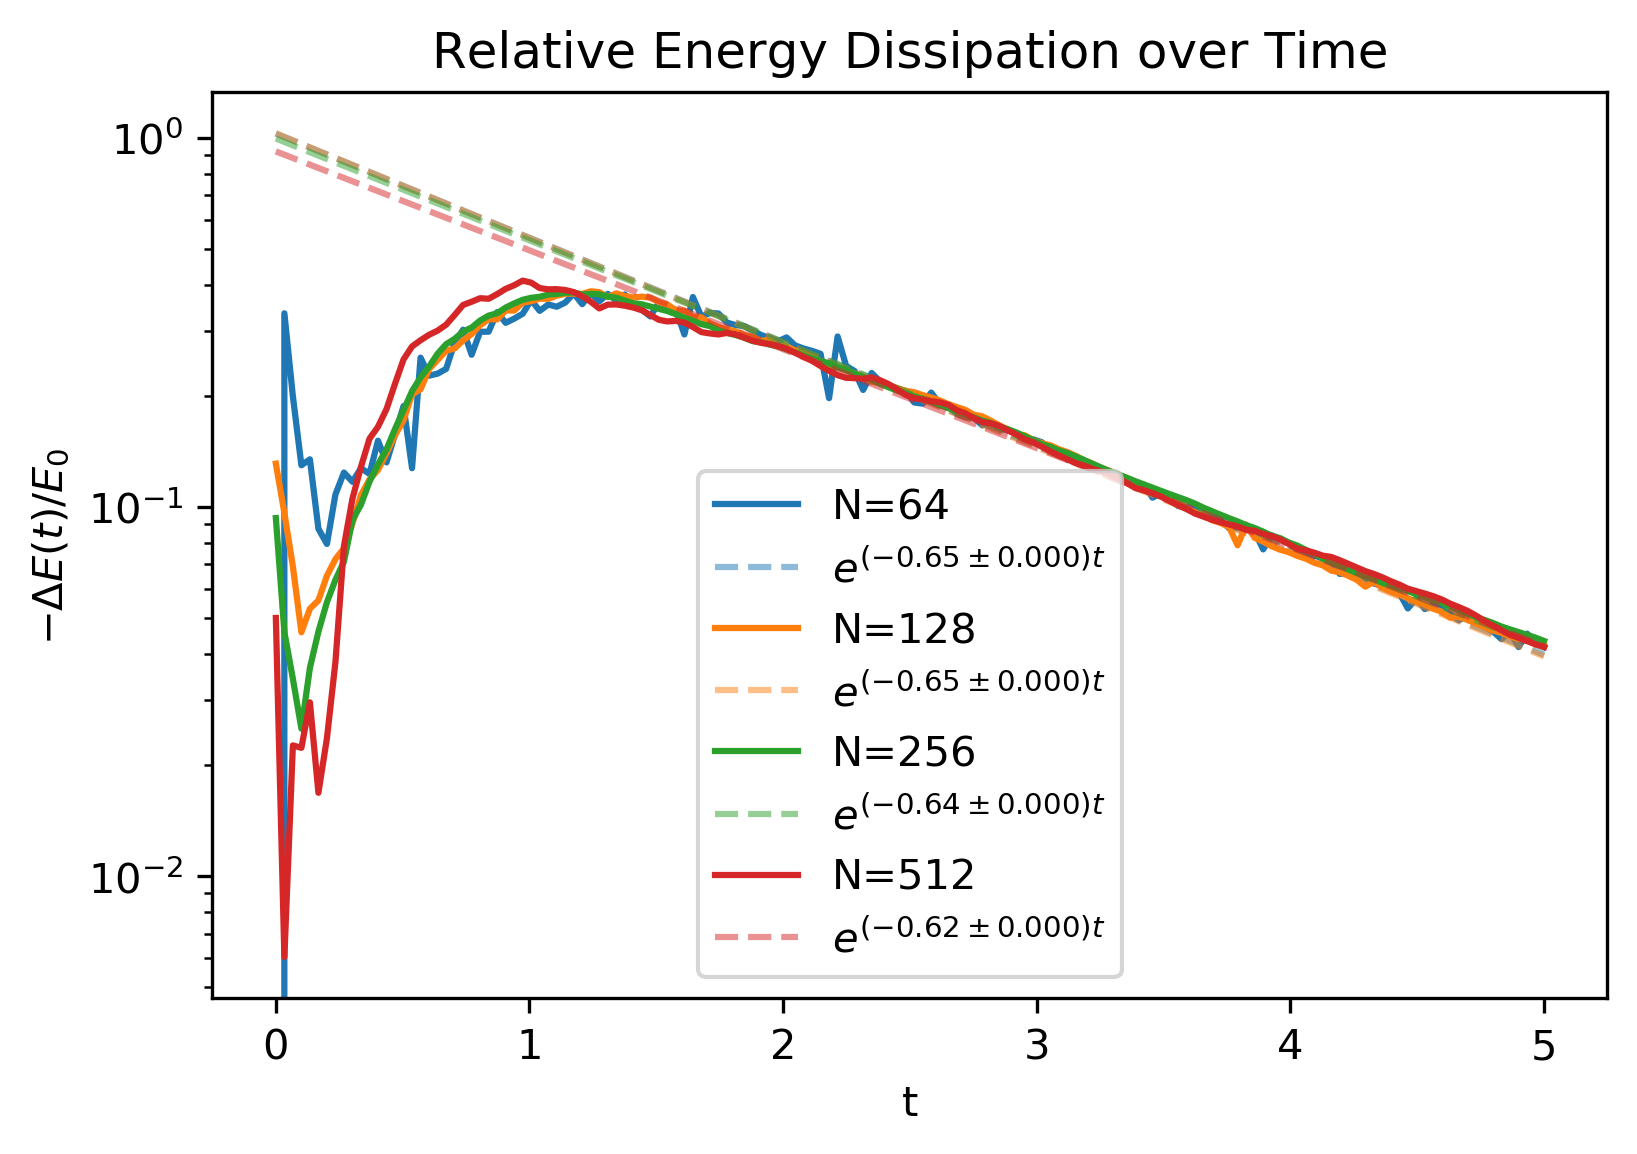

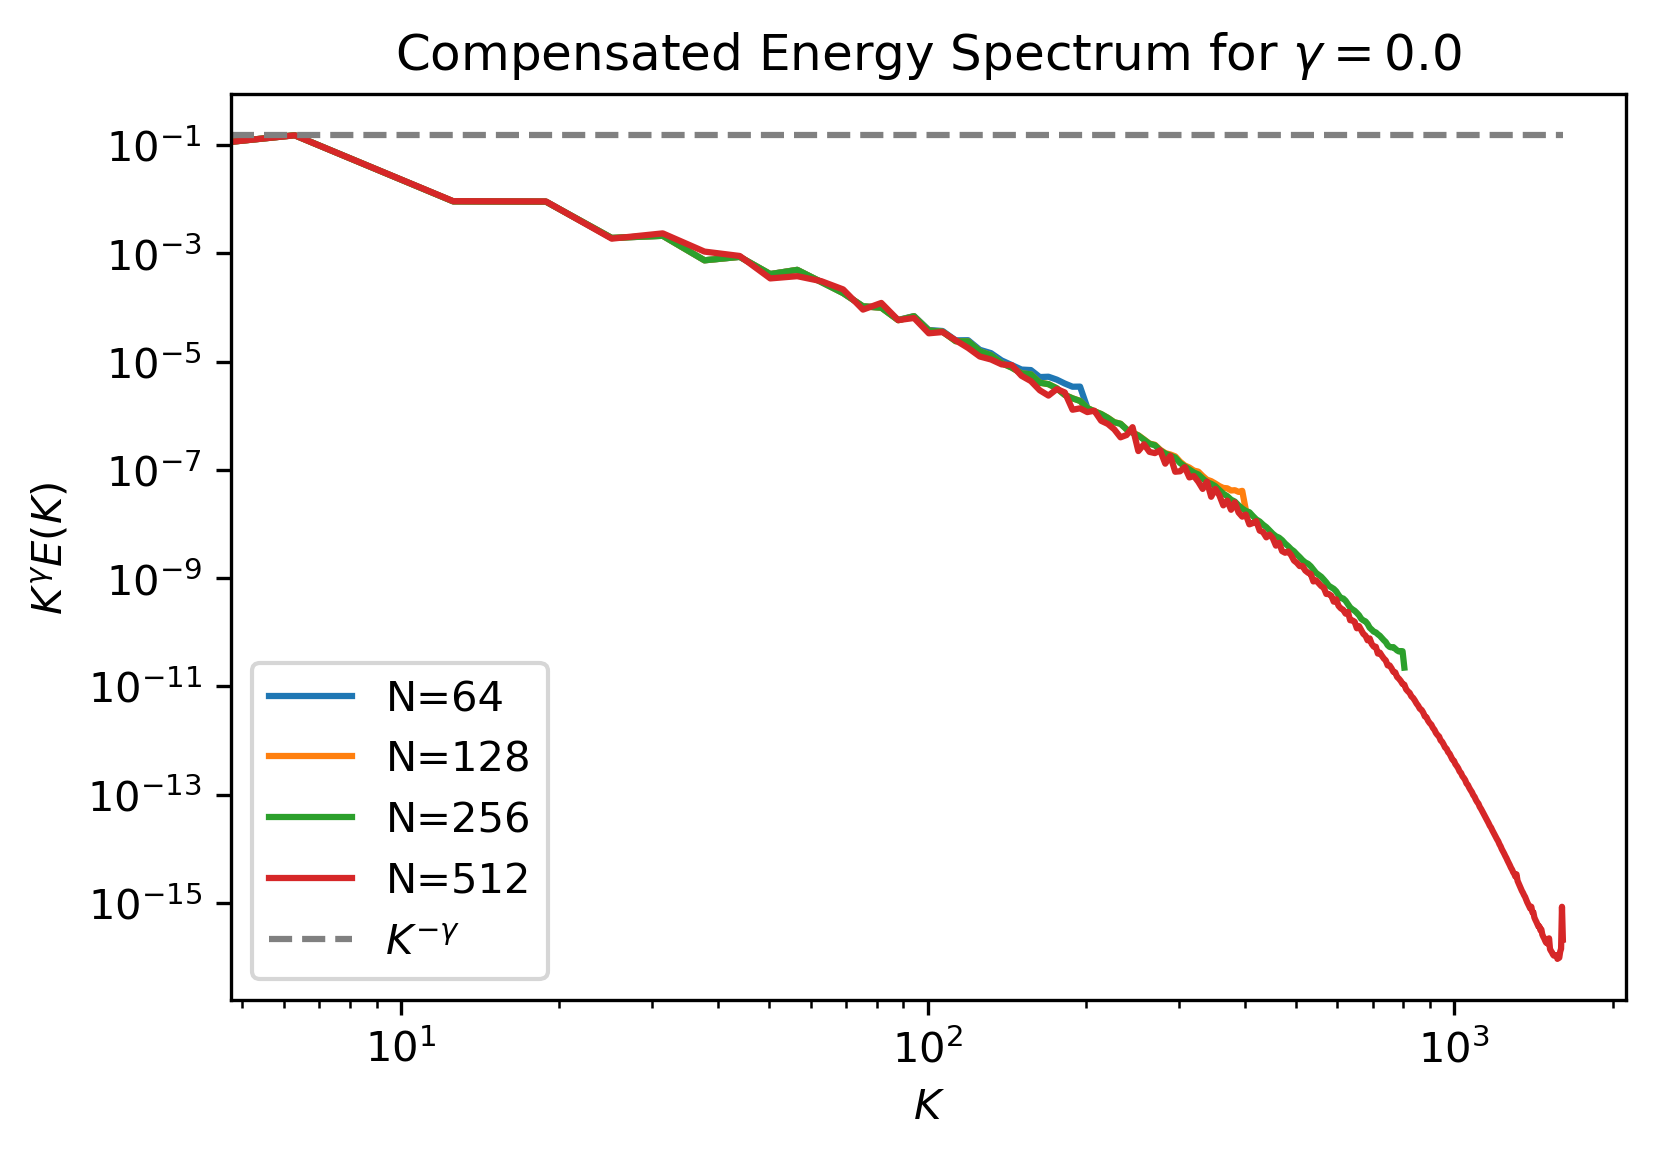

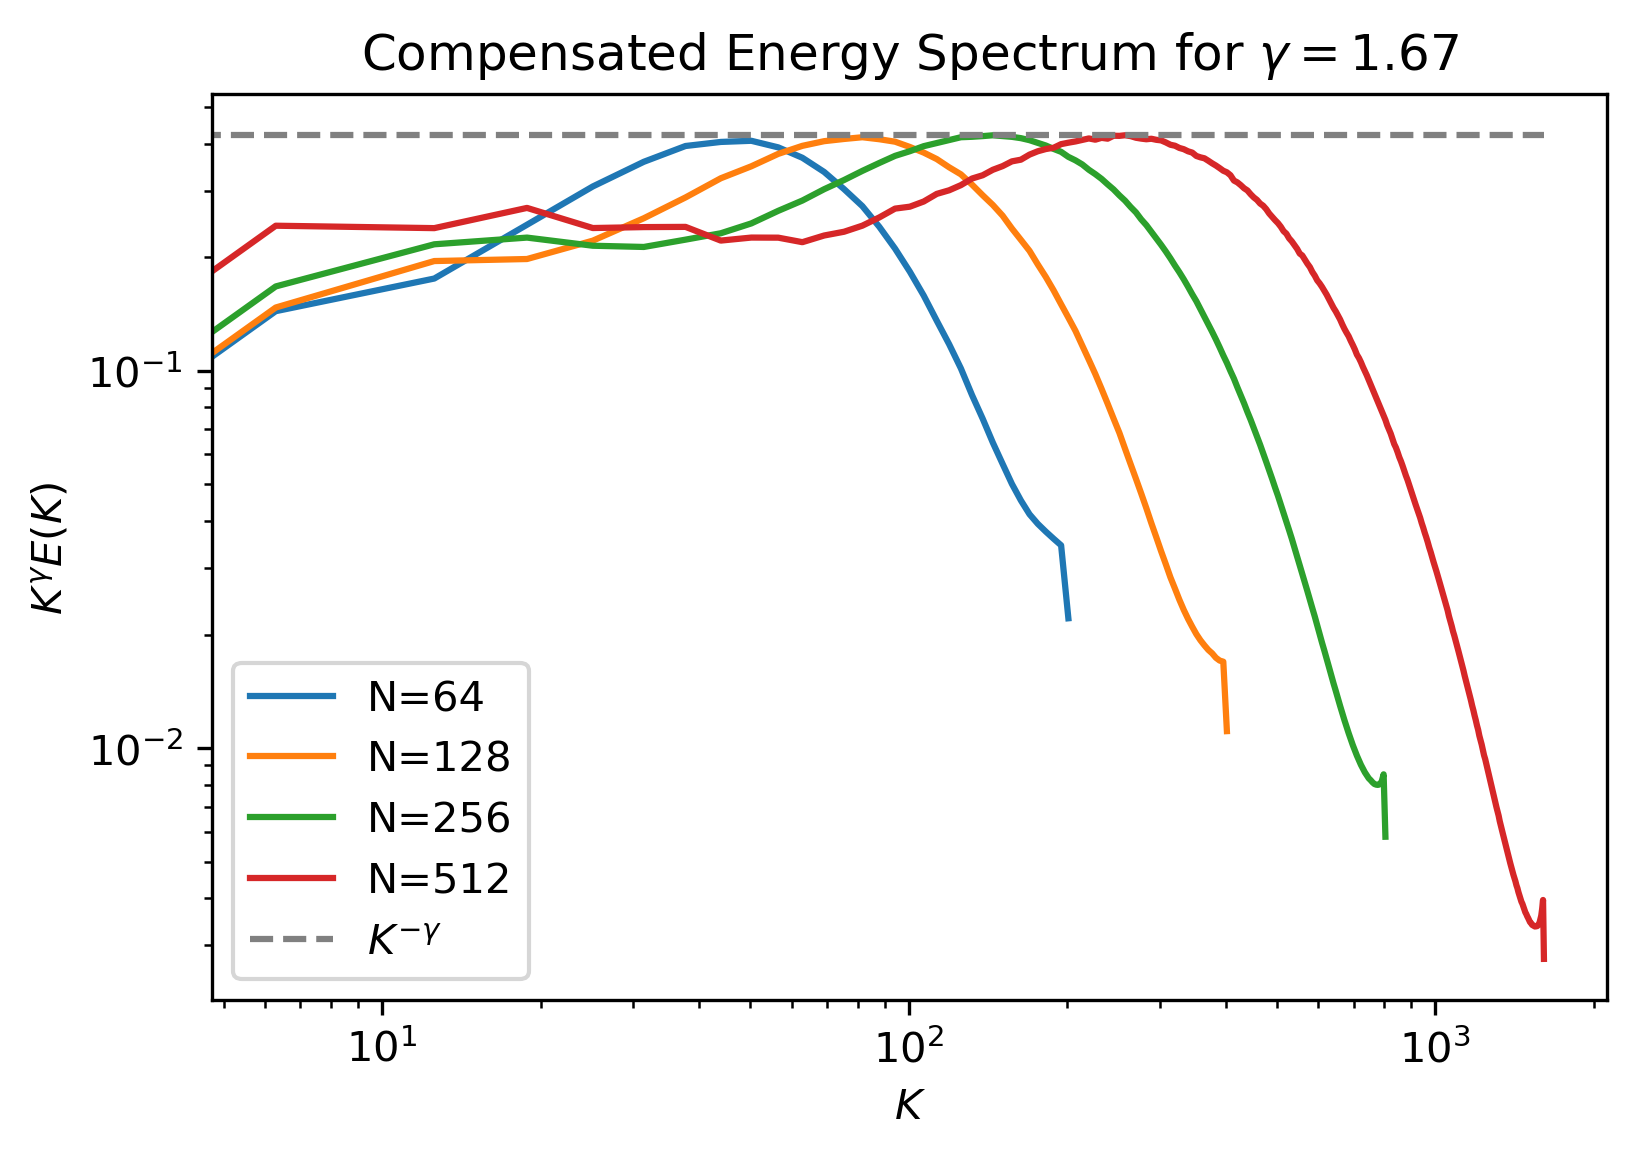

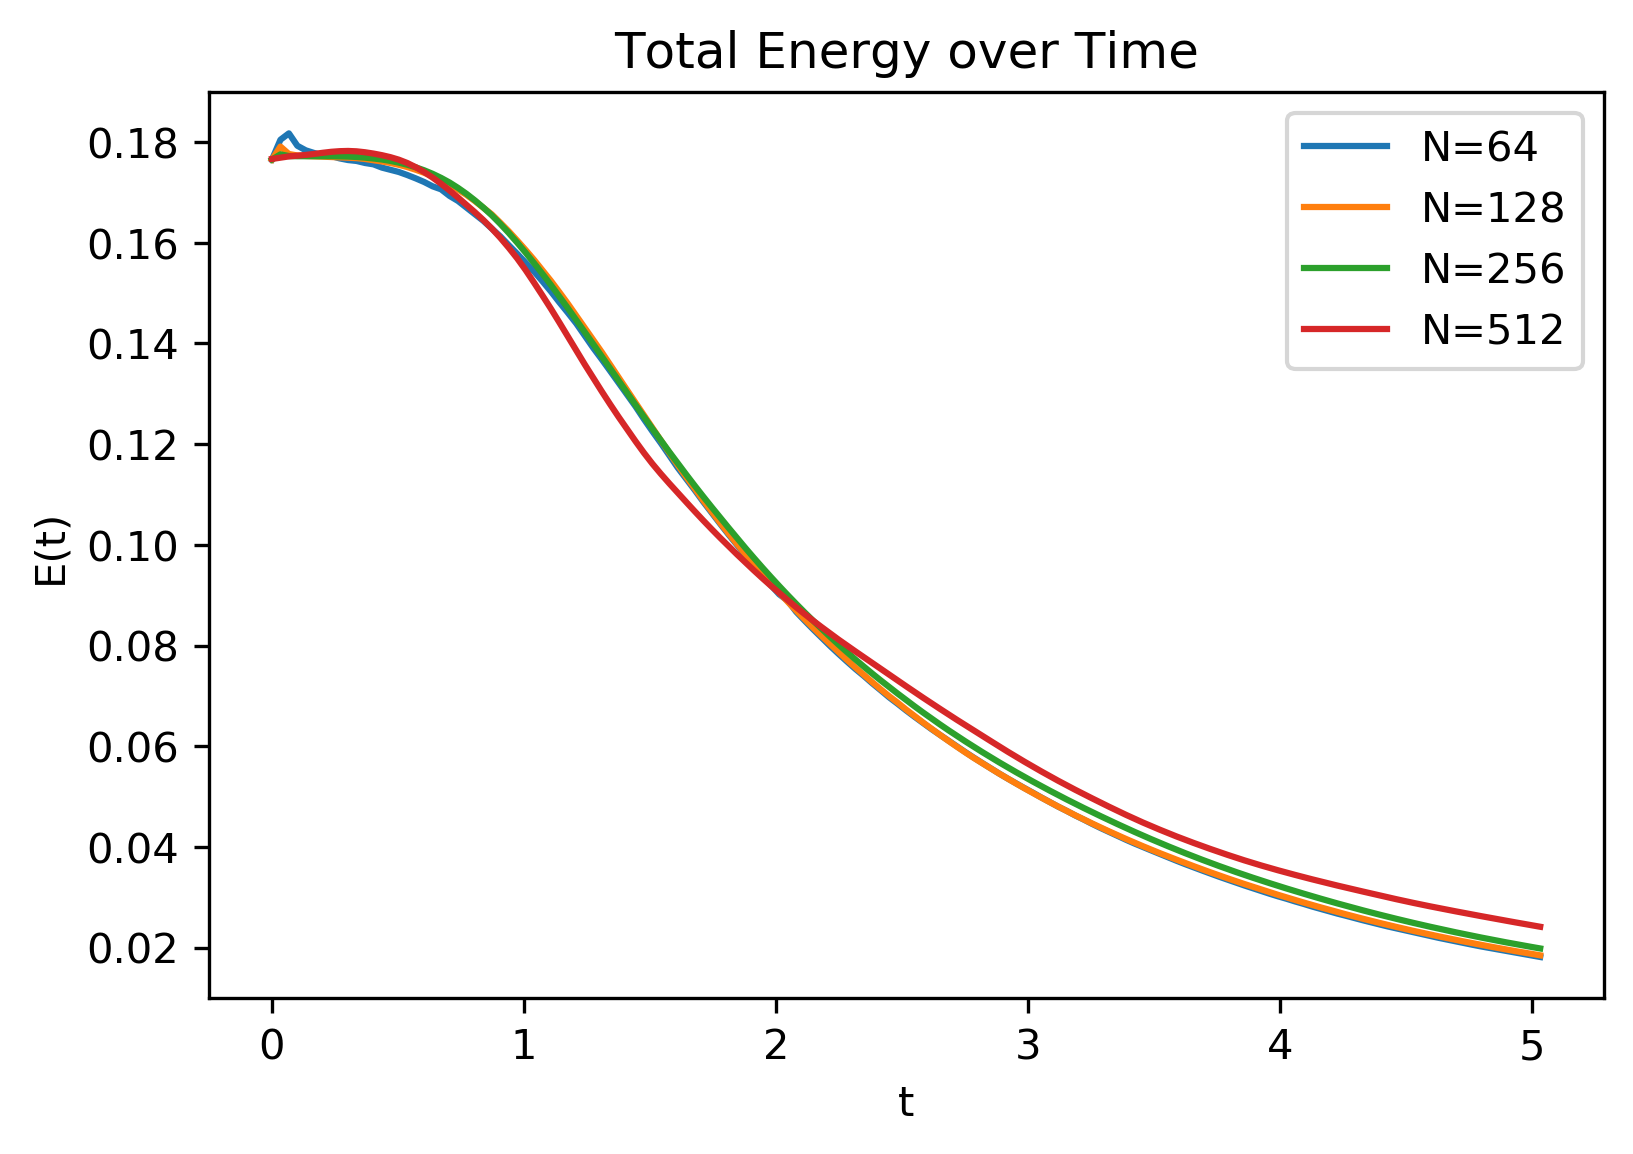

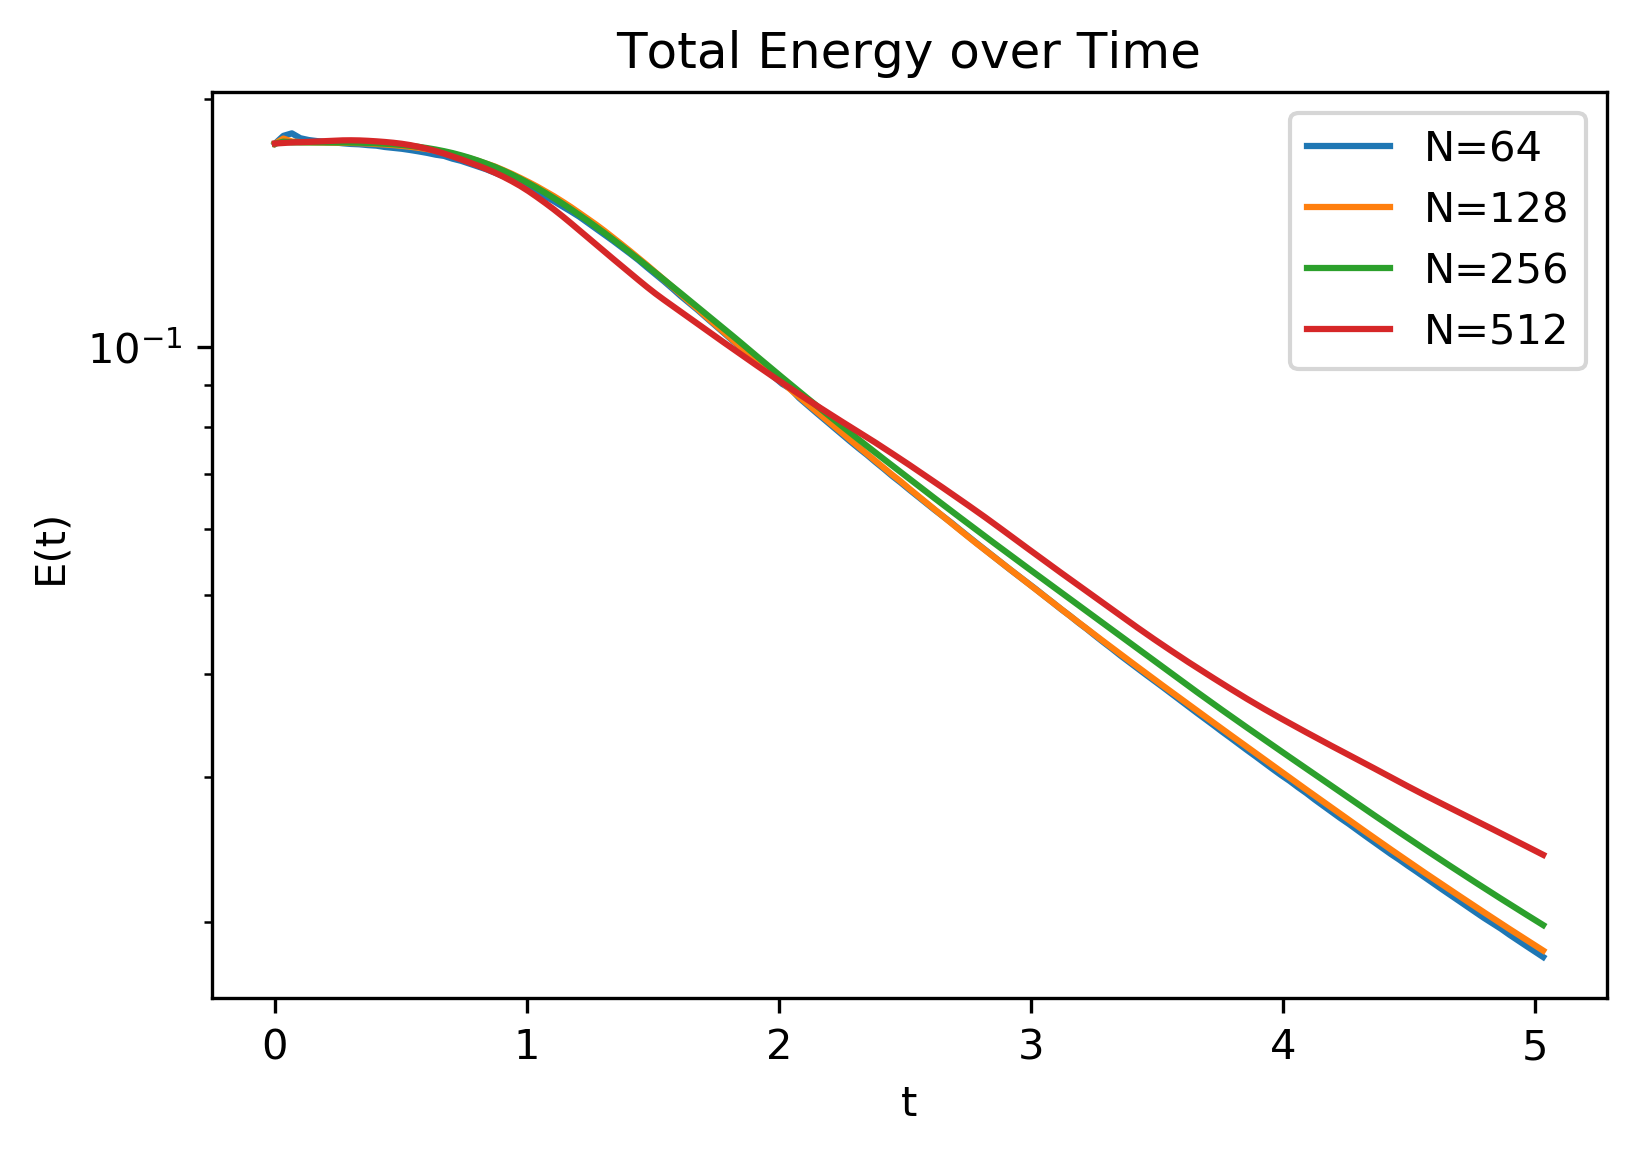

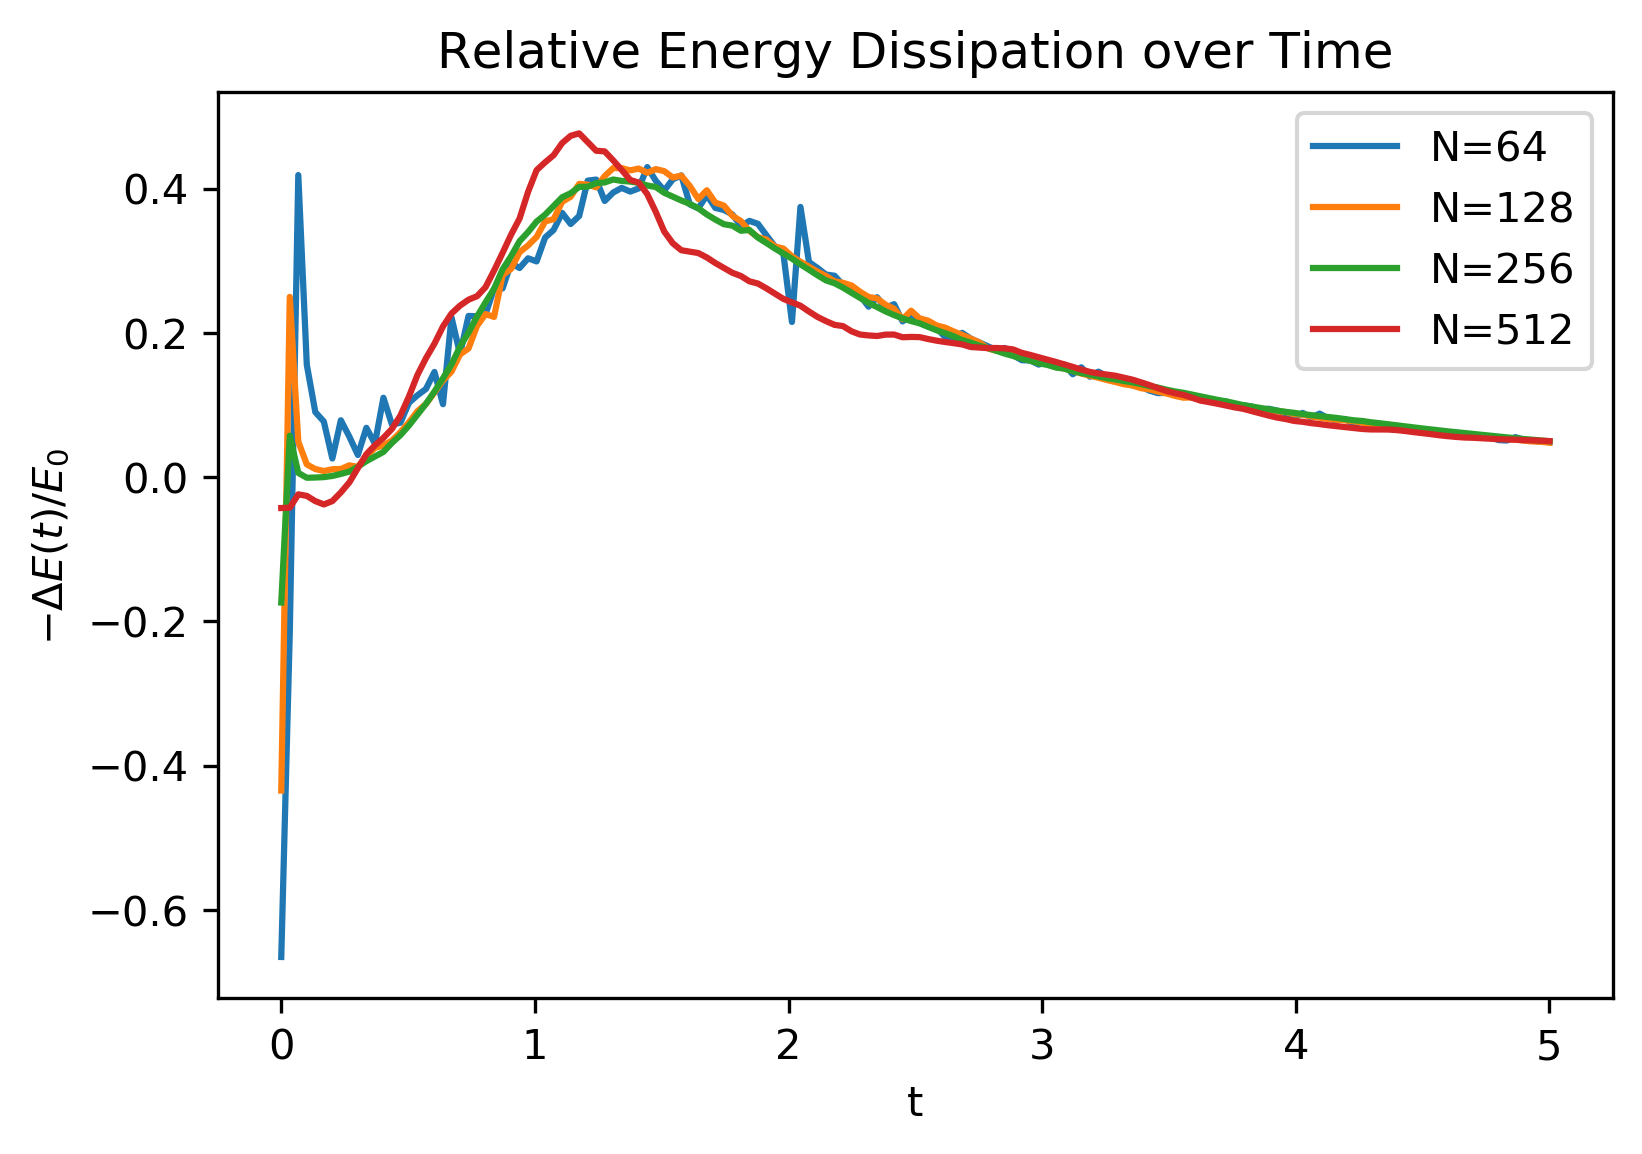

best fit found in interval [66, 149] with error 0.002940244903870971
best fit found in interval [83, 149] with error 0.000561068861226728
best fit found in interval [71, 149] with error 0.00033930832889598843
best fit found in interval [30, 149] with error 0.009697035833615234


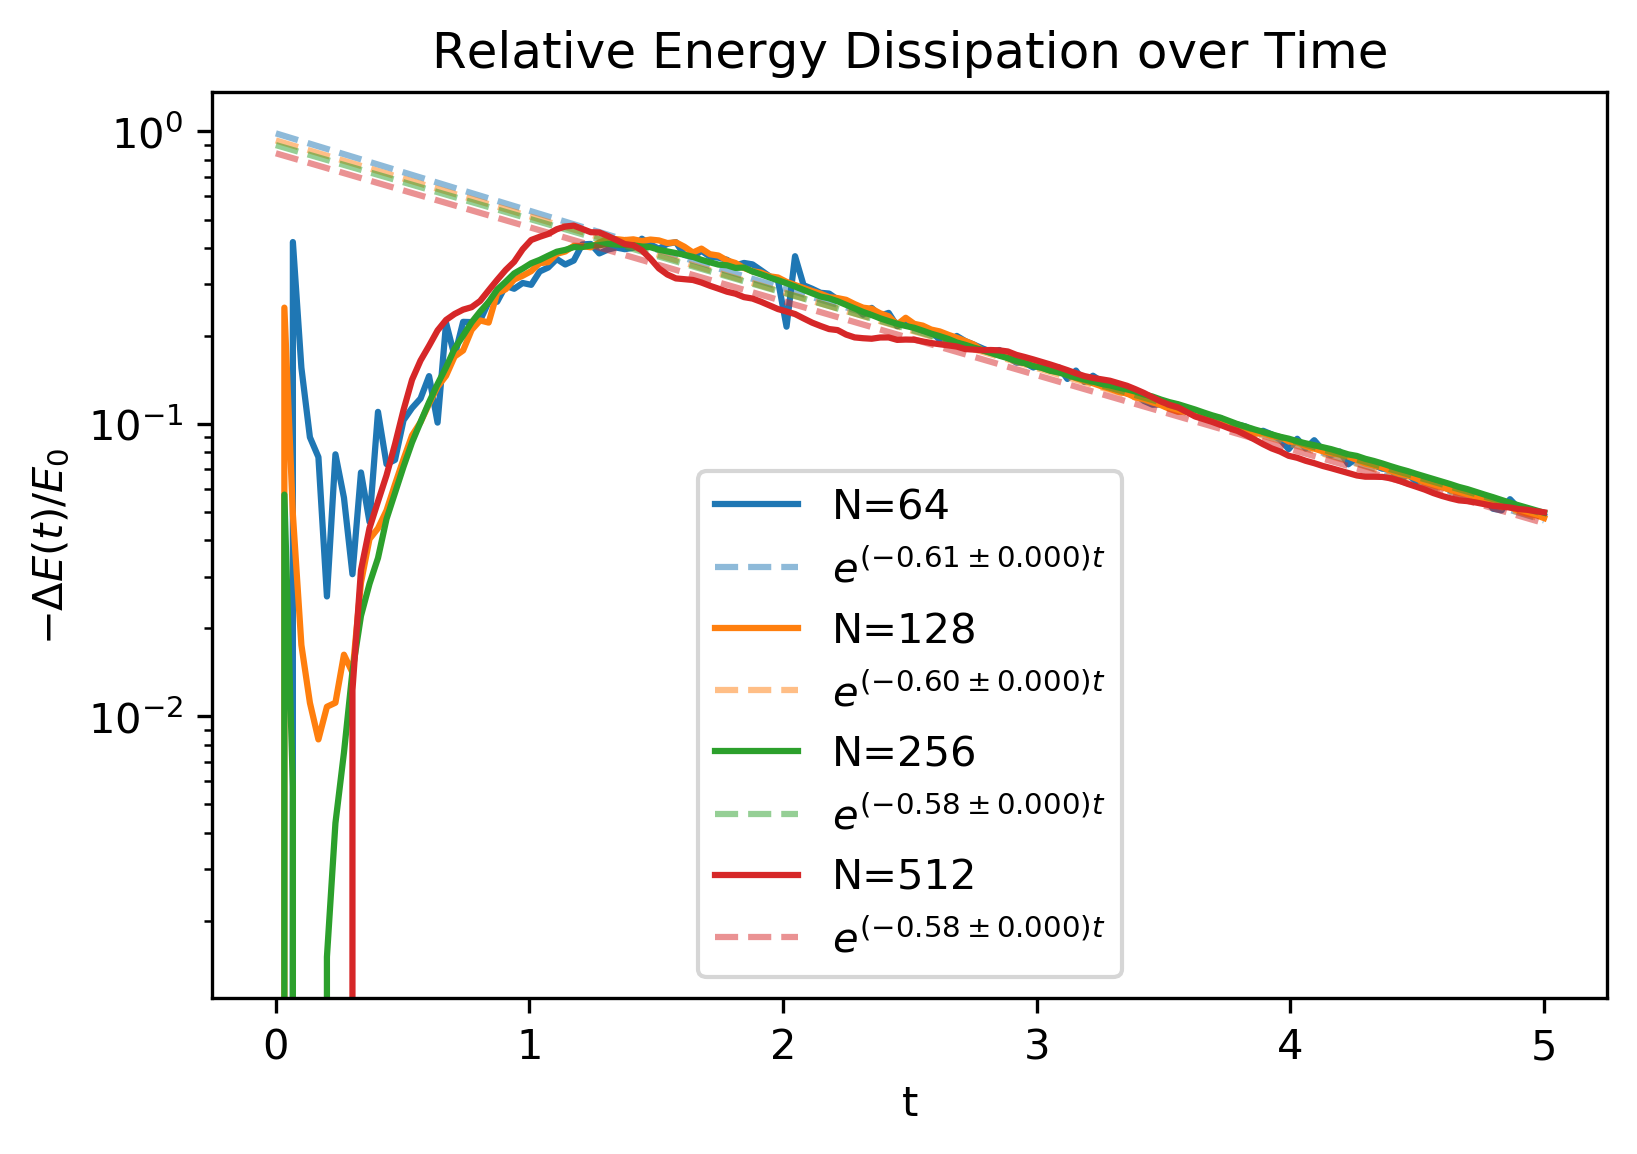

In [8]:
for rho,fi in [(0,[2,5]), (1,[2,5])]:
    plot_spectrum([f'{experiment_folder}/dst_r{rho}_N64',
                   f'{experiment_folder}/dst_r{rho}_N128',
                   f'{experiment_folder}/dst_r{rho}_N256',
                   f'{experiment_folder}/dst_r{rho}_N512'],
                  [64, 128, 256, 512], 0, 0.,
                  save_name=f'{experiment_folder}/dst_r{rho}_energy_spectrum_t0.png')
    plot_spectrum([f'{experiment_folder}/dst_r{rho}_N64',
                   f'{experiment_folder}/dst_r{rho}_N128',
                   f'{experiment_folder}/dst_r{rho}_N256',
                   f'{experiment_folder}/dst_r{rho}_N512'],
                  [64, 128, 256, 512], 150, 5/3,
                  save_name=f'{experiment_folder}/dst_r{rho}_energy_spectrum_t5.png')
    plot_energy([f'{experiment_folder}/dst_r{rho}_N64',
                 f'{experiment_folder}/dst_r{rho}_N128',
                 f'{experiment_folder}/dst_r{rho}_N256',
                 f'{experiment_folder}/dst_r{rho}_N512'],
                [64, 128, 256, 512], 5/150,
                save_name=f'{experiment_folder}/dst_r{rho}_total_energy.png')
    plot_energy([f'{experiment_folder}/dst_r{rho}_N64',
                 f'{experiment_folder}/dst_r{rho}_N128',
                 f'{experiment_folder}/dst_r{rho}_N256',
                 f'{experiment_folder}/dst_r{rho}_N512'],
                [64, 128, 256, 512], 5/150, loglog=True,
                save_name=f'{experiment_folder}/dst_r{rho}_total_energy_log.png')
    plot_relative_energy_dissipation([f'{experiment_folder}/dst_r{rho}_N64',
                                      f'{experiment_folder}/dst_r{rho}_N128',
                                      f'{experiment_folder}/dst_r{rho}_N256',
                                      f'{experiment_folder}/dst_r{rho}_N512'],
                                     [64, 128, 256, 512], 5/150,
                                     save_name=f'{experiment_folder}/dst_r{rho}_relative_energy_dissipation.png')
    plot_relative_energy_dissipation([f'{experiment_folder}/dst_r{rho}_N64',
                                      f'{experiment_folder}/dst_r{rho}_N128',
                                      f'{experiment_folder}/dst_r{rho}_N256',
                                      f'{experiment_folder}/dst_r{rho}_N512'],
                                     [64, 128, 256, 512], 5/150, loglog=True, fit_interval=fi,
                                     save_name=f'{experiment_folder}/dst_r{rho}_relative_energy_dissipation_log.png')